In [5]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas()
from absplice_scripts.visualization.benchmark import get_performance
import pickle
from plotnine import *

import plotnine as p9
import matplotlib.cm as cm

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [61]:
source_data = '../../../AbSplice_analysis/workflow/data/results/source_data/'
SAVE_DIR = '../../../AbSplice_analysis/workflow/data/results/FIGURES/'

absplice2_model_path = 'path_to_absplice2_model'

In [ ]:
DATA_DIR = '../../../AbSplice_analysis/workflow/data/results/'

In [8]:
tissues = [
    'Adipose_Subcutaneous',
    'Adipose_Visceral_Omentum',
    'Adrenal_Gland',
    'Artery_Aorta',
    'Artery_Coronary',
    'Artery_Tibial',
    'Brain_Amygdala',
    'Brain_Anterior_cingulate_cortex_BA24',
    'Brain_Caudate_basal_ganglia',
    'Brain_Cerebellar_Hemisphere',
    'Brain_Cerebellum',
    'Brain_Cortex',
    'Brain_Frontal_Cortex_BA9',
    'Brain_Hippocampus',
    'Brain_Hypothalamus',
    'Brain_Nucleus_accumbens_basal_ganglia',
    'Brain_Putamen_basal_ganglia',
    'Brain_Spinal_cord_cervical_c_1',
    'Brain_Substantia_nigra',
    'Breast_Mammary_Tissue',
    'Cells_Cultured_fibroblasts',
    'Cells_EBV_transformed_lymphocytes',
    'Colon_Sigmoid',
    'Colon_Transverse',
    'Esophagus_Gastroesophageal_Junction',
    'Esophagus_Mucosa',
    'Esophagus_Muscularis',
    'Heart_Atrial_Appendage',
    'Heart_Left_Ventricle',
    'Kidney_Cortex',
    'Liver',
    'Lung',
    'Minor_Salivary_Gland',
    'Muscle_Skeletal',
    'Nerve_Tibial',
    'Ovary',
    'Pancreas',
    'Pituitary',
    'Prostate',
    'Skin_Not_Sun_Exposed_Suprapubic',
    'Skin_Sun_Exposed_Lower_leg',
    'Small_Intestine_Terminal_Ileum',
    'Spleen',
    'Stomach',
    'Testis',
    'Thyroid',
    'Uterus',
    'Vagina',
    'Whole_Blood',
]

# PR curves for paper

In [5]:
df_benchmark = pd.read_parquet(os.path.join(source_data, 'joined_benchmark_dna_gene_tpm.parquet'))

In [65]:
def compare_aps(df, model1, model2, alternative='greater'):
    aps_model_1 = df.loc[model1]['aps']
    aps_model_2 = df.loc[model2]['aps']
    
    aps_model_1 = aps_model_1.sort_index()
    aps_model_2 = aps_model_2.sort_index()

    print(f'Average precision improvement: {aps_model_1.mean() / aps_model_2.mean()}')
    
    stat, p_value = wilcoxon(aps_model_1, aps_model_2, alternative=alternative)
    print(f"Wilcoxon signed-rank test: statistic={stat:.4f}, p-value={p_value:.4g}")
    return stat, p_value

## FRASER1 and FRASER2 ground truth impact

In [6]:
model_dict1 = {
    'AbSplice-DNA (trained on FRASER1, evaluated on FRASER1)': 'AbSplice_DNA_published',
    'AbSplice-DNA (trained on FRASER2, evaluated on FRASER1)': 'AbSplice_DNA_spliceai_modified_input'
}

100%|██████████| 2/2 [00:00<00:00,  3.73it/s]


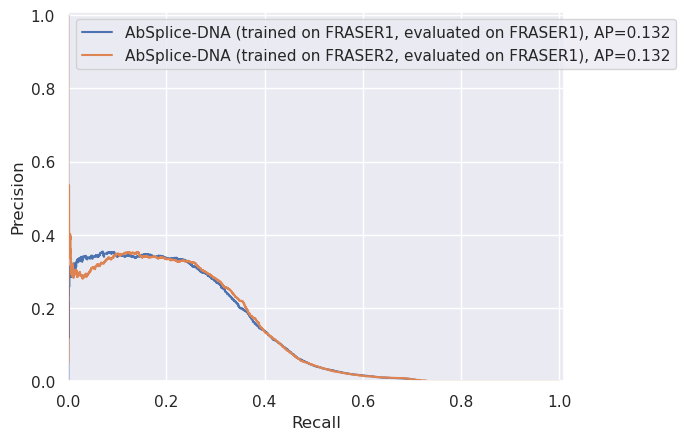

In [7]:
df_performance1, performance = get_performance(
    df = df_benchmark, 
    outlier_column = 'outlier_fraser1', 
    model_dict = model_dict1,
)

In [8]:
model_dict2 = {
    'AbSplice-DNA (trained on FRASER1, evaluated on FRASER2)': 'AbSplice_DNA_published',
    'AbSplice-DNA (trained on FRASER2, evaluated on FRASER2)': 'AbSplice_DNA_spliceai_modified_input'
}

100%|██████████| 2/2 [00:00<00:00,  3.81it/s]


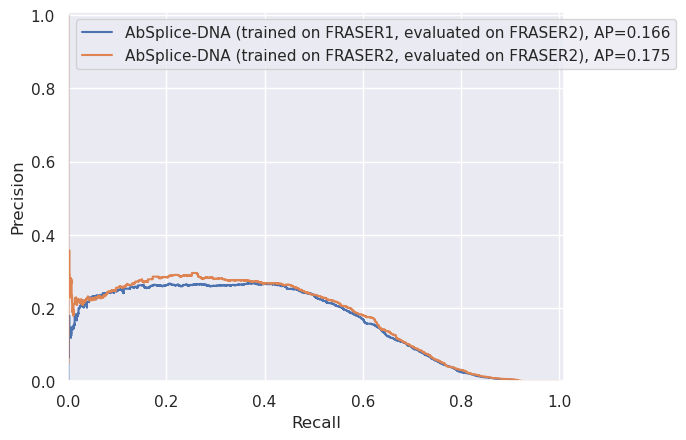

In [9]:
df_performance2, performance = get_performance(
    df = df_benchmark, 
    outlier_column = 'outlier', 
    model_dict = model_dict2,
)

In [10]:
df_performance = pd.concat([
    df_performance1,
    df_performance2
])

In [11]:
df_performance.to_csv(os.path.join(SAVE_DIR,  'pr_curve_FRASER1_and_FRASER2_ground_truth.csv'), index=False)

### Performance across tissues

In [12]:
model_dict1 = {
    'AbSplice-DNA (trained on FRASER1, evaluated on FRASER1)': 'AbSplice_DNA_published',
    'AbSplice-DNA (trained on FRASER2, evaluated on FRASER1)': 'AbSplice_DNA_spliceai_modified_input'
}

100%|██████████| 49/49 [03:18<00:00,  4.05s/it]


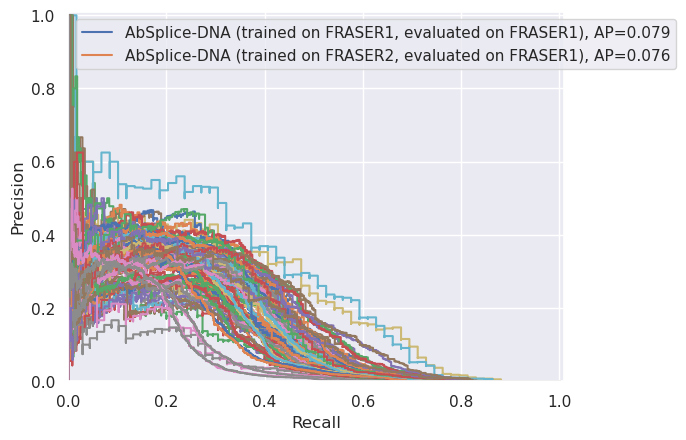

In [13]:
df_performance1 = []
for tissue in tqdm(tissues):
    _df = df_benchmark[df_benchmark['tissue'] == tissue]
    _df_performance1, performance = get_performance(
        df = _df, 
        outlier_column = 'outlier_fraser1', 
        model_dict = model_dict1,
    )
    _df_performance1['tissue'] = tissue
    df_performance1.append(_df_performance1)
df_performance1 = pd.concat(df_performance1)

In [14]:
model_dict2 = {
    'AbSplice-DNA (trained on FRASER1, evaluated on FRASER2)': 'AbSplice_DNA_published',
    'AbSplice-DNA (trained on FRASER2, evaluated on FRASER2)': 'AbSplice_DNA_spliceai_modified_input'
}

100%|██████████| 49/49 [03:23<00:00,  4.15s/it]


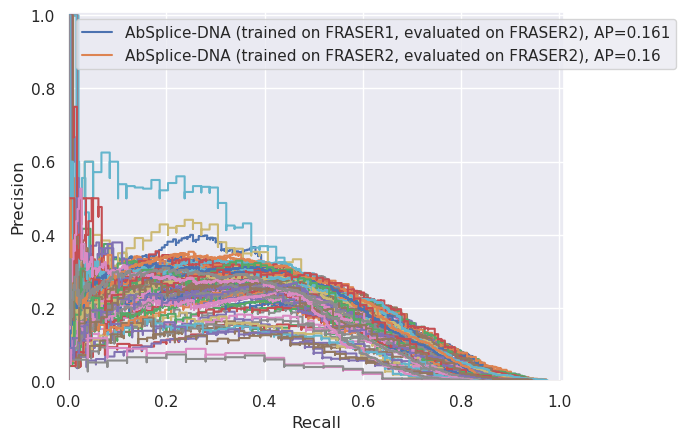

In [15]:
df_performance2 = []
for tissue in tqdm(tissues):
    _df = df_benchmark[df_benchmark['tissue'] == tissue]
    _df_performance2, performance = get_performance(
        df = _df, 
        outlier_column = 'outlier', 
        model_dict = model_dict2,
    )
    _df_performance2['tissue'] = tissue
    df_performance2.append(_df_performance2)
df_performance2 = pd.concat(df_performance2)

In [16]:
df_performance = pd.concat([
    df_performance1,
    df_performance2
])

In [17]:
df_performance = df_performance[[
    'model', 'aps', 'tissue'
]].drop_duplicates()

In [18]:
df_performance = df_performance.rename(columns={'aps': 'Average Precision Score'})

In [19]:
df_performance.to_csv(os.path.join(SAVE_DIR, 'pr_curve_FRASER1_and_FRASER2_ground_truth_boxplot.csv'), index=False)

## Signed features SpliceAI and Pangolin

In [6]:
model_dict = {
    'SpliceAI Delta Score': 'delta_score_spliceai', 
    'AbSplice-DNA (SpliceAI max score)': 'AbSplice_DNA_spliceai_fraser2',
    'AbSplice-DNA (Pangolin max score)': 'AbSplice_DNA_pangolin_binary',
    'Pangolin Score': 'pangolin_score',
    'AbSplice-DNA (Pangolin all scores, signed)': 'AbSplice_DNA_pangolin_two_scores_binary_modified_input',
    'AbSplice-DNA (Pangolin max score, signed)': 'AbSplice_DNA_pangolin_signed_binary_modified_input',
    'AbSplice-DNA (SpliceAI all scores, signed)': 'AbSplice_DNA_spliceai_four_scores_signed_modified_input',
    'AbSplice-DNA (SpliceAI max score, signed)': 'AbSplice_DNA_spliceai_single_score_signed_modified_input',
}

100%|██████████| 8/8 [00:02<00:00,  3.84it/s]


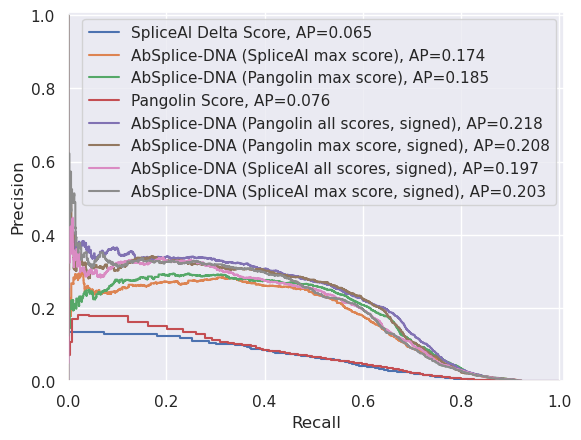

In [21]:
df_performance, performance = get_performance(
    df = df_benchmark, 
    outlier_column = 'outlier', 
    model_dict = model_dict,
)

In [22]:
df_performance.to_csv(os.path.join(SAVE_DIR, 'pr_curve_signed_features_SpliceAI_Pangolin.csv'), index=False)

100%|██████████| 49/49 [04:04<00:00,  4.99s/it]


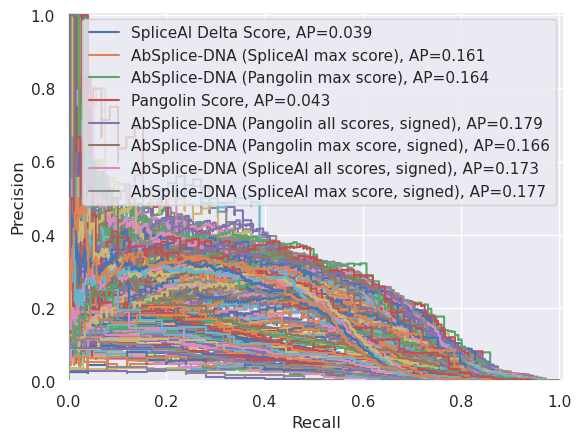

In [15]:
df_all_performances = []
for tissue in tqdm(tissues):
    df_performance2, performance = get_performance(
        df = df_benchmark[df_benchmark['tissue'] == tissue], 
        outlier_column = 'outlier', 
        model_dict = model_dict,
    )
    df_performance2['tissue'] = tissue
    df_all_performances.append(df_performance2)
df_all_performances = pd.concat(df_all_performances)

In [19]:
_df_box = df_all_performances[['model', 'aps', 'tissue']].drop_duplicates().set_index('model')

In [41]:
_,_ = compare_aps(_df_box, 
            model1='AbSplice-DNA (SpliceAI all scores, signed)', 
            model2='AbSplice-DNA (SpliceAI max score)')

Average precision improvement: 1.1208791208791211
Wilcoxon signed-rank test: statistic=1041.0000, p-value=3.254e-06


In [40]:
_,_ = compare_aps(_df_box, 
            model1='AbSplice-DNA (Pangolin all scores, signed)', 
            model2='AbSplice-DNA (SpliceAI all scores, signed)')

Average precision improvement: 1.0947357203751065
Wilcoxon signed-rank test: statistic=1121.0000, p-value=1.251e-08


## Continous median_n impact

In [42]:
model_dict2 = {
    'AbSplice-DNA (Pangolin all scores, binary)': 'AbSplice_DNA_pangolin_two_scores_binary_modified_input',
    'AbSplice-DNA (Pangolin all scores, continuous)': 'AbSplice_DNA_pangolin_two_scores_median_n_modified_input',
    'AbSplice-DNA (SpliceAI all scores, binary)': 'AbSplice_DNA_spliceai_fraser2',
    'AbSplice-DNA (SpliceAI all scores, continuous)': 'AbSplice_DNA_spliceai_median_n',
}

100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


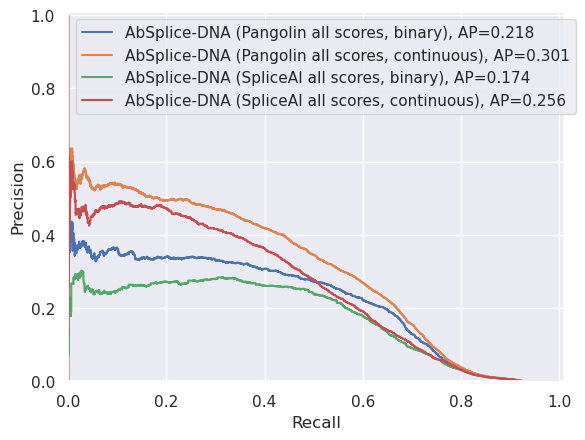

In [43]:
df_performance, performance = get_performance(
    df = df_benchmark, 
    outlier_column = 'outlier', 
    model_dict = model_dict2,
)

In [25]:
df_performance.to_csv(os.path.join(SAVE_DIR,  'pr_curve_continous_median_n_impact.csv'), index=False)

100%|██████████| 49/49 [03:31<00:00,  4.32s/it]


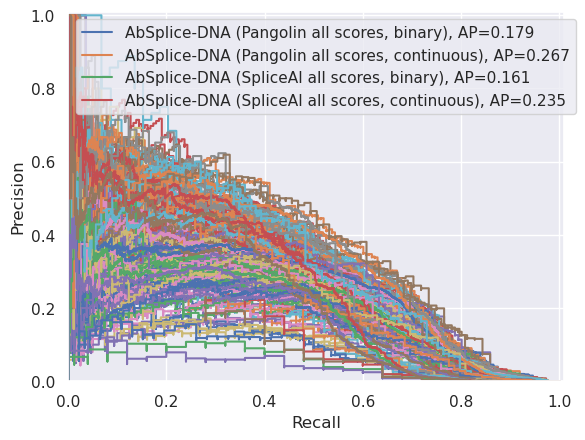

In [44]:
df_all_performances = []
for tissue in tqdm(tissues):
    df_performance2, performance = get_performance(
        df = df_benchmark[df_benchmark['tissue'] == tissue], 
        outlier_column = 'outlier', 
        model_dict = model_dict2,
    )
    df_performance2['tissue'] = tissue
    df_all_performances.append(df_performance2)
df_all_performances = pd.concat(df_all_performances)

In [45]:
_df_box = df_all_performances[['model', 'aps', 'tissue']].drop_duplicates().set_index('model')

In [46]:
_,_ = compare_aps(_df_box, 
            model1='AbSplice-DNA (Pangolin all scores, continuous)', 
            model2='AbSplice-DNA (Pangolin all scores, binary)')

Average precision improvement: 1.4149712839482136
Wilcoxon signed-rank test: statistic=1225.0000, p-value=1.776e-15


## Final AbSplice2 model

In [26]:
model_dict1 = {
    'AbSplice-DNA 1 (trained on FRASER1, evaluated on FRASER1)': 'AbSplice_DNA_published',
}

100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


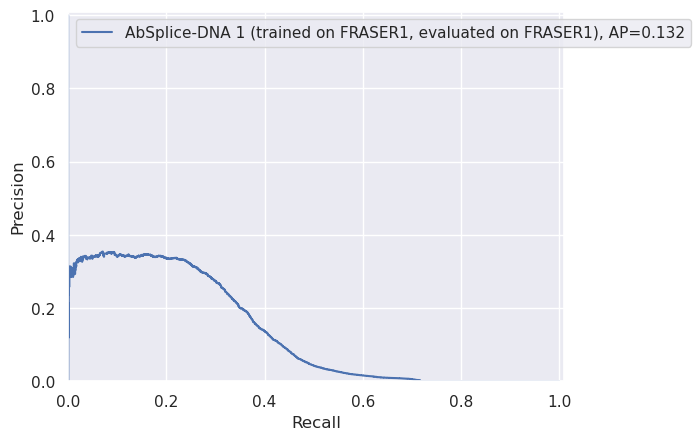

In [27]:
df_performance1, performance1 = get_performance(
    df = df_benchmark, 
    outlier_column = 'outlier_fraser1', 
    model_dict = model_dict1,
)

In [28]:
model_dict2 = {
    'AbSplice-DNA 1 (trained on FRASER1, evaluated on FRASER2)': 'AbSplice_DNA_published',
    'AbSplice-DNA (SpliceAI -> Pangolin)': 'AbSplice_DNA_pangolin_two_scores_binary_modified_input',
    'AbSplice-DNA 2': 'AbSplice_DNA_pangolin_two_scores_median_n_modified_input',
    'Pangolin': 'pangolin_score',
    'SpliceAI': 'delta_score_spliceai',
}

100%|██████████| 5/5 [00:01<00:00,  3.83it/s]


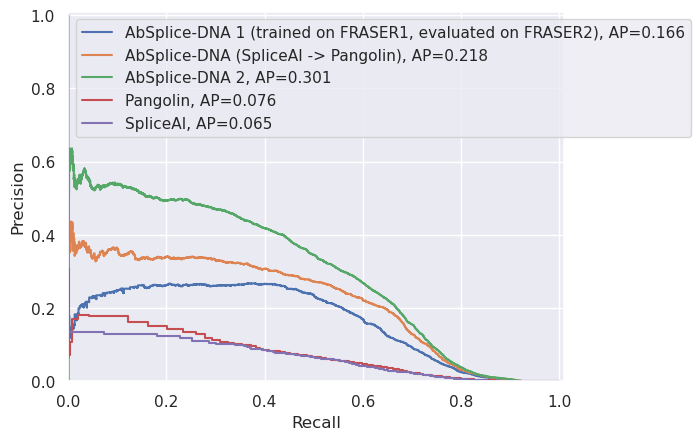

In [29]:
df_performance2, performance2 = get_performance(
    df = df_benchmark, 
    outlier_column = 'outlier', 
    model_dict = model_dict2,
)

In [30]:
df_performance = pd.concat([
    df_performance1,
    df_performance2
])

In [31]:
df_performance.to_csv(os.path.join(SAVE_DIR,  'pr_curve_final_absplice2_model.csv'), index=False)

### performance across tissues

100%|██████████| 49/49 [03:46<00:00,  4.62s/it]


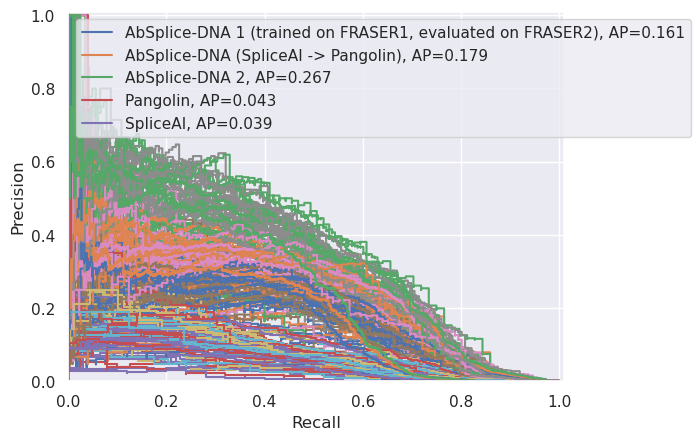

In [32]:
df_all_performances = []
for tissue in tqdm(tissues):
    df_performance2, performance = get_performance(
        df = df_benchmark[df_benchmark['tissue'] == tissue], 
        outlier_column = 'outlier', 
        model_dict = model_dict2,
    )
    df_performance2['tissue'] = tissue
    df_all_performances.append(df_performance2)

100%|██████████| 49/49 [03:47<00:00,  4.63s/it]


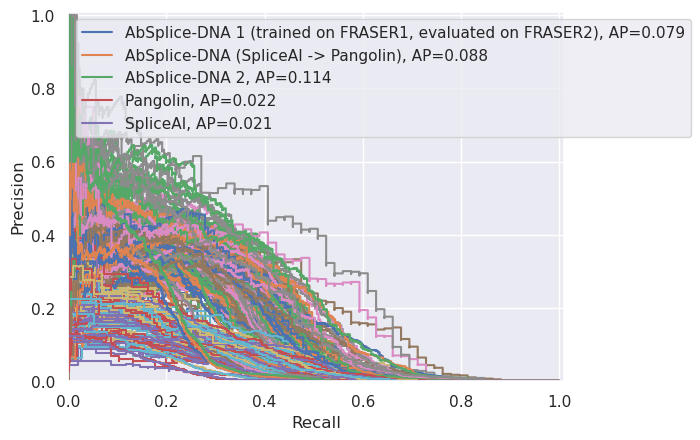

In [33]:
df_all_performances_fraser1 = []
for tissue in tqdm(tissues):
    df_performance2, performance = get_performance(
        df = df_benchmark[df_benchmark['tissue'] == tissue], 
        outlier_column = 'outlier_fraser1', 
        model_dict = model_dict2,
    )
    df_performance2['tissue'] = tissue
    df_all_performances_fraser1.append(df_performance2)
df_all_performances_fraser1 = pd.concat(df_all_performances_fraser1)

In [34]:
pd.concat(df_all_performances).to_csv(os.path.join(SAVE_DIR,  'pr_curve_for_all_GTEx_tissues.csv'), index=False)

In [35]:
df_all_performances_boxplot_fraser2 = pd.concat(df_all_performances)
df_all_performances_boxplot_fraser2 = df_all_performances_boxplot_fraser2[[
    'model', 'aps', 'tissue'
]].drop_duplicates()

In [36]:
df_all_performances_boxplot_fraser1 = df_all_performances_fraser1[[
    'model', 'aps', 'tissue'
]].drop_duplicates()
df_all_performances_boxplot_fraser1 = df_all_performances_boxplot_fraser1[df_all_performances_boxplot_fraser1['model'] == 'AbSplice1']
df_all_performances_boxplot_fraser1 = df_all_performances_boxplot_fraser1.replace('AbSplice1', 'AbSplice-DNA 1 (trained on FRASER1, evaluated on FRASER1)')

In [37]:
df_all_performances_boxplot_fraser2 = df_all_performances_boxplot_fraser2.replace('AbSplice1', 'AbSplice-DNA 1 (trained on FRASER1, evaluated on FRASER2)')
df_all_performances_boxplot_fraser2 = df_all_performances_boxplot_fraser2.replace('AbSplice1 (SpliceAI -> Pangolin)', 'AbSplice-DNA (SpliceAI -> Pangolin)')
df_all_performances_boxplot_fraser2 = df_all_performances_boxplot_fraser2.replace('AbSplice2', 'AbSplice-DNA 2')

In [38]:
df_all_performances_boxplot = pd.concat([
    df_all_performances_boxplot_fraser1,
    df_all_performances_boxplot_fraser2
])

In [39]:
df_all_performances_boxplot = df_all_performances_boxplot.rename(columns={'aps': 'Average Precision Score'})

In [40]:
df_all_performances_boxplot.to_csv(os.path.join(SAVE_DIR,  'boxplot_all_tissues_GTEx.csv'), index=False)

### AbSplice-RNA

In [41]:
df_rna = pd.read_parquet(os.path.join(source_data, 'joined_benchmark_dna_rna.parquet'))

100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


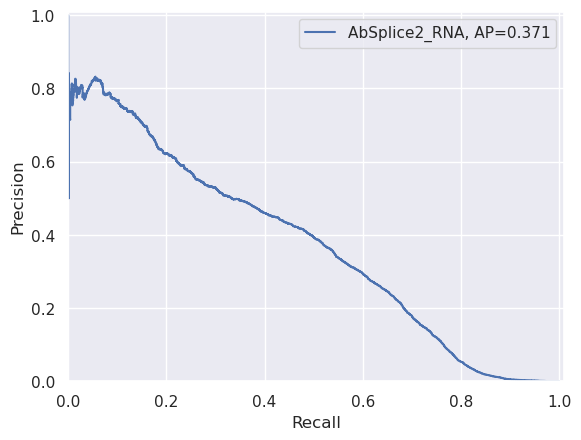

In [42]:
df_performance, performance = get_performance(
    df = df_rna, 
    outlier_column = 'outlier', 
    model_dict = {
        'AbSplice2_RNA': 'AbSplice_RNA_2_temporary',
    },
)

In [43]:
df_performance.to_csv(os.path.join(SAVE_DIR,  'pr_curve_AbSplice_RNA.csv'), index=False)

100%|██████████| 49/49 [03:19<00:00,  4.06s/it]


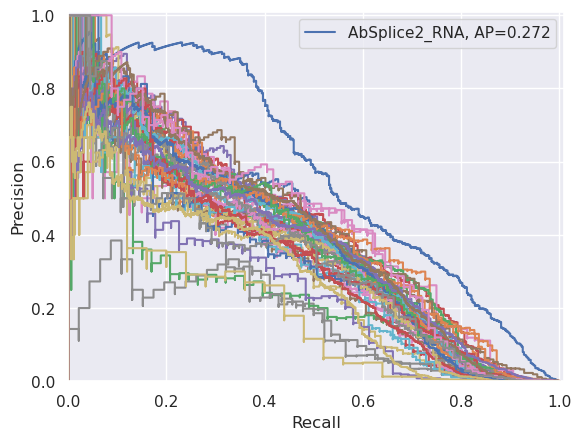

In [44]:
df_all_performances = []
for tissue in tqdm(tissues):
    df_performance2, performance = get_performance(
        df = df_rna[df_rna['tissue'] == tissue], 
        outlier_column = 'outlier', 
        model_dict = {
            'AbSplice2_RNA': 'AbSplice_RNA_2_temporary',
        },
    )
    df_performance2['tissue'] = tissue
    df_all_performances.append(df_performance2)

In [45]:
df_box = pd.concat(df_all_performances)[['model', 'aps', 'tissue']].drop_duplicates().rename(columns={'aps': 'Average Precision Score'})

In [46]:
df_box.to_csv(os.path.join(SAVE_DIR, 'boxplot_all_tissues_GTEx_AbSplice_RNA.csv'), index=False)

## Max aggregation decreases performance

In [47]:
model_dict = {
    'SpliceAI': 'delta_score_spliceai', 
    'Pangolin': 'pangolin_score',
    'AbSplice-DNA 1': 'AbSplice_DNA_published',
    'AbSplice-DNA 2': 'AbSplice_DNA_no_mmsplice_pangolin_tissue',

    'AbSplice DNA 2 (max all)': 'AbSplice_DNA_pangolin_two_scores_median_n_modified_input_max_all',
    'AbSplice DNA 1 (max all)': 'AbSplice_DNA_published_max_all',
    'AbSplice DNA 2 (max main tissues)': 'AbSplice_DNA_pangolin_two_scores_median_n_modified_input_main_tissue',
    'AbSplice DNA 2 (max dev tissues)': 'AbSplice_DNA_pangolin_two_scores_median_n_modified_input_main_tissue_kaessmann',
    'AbSplice DNA 1 (max main tissues)': 'AbSplice_DNA_published_main_tissue',
    'AbSplice DNA 1 (max dev tissues)': 'AbSplice_DNA_published_main_tissue_kaessmann',
}

100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


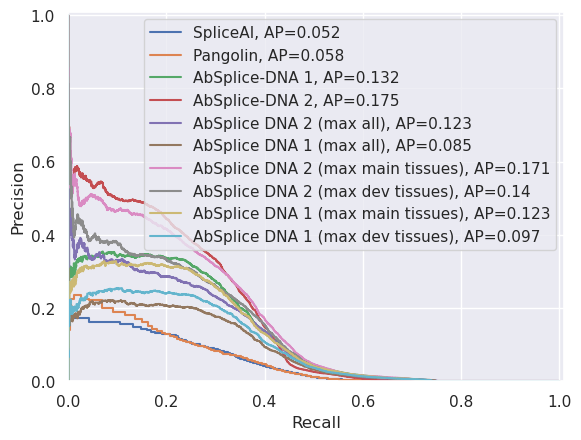

In [48]:
df_performance1, performance = get_performance(
    df = df_benchmark, 
    outlier_column = 'outlier_fraser1', 
    model_dict = model_dict,
)

In [49]:
df_performance1['outlier'] = 'FRASER1'

100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


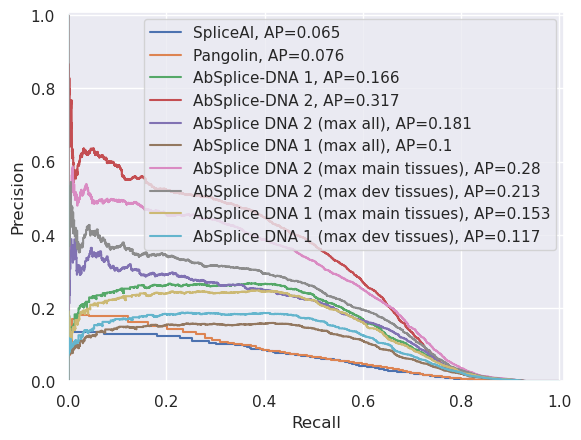

In [50]:
df_performance2, performance = get_performance(
    df = df_benchmark, 
    outlier_column = 'outlier', 
    model_dict = model_dict,
)

In [51]:
df_performance2['outlier'] = 'FRASER2'

In [52]:
df_performance = pd.concat([
    df_performance1,
    df_performance2
])

In [53]:
df_performance.to_csv(os.path.join(SAVE_DIR,  'pr_curve_max_aggregation_decreases_performance.csv'), index=False)

## Performance across gene expression values

In [54]:
model_dict = {
    'SpliceAI': 'delta_score_spliceai',
    'Pangolin': 'pangolin_score',
    'AbSplice-DNA 1': 'AbSplice_DNA_spliceai_modified_input',
    'AbSplice-DNA 2': 'AbSplice_DNA_no_mmsplice_pangolin_tissue',
    'AbSplice-DNA with gene TPM': 'AbSplice_DNA_pangolin_two_scores_gene_tpm',
}

0it [00:00, ?it/s]
100%|██████████| 5/5 [00:00<00:00, 10.11it/s]
1it [00:22, 22.69s/it]
100%|██████████| 5/5 [00:00<00:00, 44.56it/s]
2it [00:28, 12.77s/it]
100%|██████████| 5/5 [00:00<00:00, 25.81it/s]
3it [00:37, 11.24s/it]
100%|██████████| 5/5 [00:00<00:00, 23.80it/s]
4it [00:48, 10.96s/it]
100%|██████████| 5/5 [00:00<00:00, 24.62it/s]
5it [00:58, 10.57s/it]
100%|██████████| 5/5 [00:00<00:00, 48.20it/s]
6it [01:03, 10.58s/it]


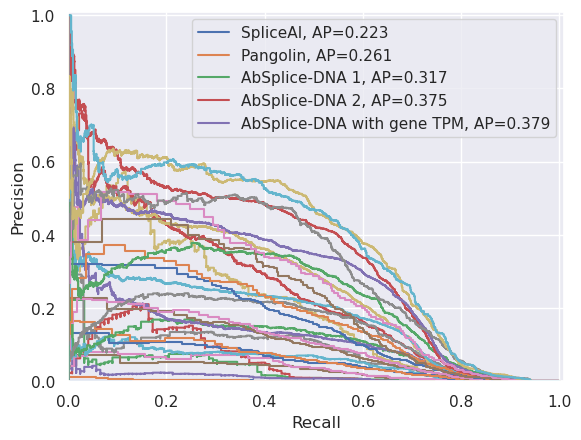

In [55]:
cutoffs = [
    (0, 3), (3, 5), 
    (5, 10), (10, 20), (20, 50), (50, np.inf)
]

df_performances = []
df_stats = []

for i, cutoff_pair in tqdm(enumerate(cutoffs)):
    low_cutoff, high_cutoff = cutoff_pair
    df_plot = df_benchmark[
        (df_benchmark['gene_tpm']>=low_cutoff)
        &
        (df_benchmark['gene_tpm']<high_cutoff)
    ].copy()
    df_performance, performance = get_performance(
        df = df_plot, 
        outlier_column = 'outlier', 
        model_dict = model_dict,
    )
    df_performance['cutoff_pair'] = f'{cutoff_pair}'
    df_performances.append(df_performance)

    df_stat = pd.DataFrame({
        'tpm_cutoff': f'{cutoff_pair}',
        'num_outliers': df_plot['outlier'].sum(),
    }, index=[0])
    df_stats.append(df_stat)
df_performances = pd.concat(df_performances)
df_stats = pd.concat(df_stats)

In [56]:
df_stats['tpm_cutoff_label'] = df_stats.apply(lambda df: f'TPM = {df["tpm_cutoff"]}, #outliers = {df["num_outliers"]}', axis=1)

In [57]:
df_performances.to_csv(os.path.join(SAVE_DIR,  'pr_curve_across_gene_expression_values.csv'), index=False)
df_stats.to_csv(os.path.join(SAVE_DIR,  'pr_curve_across_gene_expression_values_stats.csv'), index=False)

# Feature importance

## FRASER1 vs FRASER2

In [58]:
ebm_model_fraser1_path = '/data/ceph/hdd/project/node_01/absplice/AbSplice_analysis/data/results/gtex_v8/splicing_predictions/raw_pred/absplice/absplice_training/whole_GTEx/classifier=interpretml/delta_logit_psi__delta_psi__delta_score__splice_site_is_expressed/abs_features=False/AbSplice_DNA_trained_on_whole_GTEx.pkl'
ebm_model_fraser2_path = '/data/ceph/hdd/project/node_01/absplice/AbSplice_2_0/training/raw_pred/old_conda/whole_GTEx/added_positive_delta_psi_samples/classifier=interpretml/delta_logit_psi__delta_psi__delta_score__splice_site_is_expressed/abs_features=False/AbSplice_DNA_trained_on_whole_GTEx.pkl'

In [59]:
# Load the model from the pkl file
with open(ebm_model_fraser1_path, "rb") as file:
    ebm_model_fraser1 = pickle.load(file)

feature_names = [x for x in ebm_model_fraser1.feature_names if ' x ' not in x]
feature_indices = [ebm_model_fraser1.feature_names.index(x) for x in feature_names]

x_list_fraser1 = []
y_list_fraser1 = []

for feature_idx in feature_indices:
    try:
        x_list_fraser1.append(ebm_model_fraser1.preprocessor_.col_bin_edges_[feature_idx])
    except:
        pass
    try:
        y_list_fraser1.append(ebm_model_fraser1.additive_terms_[feature_idx])
    except:
        pass

In [60]:
# Load the model from the pkl file
with open(ebm_model_fraser2_path, "rb") as file:
    ebm_model_fraser2 = pickle.load(file)

feature_names = [x for x in ebm_model_fraser2.feature_names if ' x ' not in x]
feature_indices = [ebm_model_fraser2.feature_names.index(x) for x in feature_names]

x_list_fraser2 = []
y_list_fraser2 = []

for feature_idx in feature_indices:
    try:
        x_list_fraser2.append(ebm_model_fraser2.preprocessor_.col_bin_edges_[feature_idx])
    except:
        pass
    try:
        y_list_fraser2.append(ebm_model_fraser2.additive_terms_[feature_idx])
    except:
        pass

In [61]:
epsilon = 0.001
x_list_fraser1.append([10-epsilon, 10+epsilon])

epsilon = 0.001
x_list_fraser2.append([10-epsilon, 10+epsilon])

In [62]:
# Define custom x-axis limits for each feature (modify these as needed)
x_ranges = {
    "delta_logit_psi": (-5, 5),
    "delta_psi": (-1, 1),
    "delta_score": (0, 1),
    "gain_score": (0, 1),
    "loss_score": (-1, 0),
    "median_n": (0, 100),
    "splice_site_is_expressed": (0, 100),
}

In [63]:
data = []
for feature_name, x_list, y_list in zip(feature_names, x_list_fraser2, y_list_fraser2):
    # Get x range for the current feature
    x_min, x_max = x_ranges.get(feature_name, (min(x_list), max(x_list)))  # Default to full range if not in x_ranges
    
    # Get y-values at the min and max x values in the available data
    if feature_name == 'splice_site_is_expressed':
        y_values = y_list[1:]
    else:
        y_values = y_list[2:]  # Since we always use y[2:]
    
    y_min = y_values[0]  # First available y value (left extremity)
    y_max = y_values[-1]  # Last available y value (right extremity)

    # Add extrapolated points at x_min and x_max if needed
    if x_min < min(x_list):
        data.append({'x': x_min, 'y': y_min, 'feature': feature_name})  # Fill left boundary
    if x_max > max(x_list):
        data.append({'x': x_max, 'y': y_max, 'feature': feature_name})  # Fill right boundary

    # Add the original data (only within x_min, x_max)
    for x, y in zip(x_list, y_values):
        if x_min <= x <= x_max:
            data.append({'x': x, 'y': y, 'feature': feature_name})

df_plot_fraser2 = pd.DataFrame(data)
df_plot_fraser2['model'] = 'fraser2'

In [64]:
data = []
for feature_name, x_list, y_list in zip(feature_names, x_list_fraser1, y_list_fraser1):
    # Get x range for the current feature
    x_min, x_max = x_ranges.get(feature_name, (min(x_list), max(x_list)))  # Default to full range if not in x_ranges
    
    # Get y-values at the min and max x values in the available data
    if feature_name == 'splice_site_is_expressed':
        y_values = y_list[1:]
    else:
        y_values = y_list[2:]  # Since we always use y[2:]
    
    y_min = y_values[0]  # First available y value (left extremity)
    y_max = y_values[-1]  # Last available y value (right extremity)

    # Add extrapolated points at x_min and x_max if needed
    if x_min < min(x_list):
        data.append({'x': x_min, 'y': y_min, 'feature': feature_name})  # Fill left boundary
    if x_max > max(x_list):
        data.append({'x': x_max, 'y': y_max, 'feature': feature_name})  # Fill right boundary

    # Add the original data (only within x_min, x_max)
    for x, y in zip(x_list, y_values):
        if x_min <= x <= x_max:
            data.append({'x': x, 'y': y, 'feature': feature_name})

df_plot_fraser1 = pd.DataFrame(data)
df_plot_fraser1['model'] = 'fraser1'

In [65]:
df_plot = pd.concat([
    df_plot_fraser2,
    df_plot_fraser1
])

In [66]:
df_plot = df_plot.rename(columns={'x': 'Feature value', 'y': 'Contribution Score'})

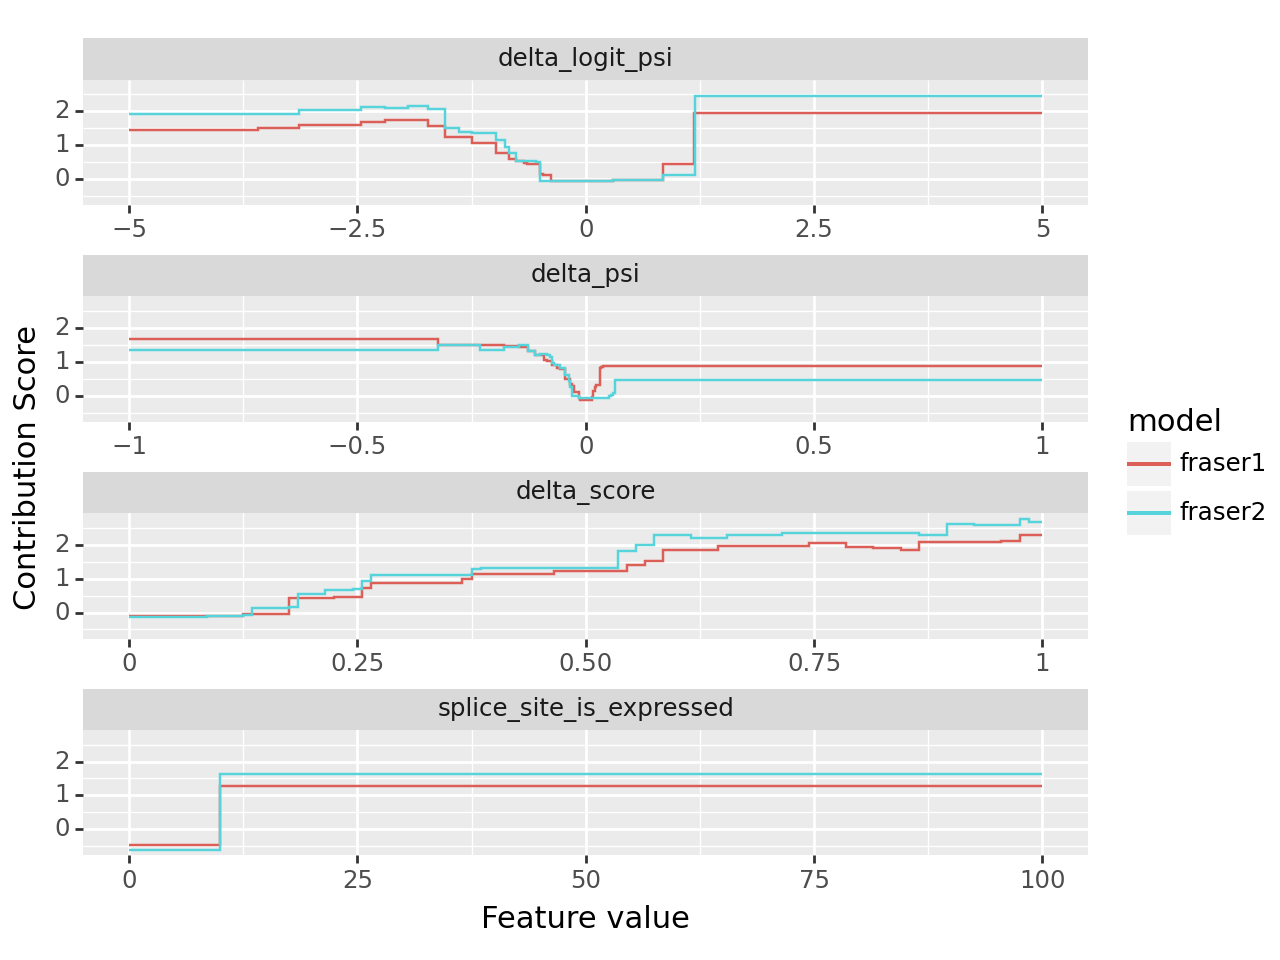

In [67]:
# Define global y-limits (modify as needed)
y_min, y_max = df_plot["Contribution Score"].min(), df_plot["Contribution Score"].max()

# Plot
plot = (
    ggplot(df_plot, aes(x='Feature value', y='Contribution Score', color='model')) +
    geom_step(direction='hv') +
    facet_wrap('~feature', ncol=1, scales='free_x') +  # Single-column layout, x free
    theme(subplots_adjust={'hspace': 0.3}) +  # Adjust spacing between plots
    ylim(y_min, y_max)  # Fix the y-axis range
)

print(plot)

In [68]:
df_plot.to_csv(os.path.join(SAVE_DIR,  'feature_importance_fraser1_and_fraser2.csv'), index=False)

## Binary to continous median_n

In [115]:
root_path_models = '../data/_TMP/raw_pred/old_conda/whole_GTEx/added_positive_delta_psi_samples/classifier=interpretml'
ebm_model_binary_path = os.path.join(
    root_path_models, 
    'delta_logit_psi__delta_psi__gain_score__loss_score__splice_site_is_expressed',
    'abs_features=False/AbSplice_DNA_trained_on_whole_GTEx.pkl'
)
ebm_model_continous_path = os.path.join(
    root_path_models, 
    'delta_logit_psi__delta_psi__gain_score__loss_score__median_n',
    'abs_features=False/AbSplice_DNA_trained_on_whole_GTEx.pkl'
)

In [116]:
# Load the model from the pkl file
with open(ebm_model_binary_path, "rb") as file:
    ebm_model_binary = pickle.load(file)

feature_names = [x for x in ebm_model_binary.feature_names if ' x ' not in x]
feature_indices = [ebm_model_binary.feature_names.index(x) for x in feature_names]

x_list_binary = []
y_list_binary = []

for feature_idx in feature_indices:
    try:
        x_list_binary.append(ebm_model_binary.preprocessor_.col_bin_edges_[feature_idx])
    except:
        pass
    try:
        y_list_binary.append(ebm_model_binary.additive_terms_[feature_idx])
    except:
        pass

In [117]:
# Load the model from the pkl file
with open(ebm_model_continous_path, "rb") as file:
    ebm_model_continous = pickle.load(file)

feature_names = [x for x in ebm_model_continous.feature_names if ' x ' not in x]
feature_indices = [ebm_model_continous.feature_names.index(x) for x in feature_names]

x_list_continous = []
y_list_continous = []

for feature_idx in feature_indices:
    try:
        x_list_continous.append(ebm_model_continous.preprocessor_.col_bin_edges_[feature_idx])
    except:
        pass
    try:
        y_list_continous.append(ebm_model_continous.additive_terms_[feature_idx])
    except:
        pass

In [118]:
epsilon = 0.001
x_list_binary.append([10-epsilon, 10+epsilon])

In [119]:
# Define custom x-axis limits for each feature (modify these as needed)
x_ranges = {
    "delta_logit_psi": (-2, 2),
    "delta_psi": (-1, 1),
    "delta_score": (0, 1),
    "gain_score": (0, 1),
    "loss_score": (-1, 0),
    "median_n": (0, 200),
}

In [120]:
data = []
for feature_name, x_list, y_list in zip(feature_names, x_list_continous, y_list_continous):
    # Get x range for the current feature
    x_min, x_max = x_ranges.get(feature_name, (min(x_list), max(x_list)))  # Default to full range if not in x_ranges
    
    # Get y-values at the min and max x values in the available data
    y_values = y_list[2:]  # Since we always use y[2:]
    
    y_min = y_values[0]  # First available y value (left extremity)
    y_max = y_values[-1]  # Last available y value (right extremity)

    # Add extrapolated points at x_min and x_max if needed
    if x_min < min(x_list):
        data.append({'x': x_min, 'y': y_min, 'feature': feature_name})  # Fill left boundary
    if x_max > max(x_list):
        data.append({'x': x_max, 'y': y_max, 'feature': feature_name})  # Fill right boundary

    # Add the original data (only within x_min, x_max)
    for x, y in zip(x_list, y_values):
        if x_min <= x <= x_max:
            data.append({'x': x, 'y': y, 'feature': feature_name})

df_plot_continous = pd.DataFrame(data)
df_plot_continous['model'] = 'continous'

In [121]:
data = []
for feature_name, x_list, y_list in zip(feature_names, x_list_binary, y_list_binary):
    # Get x range for the current feature
    x_min, x_max = x_ranges.get(feature_name, (min(x_list), max(x_list)))  # Default to full range if not in x_ranges
    
    # Get y-values at the min and max x values in the available data
    if feature_name == 'median_n':
        y_values = y_list[1:]
    else:
        y_values = y_list[2:]  # Since we always use y[2:]
    
    y_min = y_values[0]  # First available y value (left extremity)
    y_max = y_values[-1]  # Last available y value (right extremity)

    # Add extrapolated points at x_min and x_max if needed
    if x_min < min(x_list):
        data.append({'x': x_min, 'y': y_min, 'feature': feature_name})  # Fill left boundary
    if x_max > max(x_list):
        data.append({'x': x_max, 'y': y_max, 'feature': feature_name})  # Fill right boundary

    # Add the original data (only within x_min, x_max)
    for x, y in zip(x_list, y_values):
        if x_min <= x <= x_max:
            data.append({'x': x, 'y': y, 'feature': feature_name})

df_plot_binary = pd.DataFrame(data)
df_plot_binary['model'] = 'binary'

In [122]:
df_plot = pd.concat([
    df_plot_continous,
    df_plot_binary
])

In [123]:
df_plot = df_plot.rename(columns={'x': 'score_value', 'y': 'Contribution Score'})

In [130]:
p9.options.figure_size = (10, 5)

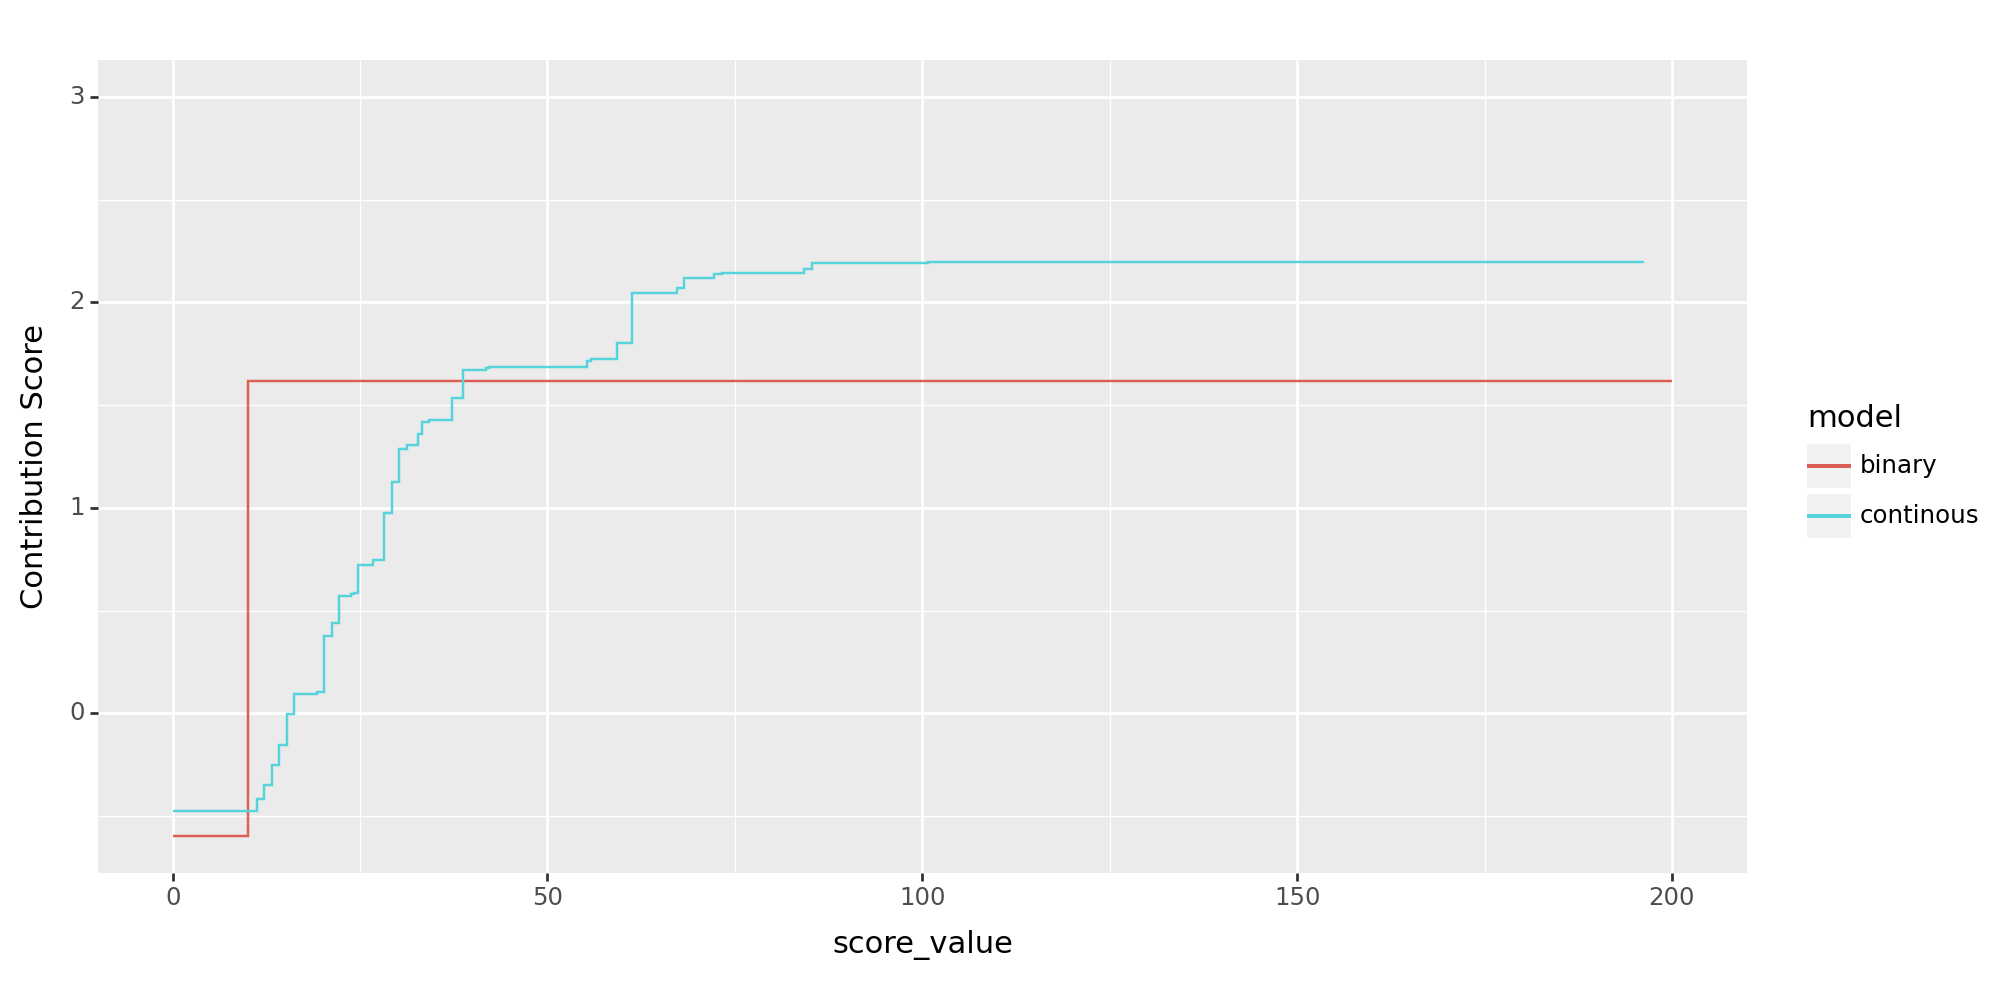

In [131]:
# Plot
plot = (
    ggplot(df_plot[df_plot['feature'] == 'median_n'], aes(x='score_value', y='Contribution Score', color='model')) +
    geom_step(direction='hv') +
    # facet_wrap('~feature', ncol=1, scales='free_x') +  # Single-column layout, x free
    theme(subplots_adjust={'hspace': 0.3}) +  # Adjust spacing between plots
    ylim(y_min, 3)  # Fix the y-axis range
)

print(plot)

In [80]:
df_plot.to_csv(os.path.join(SAVE_DIR,  'feature_importance_binary_and_continous_splice_site_usage.csv'), index=False)

### reranking of intermediate median_n values in AbSplice

In [81]:
df_binary = pd.read_parquet("../../../AbSplice2_analysis/workflow/data/_TMP/raw_pred/old_conda/5_fold_crossval/save_samples/added_positive_delta_psi_samples/classifier=interpretml/delta_logit_psi__delta_psi__gain_score__loss_score__splice_site_is_expressed/abs_features=False/results_all.parquet")
df_continous = pd.read_parquet("../../../AbSplice2_analysis/workflow/data/_TMP/raw_pred/old_conda/5_fold_crossval/save_samples/added_positive_delta_psi_samples/classifier=interpretml/delta_logit_psi__delta_psi__gain_score__loss_score__median_n/abs_features=False/results_all.parquet")

In [82]:
df_binary = df_binary.rename(columns={'y_pred': 'AbSplice_binary'})
df_continous = df_continous.rename(columns={'y_pred': 'AbSplice_continous'})

In [83]:
join_index = ['variant', 'gene_id', 'sample', 'tissue', 'y_test']

In [84]:
df_total = df_binary.set_index(join_index)[['AbSplice_binary']].join(
    df_continous.set_index(join_index)[['AbSplice_continous', 'median_n']]
).reset_index()

In [85]:
num_outliers = df_total[df_total['y_test'] == 1].shape[0]

In [86]:
df_sampled = pd.concat([
    df_total[df_total['y_test'] == 1],
    df_total[df_total['y_test'] == 0].sample(100*num_outliers),
])

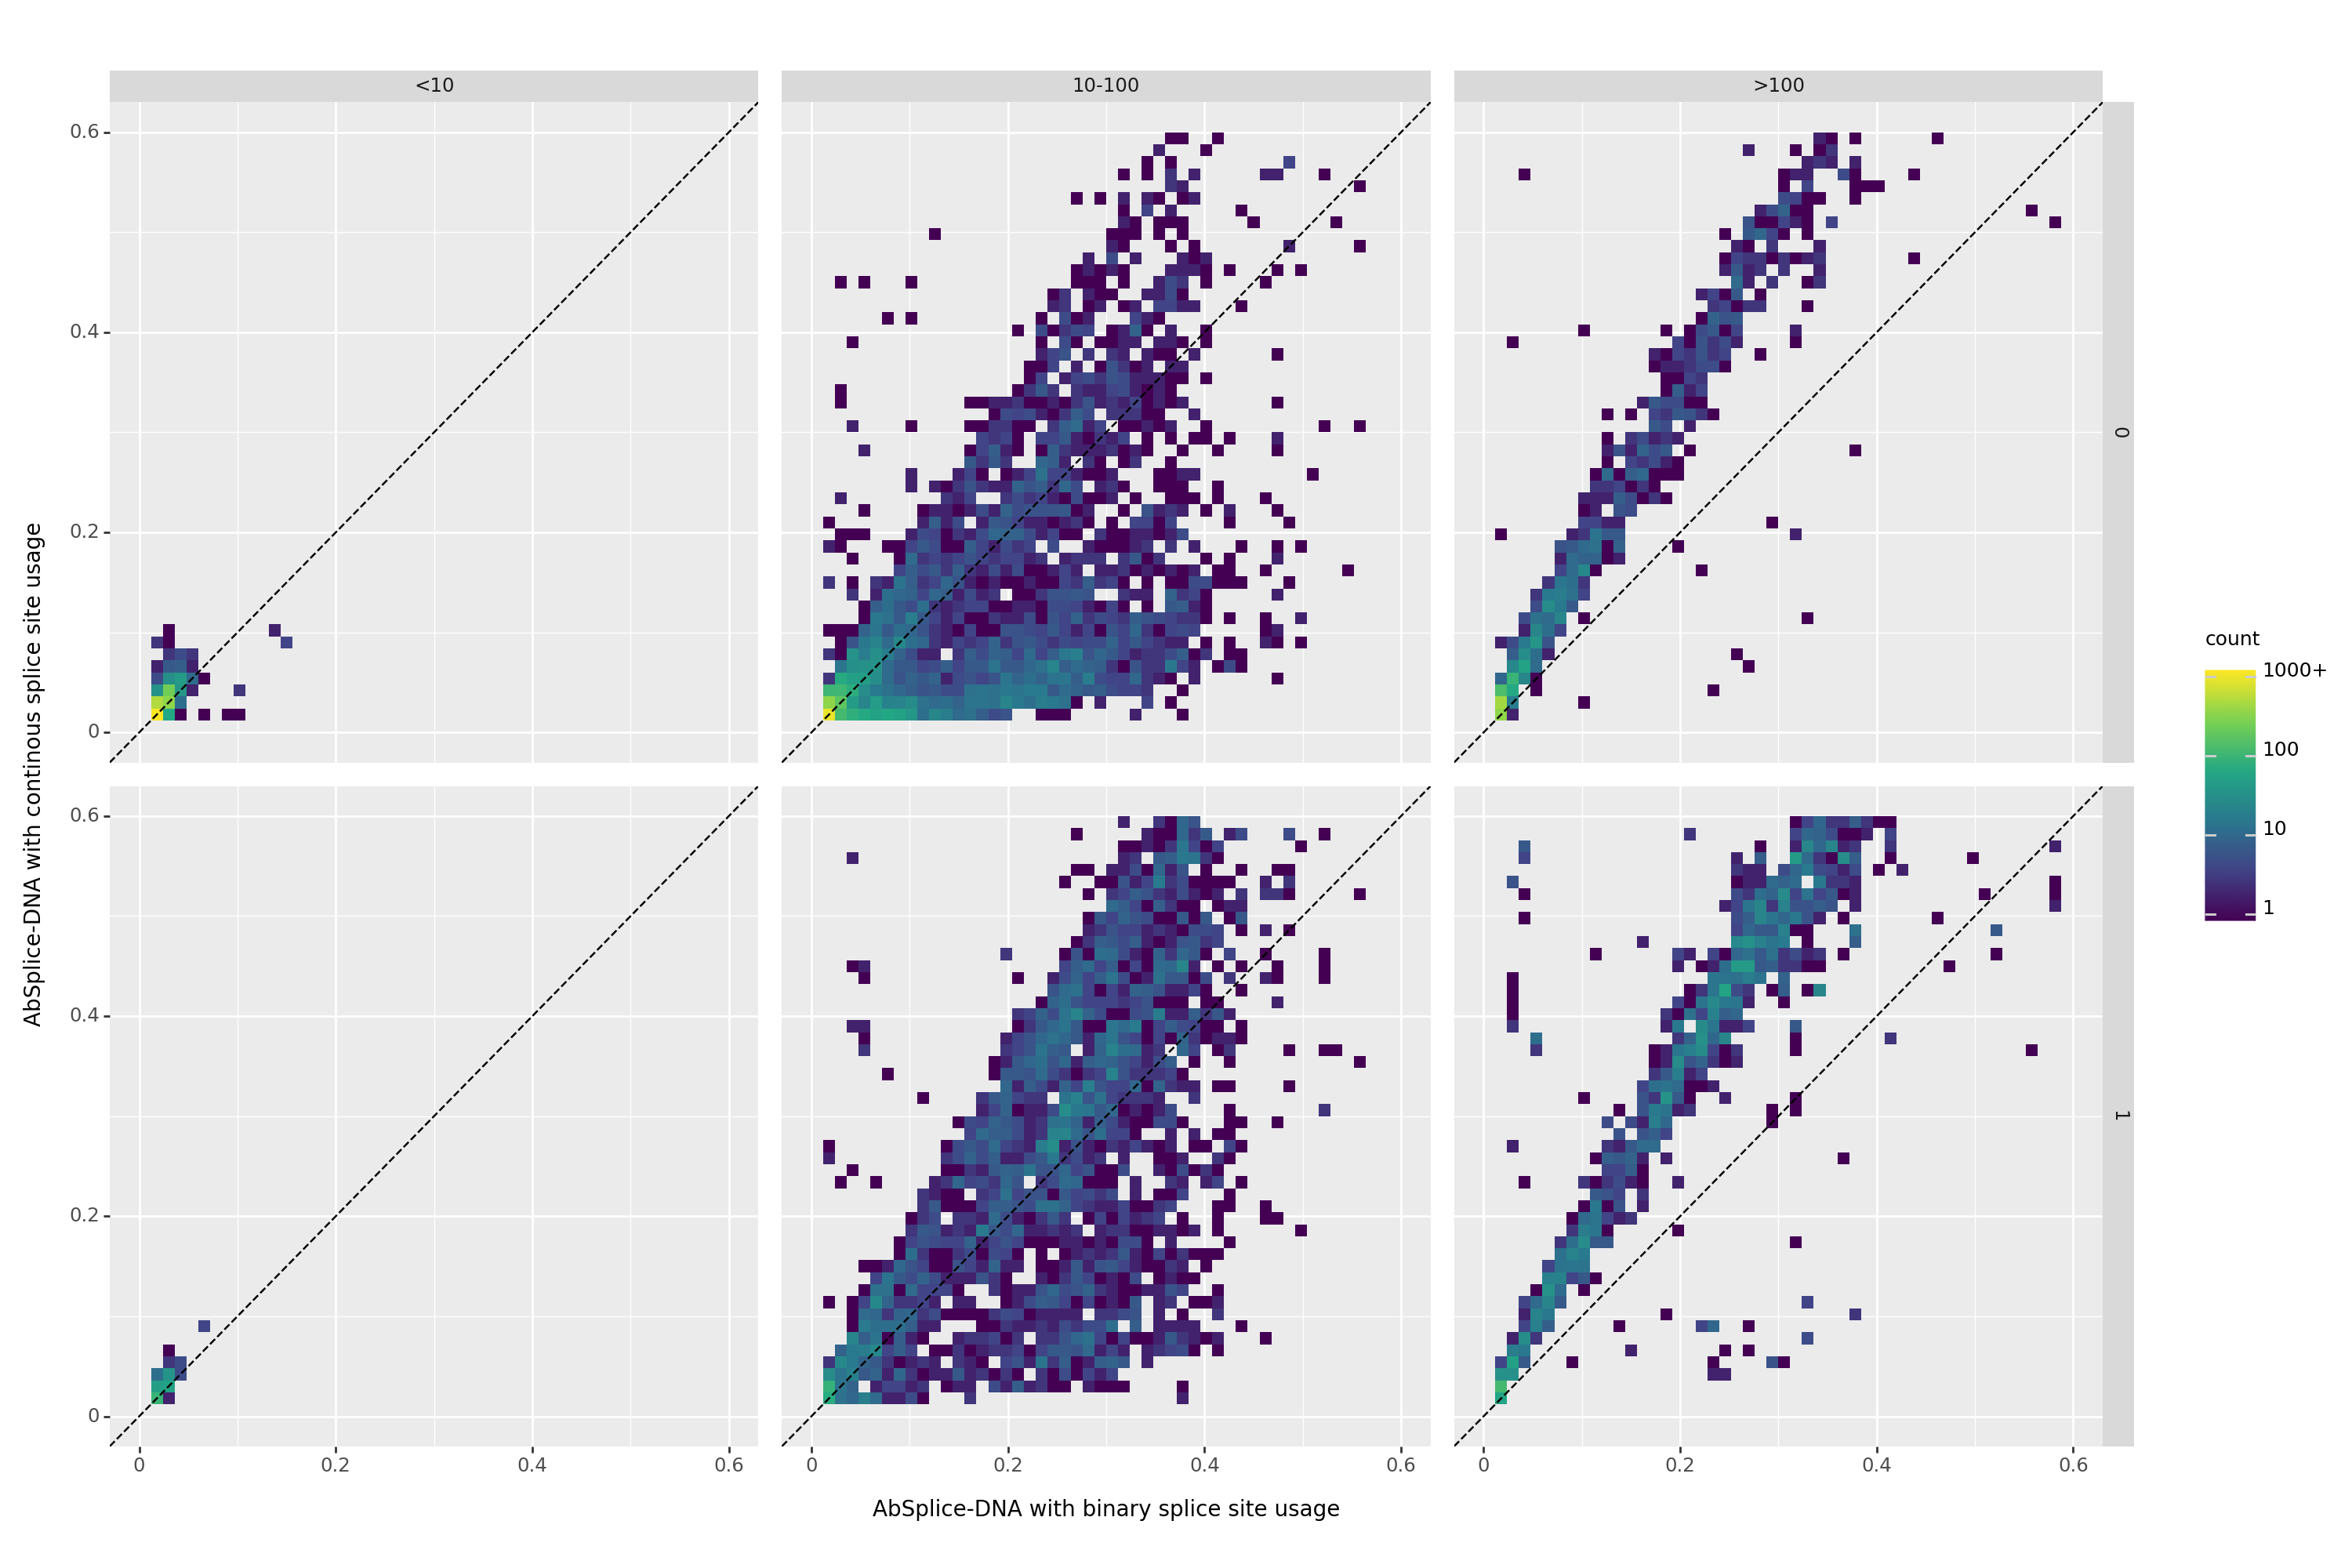

<Figure Size: (1500 x 1000)>

In [87]:
df_sampled['median_n_category'] = pd.cut(df_sampled['median_n'], bins=[-float('inf'), 10, 100, float('inf')], labels=['<10', '10-100', '>100'])
df_plot = df_sampled.copy()

# Set figure size
scale = 1
p9.options.figure_size = (15 * scale, 10 * scale)

# Define axis limits
min_val = min(df_plot['AbSplice_binary'].min(), df_plot['AbSplice_continous'].min())
max_val = max(df_plot['AbSplice_binary'].max(), df_plot['AbSplice_continous'].max())
max_val = 0.6  # Adjusted manually

# Set max count value for color mapping
max_count = 1000  # Values above this will be shown in the same color

# Create the plot
p = (
    p9.ggplot(df_plot, p9.aes(
        x='AbSplice_binary', 
        y='AbSplice_continous'
    )) 
    + p9.geom_bin2d(bins=50, raster=True)  # Increase bins for finer granularity
    + p9.scale_fill_gradientn(
        colors=[cm.viridis(i) for i in np.linspace(0, 1, 6)],  # Full Viridis range
        trans="log10",
        limits=(1, max_count),  # Clip color scale at max_count
        breaks=[1, 10, 100, 1000],  # Adjust color scale breaks
        labels=["1", "10", "100", "1000+"],  # Readable labels
    )
    + p9.geom_abline(slope=1, intercept=0, linetype="dashed", color="black")  # Diagonal reference line
    + p9.facet_grid('y_test ~ median_n_category')  # Facet by outlier category and median_n_category
    + p9.lims(x=(min_val, max_val), y=(min_val, max_val))  # Ensure equal scaling
    + p9.labs(x="AbSplice-DNA with binary splice site usage", y="AbSplice-DNA with continous splice site usage")  # Custom axis labels
    + p9.theme(
        legend_text=p9.element_text(size=9),
        legend_title=p9.element_text(size=9),
        axis_title=p9.element_text(size=10)
    )
)

p

In [88]:
df_sampled.to_csv(os.path.join(SAVE_DIR,  'median_n_reranking_absplice_scores.csv'), index=False)

## AbExp performance

In [47]:
df = pd.read_parquet('../data/_TMP2/gtex_v8_old_dna_newAbSpliceBenchmark/predict_folds/subset=dna_only/plots/compare_results.py@13_AbSplice2/performance.tissue.parquet')

In [48]:
chosen_models = [
    'AbSplice',
    'AbSplice2',
    'LOFTEE+CADD+weighted csq.+disp.+AbSplice+Enformer+SV+dups (AbExp)',
    'LOFTEE+CADD+weighted csq.+disp.+AbSplice2+Enformer+SV+dups (AbExp)',
]

In [49]:
model_name_map = {
    'AbSplice': 'AbSplice1',
    'AbSplice2': 'AbSplice2',
    'LOFTEE+CADD+weighted csq.+disp.+AbSplice+Enformer+SV+dups (AbExp)': 'AbExp \n(AbSplice1)',
    'LOFTEE+CADD+weighted csq.+disp.+AbSplice2+Enformer+SV+dups (AbExp)': 'AbExp \n(AbSplice2)',
}

In [50]:
sorted_models = (
    df.groupby('model')['auc'].median()
    .sort_values(ascending=False)
    .index
)

df['model_name'] = pd.Categorical(
    df['model'].map(model_name_map),
    categories=[model_name_map[m] for m in sorted_models if m in model_name_map],
    ordered=True
)

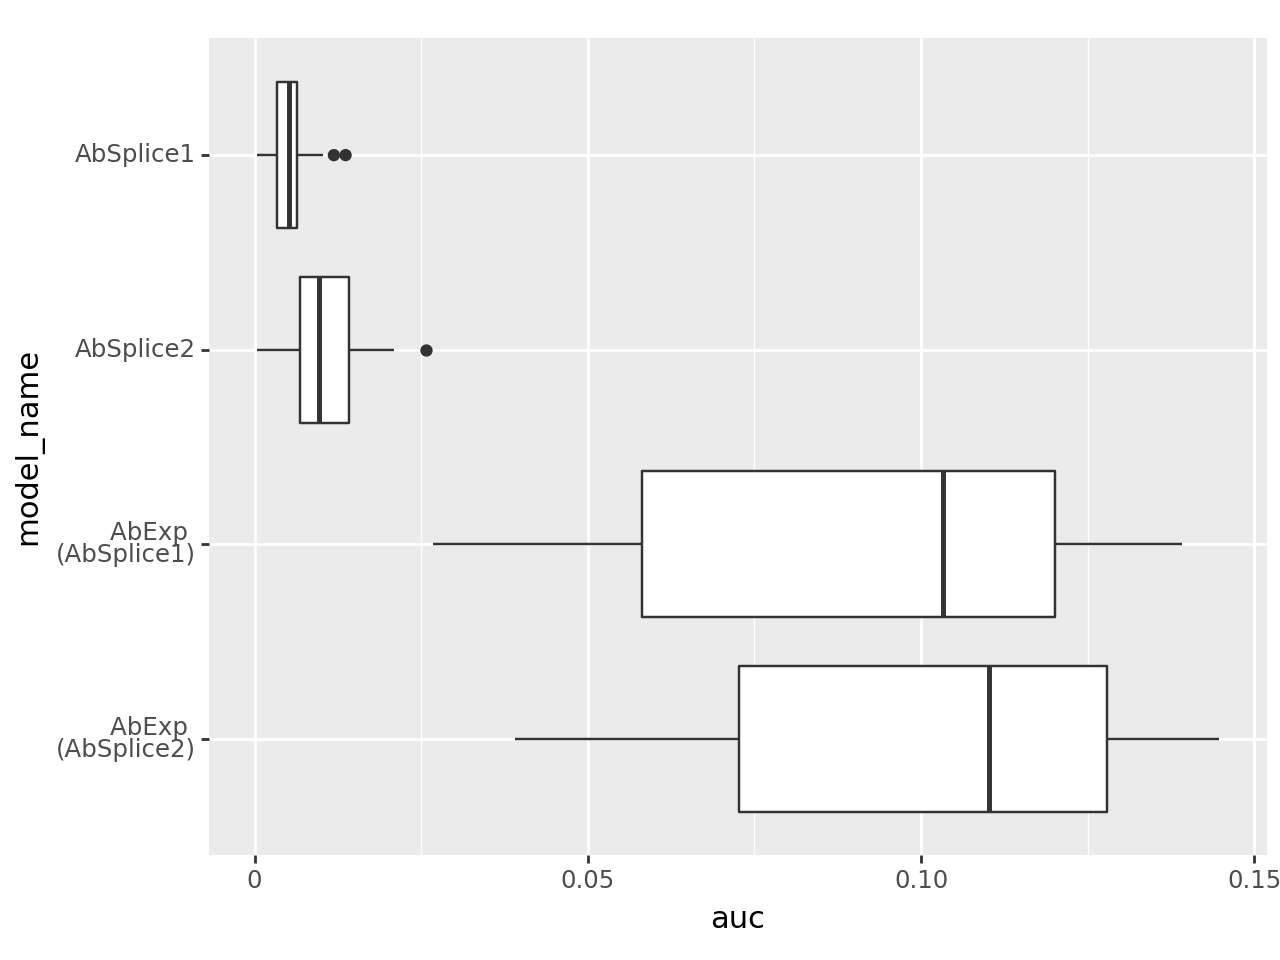

<Figure Size: (640 x 480)>

In [51]:
(
    ggplot(df[df['model'].isin(chosen_models)], aes(y='auc', x='model_name'))
    + geom_boxplot()
    + coord_flip()
)

In [58]:
_df_box = df[['model_name', 'tissue', 'auc']].drop_duplicates().rename(columns={'auc': 'aps'}).set_index('model_name')

In [64]:
_,_ = compare_aps(_df_box, 
            model1='AbSplice2', 
            model2='AbSplice1')

Average precision improvement: 1.936059064481064
Wilcoxon signed-rank test: statistic=353.0000, p-value=6.735e-06


In [67]:
_,_ = compare_aps(_df_box, 
            model1='AbExp \n(AbSplice2)', 
            model2='AbExp \n(AbSplice1)',
            alternative='greater')

Average precision improvement: 1.067746267784874
Wilcoxon signed-rank test: statistic=319.0000, p-value=0.0005658


# Developmental variant

## devAS distribution across LOEUF deciles

In [68]:
df_loeuf = pd.read_parquet('../data/resources/common/loeuf_scores_with_expressed_tissues.parquet').reset_index()

In [69]:
df_loeuf = df_loeuf[
    ~df_loeuf['LOEUF_decile'].isna()
]

In [70]:
df_loeuf['LOEUF_decile'] = df_loeuf['LOEUF_decile'] / 10

In [71]:
df_loeuf['LOEUF_decile'] = df_loeuf['LOEUF_decile'].astype(int) + 1

Supplementary Data 9. Table contains all segments from all species that passed thresholds in at least one organ. The first seven columns give the segment unique ID, Ensembl ID of the genes that host the segment (if available), genome coordinates of the segment and segment type. CE. cassette exon; AA, alternative acceptor site; AD, alternative donor site; RI, retained intron. The next 21 columns provide the developmental patterns. ‘-’, segment did not pass the thresholds in a given organ; ‘n’, segment is not devAS; ‘u’, ‘d’, ‘ud’, ‘du’. denote up, down, up–down and down–up patterns, respectively. The dPSI and Benjamini–Hochberg (BH)-adjusted P values (segments that didn’t pass thresholds are marked by NA) for all seven organs.

In [72]:
sup_09_seg_above_thresh = pd.read_csv('../data/resources/devAbSplice/Supplementary_Data_9.csv')

In [73]:
sup_09_seg_above_thresh = sup_09_seg_above_thresh[
    sup_09_seg_above_thresh['seg.id'].str.contains('hum.')
].drop(columns='Unnamed: 0')

### start 1-based

In [74]:
sup_09_seg_above_thresh['start'] = sup_09_seg_above_thresh['start'] - 1

In [75]:
def convert_strand(strand):
    if strand == -1:
        return '-'
    elif strand == 1:
        return '+'
    else:
        print('missin')
        raise KeyError()

In [76]:
def splice_site_start(df, pos='start'):
    return str(df['Chromosome']) + ':' + str(df[pos]) + ':' + str(df['Strand'])

In [77]:
def get_plot_data(df_devAS):
    df_devAS = df_devAS.rename(columns={
        'chr_id': 'Chromosome',
        'strand': 'Strand'
    })
    df_devAS['Chromosome'] = df_devAS['Chromosome'].apply(lambda df: 'chr' + str(df))
    df_devAS['Strand'] = df_devAS.apply(lambda df: convert_strand(df['Strand']), axis=1)
    
    df_devAS['start_splice_site'] = df_devAS.apply(lambda df: splice_site_start(df, pos='start'), axis=1)
    df_devAS['stop_splice_site'] = df_devAS.apply(lambda df: splice_site_start(df, pos='stop'), axis=1)
    
    df_devAS_all = df_devAS.copy()
    
    df_devAS_all = df_devAS_all[
        ~df_devAS_all['ens_id'].isna()
    ]
    
    df_devAS_all['gene_id'] = df_devAS_all.apply(lambda df: df['ens_id'].split(','), axis=1)
    
    df_devAS_all = df_devAS_all.explode('gene_id')
    
    df_devAS_all['devAS'] = True
    df_devAS_join = df_devAS_all[['gene_id', 'devAS']].drop_duplicates()
    
    df_loeuf_devAS = df_loeuf.set_index('gene_id').join(df_devAS_join.set_index('gene_id')[['devAS']]).reset_index()
    df_loeuf_devAS['devAS'] = df_loeuf_devAS['devAS'].fillna(False)
    df_loeuf_devAS = df_loeuf_devAS[['gene_id', 'LOEUF_decile', 'devAS']].drop_duplicates()

    print(len(set(df_devAS_join['gene_id'])))
    return df_loeuf_devAS

In [78]:
def plot_loeuf_data(df_loeuf_devAS):
    plot = (
        ggplot(df_loeuf_devAS, aes(x='LOEUF_decile', fill='devAS'))
        # + geom_bar(stat="count", color="black", alpha=0.7, position=position_dodge(width=0.8), width=0.6)
        + geom_bar(stat="count", color="black", alpha=0.7, position='dodge', width=0.8)
        + theme_light()
        + labs(
            # title="devAS are enriched for low LOEUF deciles", 
            x="LOEUF decile", 
            y="Number of genes",
            fill='Gene contains devAS'
        )
        + scale_x_continuous(breaks=range(1, 11))
        + scale_fill_manual(values=["#b2182b", "#404040"])  # Custom colors similar to the plot
        + theme(
            axis_title_x=element_text(size=12),
            axis_title_y=element_text(size=12),
            # legend_title='Gene contains devAS',
            legend_position="right"
        )
    )
    print(plot)

In [79]:
def plot_loeuf_data(df_loeuf_devAS, file_path=None, fontsize=12):
    plot = (
        ggplot(df_loeuf_devAS, aes(x='LOEUF_decile', fill='devAS'))
        + geom_bar(stat="count", color="black", alpha=0.7, position='dodge', width=0.8)
        + theme_light()
        + labs(
            x="LOEUF decile", 
            y="Number of genes",
            fill='Gene \ncontains \ndevAS'
        )
        + scale_x_continuous(breaks=range(1, 11))
        + scale_fill_manual(values=["#404040", "#b2182b"])  # Custom colors
        + theme(
            axis_title_x=element_text(size=fontsize),  # Dynamic font size for x-axis title
            axis_title_y=element_text(size=fontsize),  # Dynamic font size for y-axis title
            legend_title=element_text(size=fontsize),  # Dynamic font size for legend title
            legend_text=element_text(size=fontsize - 2),  # Slightly smaller font for legend text
            panel_grid_major=element_blank(),  # Remove major grid lines
            panel_grid_minor=element_blank(),  # Remove minor grid lines
            panel_background=element_blank(),  # Remove panel background
            plot_background=element_blank(),  # Make the plot background transparent
            legend_background=element_blank()  # Transparent legend background
        )
    )
    
    # Save the plot if file_path is provided
    if file_path:
        plot.save(file_path, format='svg', dpi=300, background="transparent", verbose=False)  # Save with 300 DPI
        print(f"Plot saved as {file_path}")
    
    # Print plot to display
    print(plot)

### All tissues

In [80]:
# pattern needs to be everything except 'n' or '-'
pattern_cols = [col for col in sup_09_seg_above_thresh.columns if col.startswith('pattern.')]
# Check for each row if all values in 'pattern.' columns are 'n' or '-'
rows_with_n_or_dash = sup_09_seg_above_thresh[pattern_cols].apply(lambda x: all(val in ['n', '-'] for val in x), axis=1)
df_devAS = sup_09_seg_above_thresh[~rows_with_n_or_dash]

In [81]:
df_devAS.shape

(27954, 28)

In [82]:
df_loeuf_devAS = get_plot_data(df_devAS)

8921


In [109]:
df_loeuf_devAS.to_csv(os.path.join(SAVE_DIR, 'LOUEF_devAS_distribution.csv'), index=False)

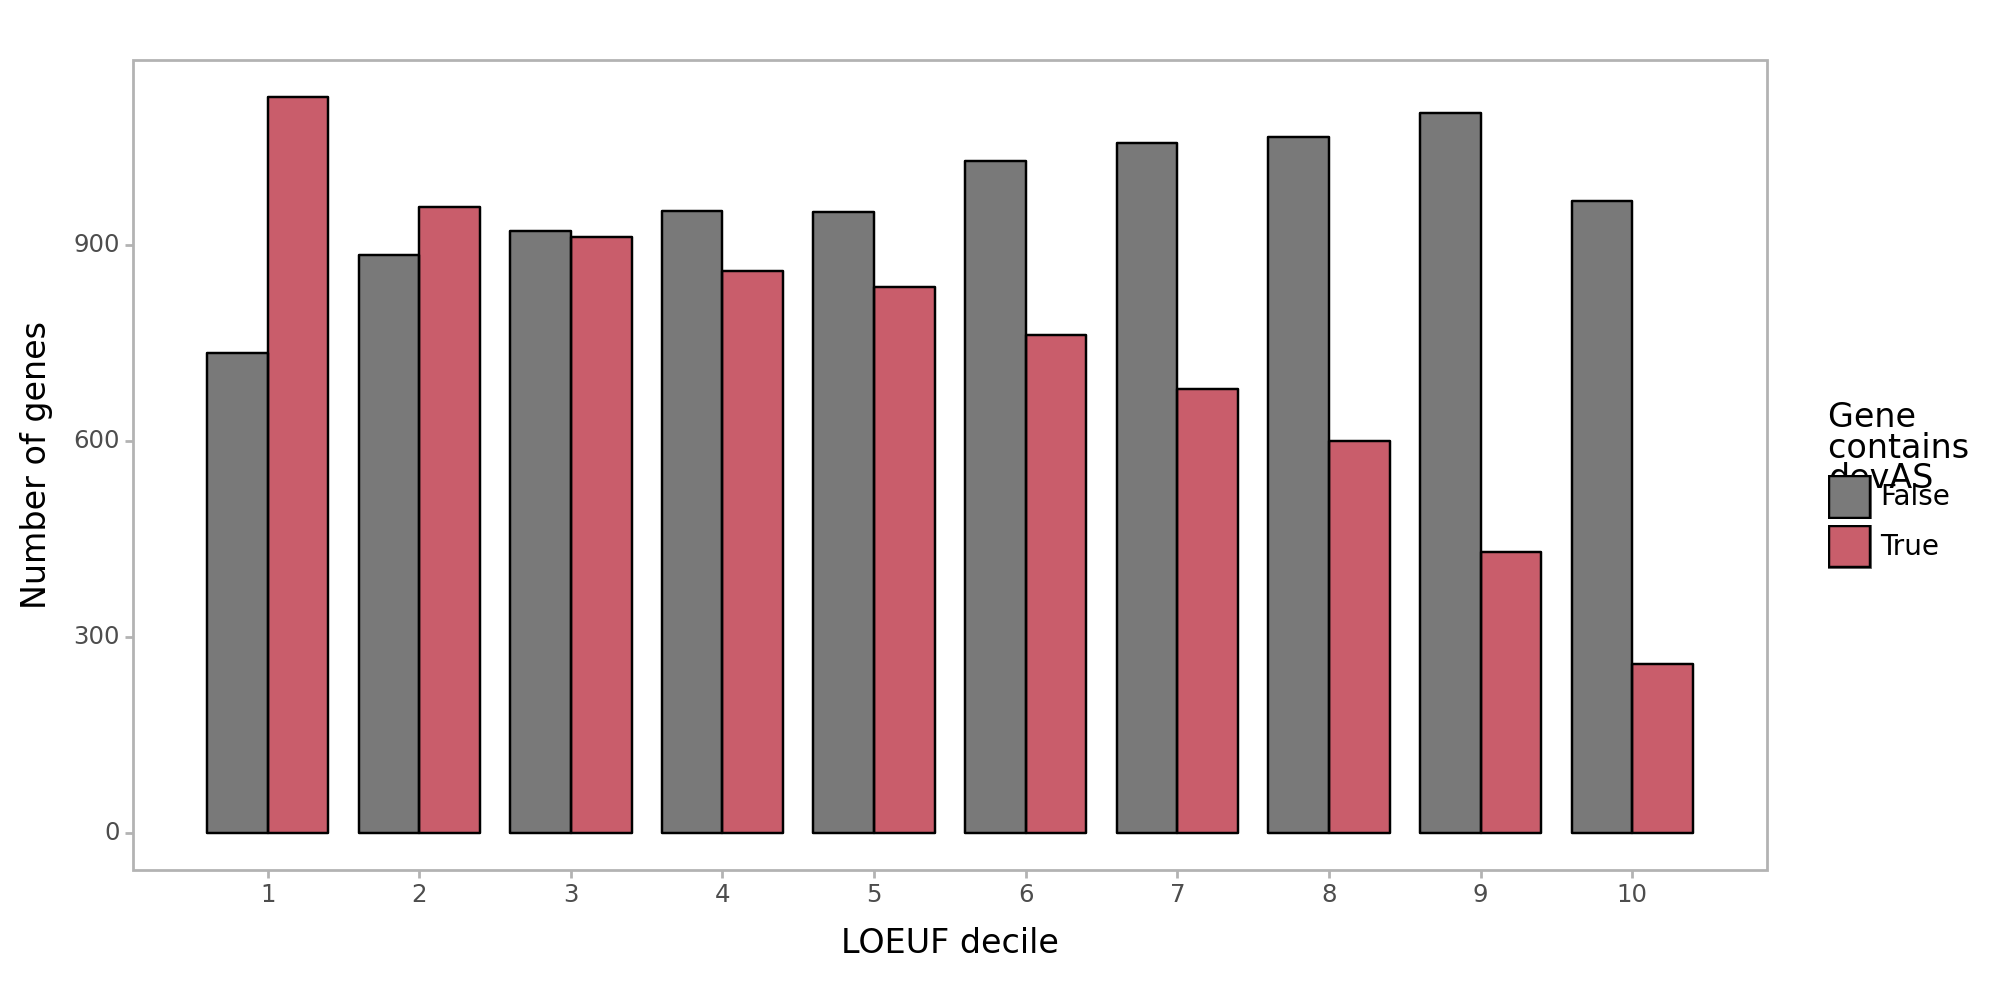

In [133]:
plot_loeuf_data(
    df_loeuf_devAS
)

In [119]:
from scipy.stats import fisher_exact

# Group deciles
def group_lof_tolerance(decile):
    if decile in [1, 2, 3]:
        return 'intolerant'
    elif decile in [8, 9, 10]:
        return 'tolerant'
    else:
        return 'middle'
        
def LOEUF_decile_stat_test(df, col='devAS'):
    df['lof_group'] = df['LOEUF_decile'].apply(group_lof_tolerance)
    
    # Filter to only "intolerant" vs "tolerant"
    df_filtered = df[df['lof_group'].isin(['intolerant', 'tolerant'])]
    
    # Create contingency table
    contingency = pd.crosstab(df_filtered['lof_group'], df_filtered[col])
    
    # Reorder to ensure format: [[intolerant True, intolerant False], [tolerant True, tolerant False]]
    table = [
        [contingency.loc['intolerant', True], contingency.loc['intolerant', False]],
        [contingency.loc['tolerant', True], contingency.loc['tolerant', False]]
    ]
    
    # Fisher's exact test
    oddsratio, p_value = fisher_exact(table)

    print(contingency)
    print(f"Odds ratio: {oddsratio:.2f}")
    print(f"P-value: {p_value:.2e}")

In [120]:
LOEUF_decile_stat_test(df_loeuf_devAS, col='devAS')

devAS       False  True 
lof_group               
intolerant   2541   2998
tolerant     3134   1289
Odds ratio: 2.87
P-value: 1.52e-140


## Predictions higher in dev than GTEx

In [91]:
tissues = [
    'brain',
    'cerebellum',
    'heart',
    'testis',
    'ovary',
    'liver',
    'kidney',
]

### per variant

In [92]:
high_cutoff = 0.2
low_cutoff = 0.05
model_name = 'model_27'
delta_t = 1

early_col = 'max_early'
late_col = 'max_GTEx'
# late_col = 'max_late'

df_comb = []
for chrom in tqdm([f'chr{x}' for x in range(1,23)]):
    _df = pd.read_parquet(os.path.join(
            '../../../AbSplice_analysis/workflow/data/results/devAbSplice/',
            f'splicing_predictions/max_preds/absplice2_NEW/{model_name}/max_preds_dev_GTEx/delta_t={delta_t}/{chrom}_AbSplice_DNA.parquet'))
    df_comb.append(_df)
df_comb = pd.concat(df_comb)

df_num_vars = []
tissue_vars = {}
for tissue in tissues:
    _df_tissue = df_comb[
        (df_comb[f'{tissue}_{early_col}'] >= high_cutoff)
        & (df_comb[f'{tissue}_{late_col}'] < low_cutoff)
    ]
    _df_tissue['variant'] = _df_tissue.progress_apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    df_num_vars.append(pd.DataFrame({
        'tissue': tissue,
        'num_vars': len(set(_df_tissue.set_index(['variant', 'gene_id']).index))
    }, index=[0]))
    tissue_vars[tissue] = sorted(set(_df_tissue.set_index(['variant', 'gene_id']).index))

if late_col == 'max_GTEx':
    _df_all_tissues = df_comb[
        (df_comb[early_col] >= high_cutoff)
        & (df_comb['max_all_GTEx'] < low_cutoff)
    ]
else:
    _df_all_tissues = df_comb[
        (df_comb[early_col] >= high_cutoff)
        & (df_comb[late_col] < low_cutoff)
    ]
_df_all_tissues['variant'] = _df_all_tissues.progress_apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
df_num_vars.append(pd.DataFrame({
    'tissue': 'all_tissues',
    'num_vars': len(set(_df_all_tissues.set_index(['variant', 'gene_id']).index))
}, index=[0]))
df_num_vars = pd.concat(df_num_vars)
df_num_vars = df_num_vars.sort_values(by='num_vars', ascending=False)

100%|██████████| 1811/1811 [00:00<00:00, 82132.77it/s]


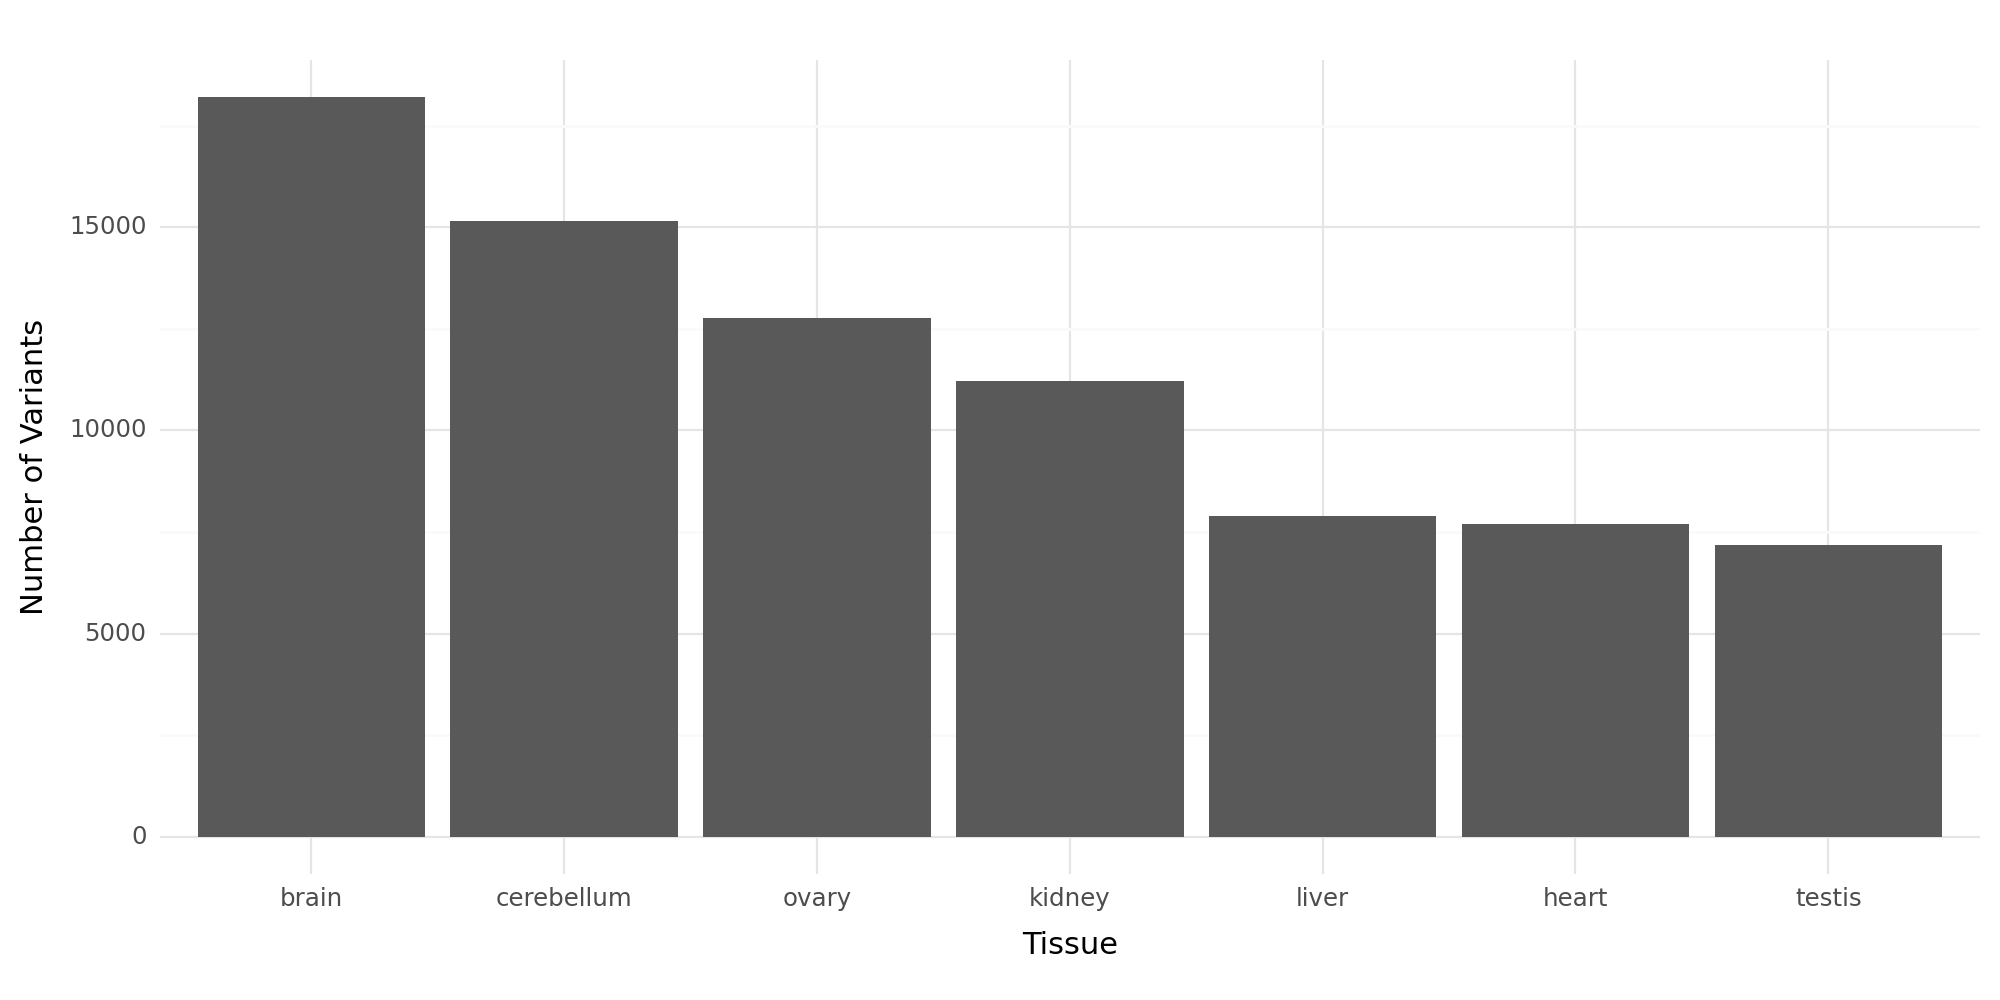

<Figure Size: (1000 x 500)>

In [134]:
df_num_vars['tissue'] = pd.Categorical(df_num_vars['tissue'], categories=df_num_vars.sort_values('num_vars', ascending=False)['tissue'], ordered=True)

(
    ggplot(df_num_vars[df_num_vars['tissue'] != 'all_tissues'], aes(x='tissue', y='num_vars')) +
    geom_bar(stat='identity') +
    labs(x='Tissue', y='Number of Variants') +
    theme_minimal()
)

In [114]:
df_num_vars.to_csv(os.path.join(SAVE_DIR,  'number_of_variants_high_impact_early_no_impact_adult.csv'), index=False)

In [98]:
df_stats = []
for tissue in tissues:
    df_stats.append(pd.DataFrame(tissue_vars[tissue]).rename(columns={0:'variant', 1: 'gene_id'}))
df_stats = pd.concat(df_stats)

In [101]:
df_stats = df_stats.drop_duplicates()

In [103]:
df_stats['dev_var'] = True

In [106]:
df_dev_var_genes = df_stats[['gene_id', 'dev_var']].drop_duplicates()

In [109]:
df_loeuf_devAS_vars = df_loeuf_devAS.set_index('gene_id').join(df_dev_var_genes.set_index('gene_id')).reset_index()

In [111]:
df_loeuf_devAS_vars = df_loeuf_devAS_vars.fillna(False)

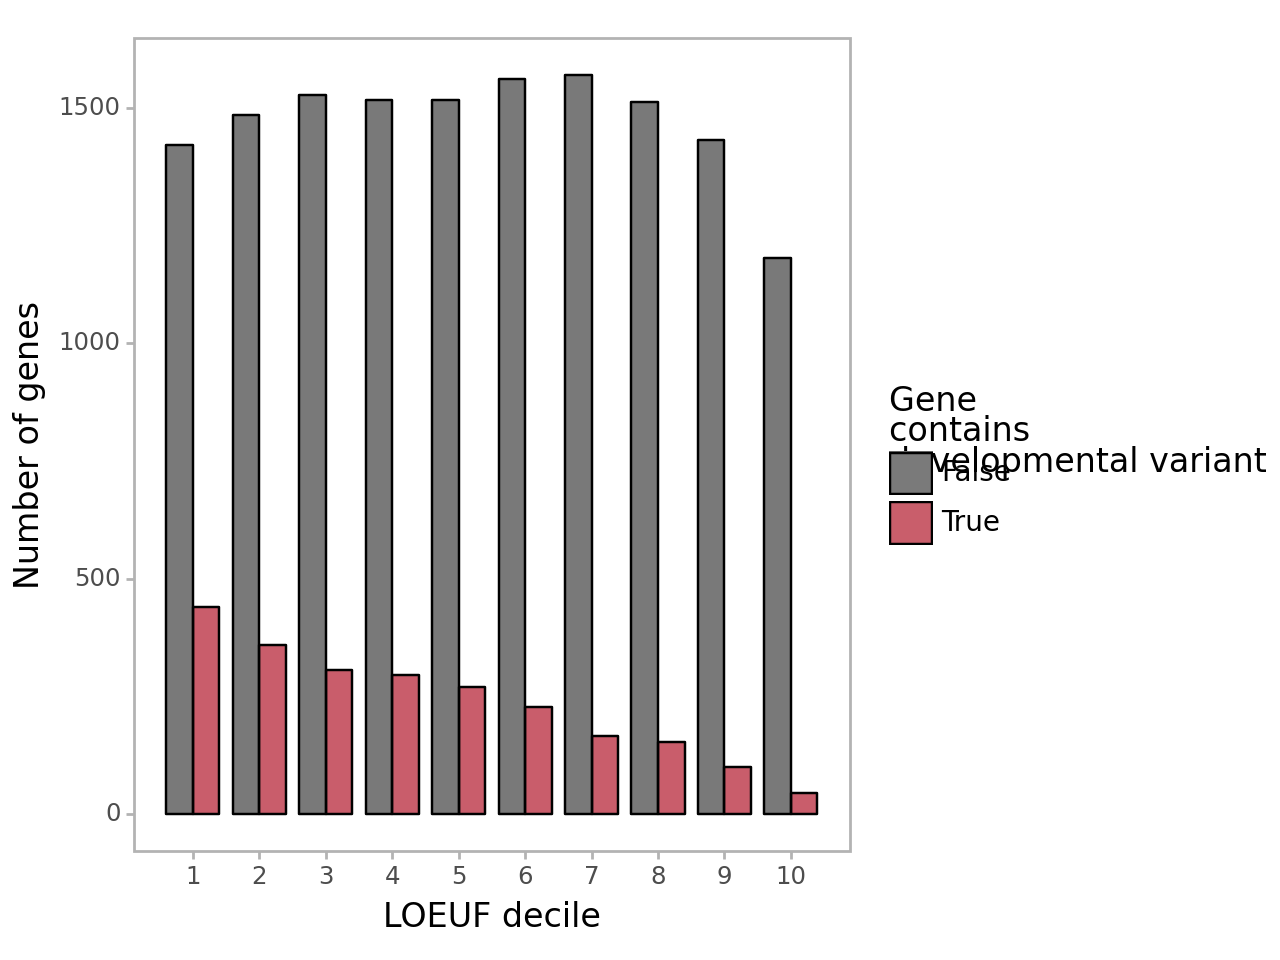

<Figure Size: (640 x 480)>

In [442]:
fontsize=12
(
    ggplot(df_loeuf_devAS_vars, aes(x='LOEUF_decile', fill='dev_var'))
    + geom_bar(stat="count", color="black", alpha=0.7, position='dodge', width=0.8)
    + theme_light()
    + labs(
        x="LOEUF decile", 
        y="Number of genes",
        fill='Gene \ncontains \ndevelopmental variant'
    )
    + scale_x_continuous(breaks=range(1, 11))
    + scale_fill_manual(values=["#404040", "#b2182b"])  # Custom colors
    + theme(
        axis_title_x=element_text(size=fontsize),  # Dynamic font size for x-axis title
        axis_title_y=element_text(size=fontsize),  # Dynamic font size for y-axis title
        legend_title=element_text(size=fontsize),  # Dynamic font size for legend title
        legend_text=element_text(size=fontsize - 2),  # Slightly smaller font for legend text
        panel_grid_major=element_blank(),  # Remove major grid lines
        panel_grid_minor=element_blank(),  # Remove minor grid lines
        panel_background=element_blank(),  # Remove panel background
        plot_background=element_blank(),  # Make the plot background transparent
        legend_background=element_blank()  # Transparent legend background
    )
)

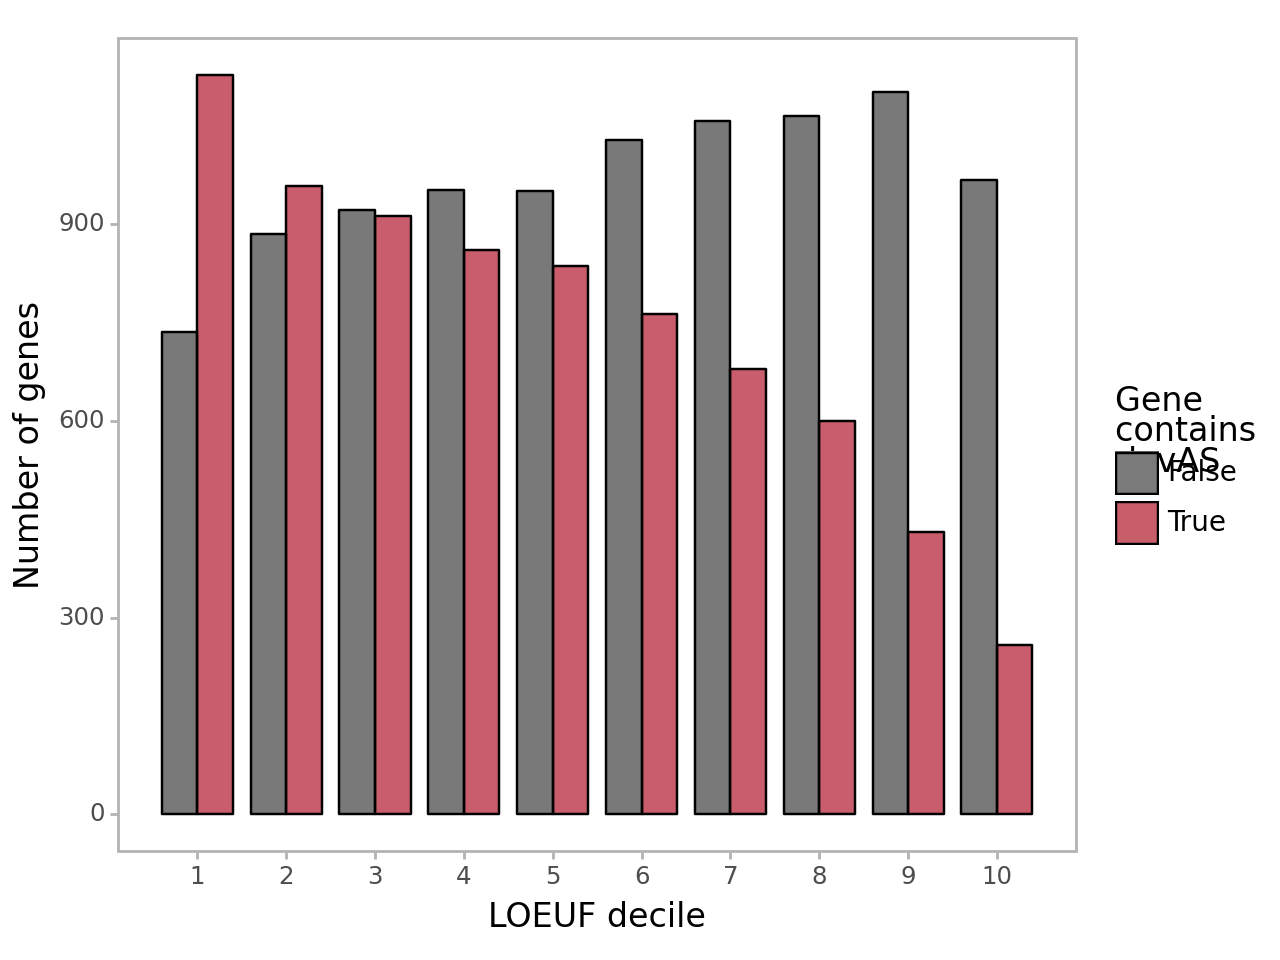

<Figure Size: (640 x 480)>

In [443]:
fontsize=12
(
    ggplot(df_loeuf_devAS_vars, aes(x='LOEUF_decile', fill='devAS'))
    + geom_bar(stat="count", color="black", alpha=0.7, position='dodge', width=0.8)
    + theme_light()
    + labs(
        x="LOEUF decile", 
        y="Number of genes",
        fill='Gene \ncontains \ndevAS'
    )
    + scale_x_continuous(breaks=range(1, 11))
    + scale_fill_manual(values=["#404040", "#b2182b"])  # Custom colors
    + theme(
        axis_title_x=element_text(size=fontsize),  # Dynamic font size for x-axis title
        axis_title_y=element_text(size=fontsize),  # Dynamic font size for y-axis title
        legend_title=element_text(size=fontsize),  # Dynamic font size for legend title
        legend_text=element_text(size=fontsize - 2),  # Slightly smaller font for legend text
        panel_grid_major=element_blank(),  # Remove major grid lines
        panel_grid_minor=element_blank(),  # Remove minor grid lines
        panel_background=element_blank(),  # Remove panel background
        plot_background=element_blank(),  # Make the plot background transparent
        legend_background=element_blank()  # Transparent legend background
    )
)

In [445]:
df_loeuf_devAS_vars.to_csv(os.path.join(SAVE_DIR, 'LOUEF_devAS_distribution.csv'), index=False)

In [121]:
LOEUF_decile_stat_test(df_loeuf_devAS, col='devAS')

devAS       False  True 
lof_group               
intolerant   2541   2998
tolerant     3134   1289
Odds ratio: 2.87
P-value: 1.52e-140


In [123]:
LOEUF_decile_stat_test(df_loeuf_devAS_vars, col='dev_var')

dev_var     False  True 
lof_group               
intolerant   4432   1107
tolerant     4125    298
Odds ratio: 3.46
P-value: 8.11e-85


In [130]:
df = df_loeuf_devAS_vars.copy()
# col = 'devAS'
col = 'dev_var'

# Prepare results
results = []
for decile in range(1, 11):
    df_dec = df[df['LOEUF_decile'] == decile]
    df_other = df[df['LOEUF_decile'] != decile]

    a = df_dec[col].sum()               # devAS in this decile
    b = len(df_dec) - a                     # no devAS in this decile
    c = df_other[col].sum()             # devAS in other deciles
    d = len(df_other) - c                   # no devAS in other deciles

    table = [[a, b], [c, d]]
    or_val, p = fisher_exact(table)

    results.append({'LOEUF_decile': decile, 'odds_ratio': or_val, 'p_value': p})

df_or = pd.DataFrame(results)
df_or

LOEUF_decile  odds_ratio       p_value
0             1    2.144201  5.104307e-34
1             2    1.595522  1.268991e-12
2             3    1.288307  1.967344e-04
3             4    1.239829  1.961705e-03
4             5    1.122049  1.032875e-01
5             6    0.902761  1.809107e-01
6             7    0.636590  2.339827e-08
7             8    0.603988  1.620614e-09
8             9    0.409533  4.342757e-21
9            10    0.222283  1.061264e-34

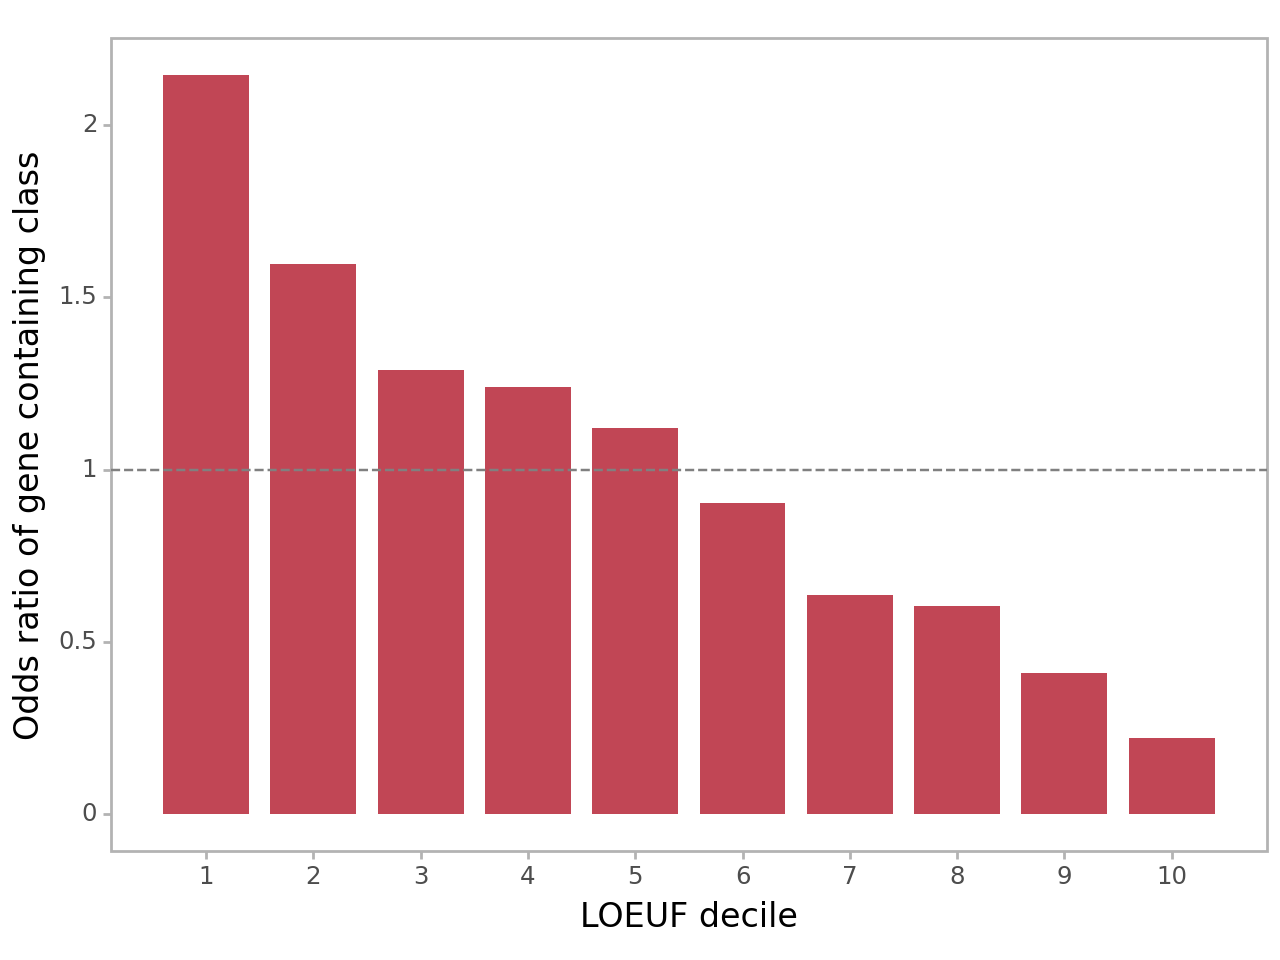

<Figure Size: (640 x 480)>

In [446]:
from plotnine import *

fontsize = 12
(
    ggplot(df_or, aes(x='LOEUF_decile', y='odds_ratio'))
    + geom_bar(stat='identity', fill='#b2182b', alpha=0.8, width=0.8)
    + geom_hline(yintercept=1, linetype='dashed', color='gray')
    + labs(
        x='LOEUF decile',
        y=f'Odds ratio of gene containing {col}'
    )
    + scale_x_continuous(breaks=range(1, 11))
    + theme_light()
    + theme(
        axis_title_x=element_text(size=fontsize),
        axis_title_y=element_text(size=fontsize),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        panel_background=element_blank(),
        plot_background=element_blank()
    )
)


# GEL cases

In [1]:
import pandas as pd
import os
from tqdm import tqdm
tqdm.pandas()

In [44]:
timepoint_dict = {
    "t1": "4 wpc",
    "t2": "5 wpc",
    "t3": "6 wpc",
    "t4": "7 wpc",
    "t5": "8 wpc",
    "t6": "9–11 wpc",
    "t7": "12 wpc",
    "t8": "13 wpc",
    "t9": "16 wpc",
    "t10": "18–19 wpc",
    "t11": "20 wpc",
    "t12": "Newborn–Toddler",
    "t13": "School–Young Adult",
    "t14": "Young Mid Age",
    "t15": "Older Mid–Senior",
    "tgtex": "GTEx"
}

tp_description_order = [
    "4 wpc", "5 wpc", "6 wpc", "7 wpc", "8 wpc",
    "9–11 wpc", "12 wpc", "13 wpc", "16 wpc",
    "18–19 wpc", "20 wpc", "Newborn–Toddler",
    "School–Young Adult", "Young Mid Age", "Older Mid–Senior", "GTEx"
]

In [45]:
def annotate_var_compressed(df):
    df['chrom'] = df['variant'].apply(lambda x: x.split(':')[0])
    df['pos'] = df['variant'].apply(lambda x: x.split(':')[1])
    df['pos'] = df['pos'].astype(int)
    df['ref'] = df['variant'].apply(lambda x: x.split(':')[2].split('>')[0])
    df['alt'] = df['variant'].apply(lambda x: x.split(':')[2].split('>')[1])
    df['end'] = df['pos']
    df['start'] = df['end'] - 1
    df = df.drop(columns=['variant', 'pos'])
    return df

def get_abs_max_rows(df, groupby, max_col, dropna=True):
    return df.reset_index() \
        .sort_values(by=max_col, key=abs, ascending=False) \
        .drop_duplicates(subset=groupby) \
        .set_index(groupby)

def annotate_tps(df):
    df['tp'] = df['tissue'].apply(lambda x: x.split('_')[2])
    df['tp_description'] = df['tp'].map(timepoint_dict)
    df['tp_description'] = pd.Categorical(df['tp_description'], categories=tp_description_order, ordered=True)
    return df

## Load models

In [46]:
model_path = absplice2_model_path
with open(model_path, 'rb') as f:
    model_27 = pickle.load(f)

In [47]:
features_model_27 = [
    'delta_logit_psi',
    'delta_psi',
    'gain_score',
    'loss_score',
    'median_n',
    'median_n_pangolin']

In [48]:
tissues_gtex = [
    'Adipose_Subcutaneous',
    'Adipose_Visceral_Omentum',
    'Adrenal_Gland',
    'Artery_Aorta',
    'Artery_Coronary',
    'Artery_Tibial',
    'Brain_Amygdala',
    'Brain_Anterior_cingulate_cortex_BA24',
    'Brain_Caudate_basal_ganglia',
    'Brain_Cerebellar_Hemisphere',
    'Brain_Cerebellum',
    'Brain_Cortex',
    'Brain_Frontal_Cortex_BA9',
    'Brain_Hippocampus',
    'Brain_Hypothalamus',
    'Brain_Nucleus_accumbens_basal_ganglia',
    'Brain_Putamen_basal_ganglia',
    'Brain_Spinal_cord_cervical_c_1',
    'Brain_Substantia_nigra',
    'Breast_Mammary_Tissue',
    'Cells_Cultured_fibroblasts',
    'Cells_EBV_transformed_lymphocytes',
    'Colon_Sigmoid',
    'Colon_Transverse',
    'Esophagus_Gastroesophageal_Junction',
    'Esophagus_Mucosa',
    'Esophagus_Muscularis',
    'Heart_Atrial_Appendage',
    'Heart_Left_Ventricle',
    'Kidney_Cortex',
    'Liver',
    'Lung',
    'Minor_Salivary_Gland',
    'Muscle_Skeletal',
    'Nerve_Tibial',
    'Ovary',
    'Pancreas',
    'Pituitary',
    'Prostate',
    'Skin_Not_Sun_Exposed_Suprapubic',
    'Skin_Sun_Exposed_Lower_leg',
    'Small_Intestine_Terminal_Ileum',
    'Spleen',
    'Stomach',
    'Testis',
    'Thyroid',
    'Uterus',
    'Vagina',
    'Whole_Blood',
]

In [49]:
def predict_variant_model_27(pangolin_splicemap, mmsplice_splicemap, variant, all_junctions=True, clip_pangolin=False):
    df = pd.read_parquet(pangolin_splicemap)

    if clip_pangolin:
        df['gain_score'] = df['gain_score'].clip(upper=0.7)
    
    df_mmsplice_splicemap = pd.read_parquet(mmsplice_splicemap)
    
    df = df[
        (df['end'] == int(variant.split(':')[1]))
        & (df['alt'] == variant.split(':')[2].split('>')[1])
    ]
    df_mmsplice_splicemap = df_mmsplice_splicemap[
        df_mmsplice_splicemap['variant'] == variant
    ]

    df['variant'] = df.apply(lambda df: f"{df['chrom']}:{df['end']}:{df['ref']}>{df['alt']}", axis=1)

    # print('compressing variant annotation')
    if 'variant' in df.columns:
        for col in ['chrom', 'start', 'end', 'ref', 'alt']:
            if col in df.columns:
                # print(col)
                df = df.drop(columns=col)
        df = annotate_var_compressed(df)
    # df = optimize_dataframe(df)
    if df_mmsplice_splicemap.shape[0] > 0:
        if 'variant' in df_mmsplice_splicemap.columns:
            for col in ['chrom', 'start', 'end', 'ref', 'alt']:
                if col in df_mmsplice_splicemap.columns:
                    df_mmsplice_splicemap = df_mmsplice_splicemap.drop(col)
            df_mmsplice_splicemap = annotate_var_compressed(df_mmsplice_splicemap)
        # df_mmsplice_splicemap = optimize_dataframe(df_mmsplice_splicemap)
        
    if df_mmsplice_splicemap.empty:
        required_cols = ['chrom', 'start', 'end', 'ref', 'alt', 'gene_id', 'tissue', 'junction', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_k', 'ref_psi']
        df_mmsplice_splicemap = pd.DataFrame(columns=required_cols)
    else:
        pass
        # df_mmsplice_splicemap = optimize_dataframe(df_mmsplice_splicemap)  # Add this
        
        if 'junction' not in df_mmsplice_splicemap.columns:
            df_mmsplice_splicemap['junction'] = df_mmsplice_splicemap.apply(lambda df: f"{df['Chromosome']}:{df['junction_start']}-{df['junction_end']}:{df['junction_strand']}", axis=1)
    
    join_index = ['chrom', 'start', 'end', 'ref', 'alt', 'gene_id', 'tissue']
    df = df.drop_duplicates()
    df_mmsplice_splicemap = df_mmsplice_splicemap.drop_duplicates()
    
    df = df.set_index(join_index).join(
            df_mmsplice_splicemap.set_index(join_index), how='outer'
        ).reset_index()
    
    # print(df.columns)
    if 'splice_site_is_expressed' not in df.columns:
        df['splice_site_is_expressed'] = (df['median_n'] > 10).astype(int)

    for col in sorted(set(features_model_27)):
        df[col] = df[col].fillna(0)

    df['model_27'] = model_27.predict_proba(df[features_model_27])[:, 1]
    return df

In [53]:
import pandas as pd
import itertools

def fill_missing_with_dummy_score(df, dummy_score):
    # 1. Get unique values of each component
    unique_variants = df[['chrom', 'start', 'end', 'ref', 'alt']].drop_duplicates()
    unique_junctions = df['junction'].unique()
    unique_tissues = df['tissue'].unique()
    
    # 2. Create full cartesian product of all combinations
    all_combinations = (
        unique_variants
        .assign(key=1)
        .merge(pd.DataFrame({'junction': unique_junctions, 'key': 1}), on='key')
        .merge(pd.DataFrame({'tissue': unique_tissues, 'key': 1}), on='key')
        .drop(columns='key')
    )
    
    # 3. Merge with original df
    merged = all_combinations.merge(df, on=['chrom', 'start', 'end', 'ref', 'alt', 'junction', 'tissue'], how='left')
    
    # 4. Fill missing model_27 with dummy_score where needed
    # dummy_score = -1.0  # replace with your actual dummy score
    merged['model_27'] = merged['model_27'].fillna(dummy_score)
    merged = annotate_tps(merged)
    # Optional: drop rows where model_27 was already present if you want **only the added ones**
    # added_rows = merged[merged['model_22'].isna()]
    return merged

In [65]:
def plot_for_tissue(variant, delta_t, tissue):
    chrom = variant.split(':')[0]

    timepoints = [f't{x}' for x in range(1,16)]
    
    splicemap_5_dev = [os.path.join(
            DATA_DIR, 'devAbSplice/junction_annotation/splicemap/splicemap_tissue_time/',
            f'delta_t={delta_t}/splicemap_tissue={tissue}_timepoint={timepoint}_psi5.csv.gz') for timepoint in timepoints]
    
    splicemap_3_dev = [os.path.join(
            DATA_DIR, 'devAbSplice/junction_annotation/splicemap/splicemap_tissue_time/',
            f'delta_t={delta_t}/splicemap_tissue={tissue}_timepoint={timepoint}_psi3.csv.gz') for timepoint in timepoints]
        
    pangolin_splicemap_dev = os.path.join(
            DATA_DIR, 'devAbSplice/',
            f'splicing_predictions/raw_pred/pangolin_splicemaps_NEW/devSpliceMaps/delta_t={delta_t}/{chrom}_AbSplice_DNA_tissue={tissue}.parquet')
    
    mmsplice_splicemap_dev = os.path.join(
            DATA_DIR, 'devAbSplice/',
            f'splicing_predictions/raw_pred/mmsplice_splicemap/devSpliceMaps/delta_t={delta_t}/{chrom}_MMSplice_SpliceMap_tissue={tissue}.parquet')
    
    mmsplice_splicemap_gtex = f'{DATA_DIR}devAbSplice/splicing_predictions/raw_pred/mmsplice_splicemap/GTExSpliceMaps/{chrom}_MMSplice_SpliceMap_tissue={tissue}.parquet'
    pangolin_splicemap_gtex = os.path.join(
            DATA_DIR, 'devAbSplice/',
            f'splicing_predictions/raw_pred/pangolin_splicemaps_NEW/GTExSpliceMaps/{chrom}_AbSplice_DNA_tissue={tissue}.parquet')
    
    x = [f'{DATA_DIR}splicemap/hg19/{tissue_gtex}_splicemap_psi5.csv.gz' for tissue_gtex in tissues_gtex]
    splicemap_3_gtex = [f'{DATA_DIR}splicemap/hg19/{tissue_gtex}_splicemap_psi3.csv.gz' for tissue_gtex in tissues_gtex]


    df_model27_dev = predict_variant_model_27(pangolin_splicemap_dev, mmsplice_splicemap_dev, variant, all_junctions=False, clip_pangolin=True)
    df_model27_dev_max = get_abs_max_rows(df_model27_dev, ['chrom', 'start', 'end', 'ref', 'alt', 'gene_id', 'tissue', 'junction'], 'model_27').reset_index()
    tissue_order = [f'human_{tissue}_t{x}' for x in range(1,16)]
    df_model27_dev_max['tissue'] = pd.Categorical(df_model27_dev_max['tissue'], categories=tissue_order, ordered=True)
    df_model27_dev_max = df_model27_dev_max.sort_values(by='tissue')
    
    df_model27_dev_max_all = get_abs_max_rows(df_model27_dev, ['chrom', 'start', 'end', 'ref', 'alt', 'gene_id', 'tissue'], 'model_27').reset_index()
    tissue_order = [f'human_{tissue}_t{x}' for x in range(1,16)]
    df_model27_dev_max_all['tissue'] = pd.Categorical(df_model27_dev_max_all['tissue'], categories=tissue_order, ordered=True)
    df_model27_dev_max_all = df_model27_dev_max_all.sort_values(by='tissue')
    
    df_dummy = pd.DataFrame({
        'delta_logit_psi': 0,
        'delta_psi': 0,
        'gain_score': df_model27_dev_max_all[['gain_score', 'loss_score']].drop_duplicates()['gain_score'].values[0],
        'loss_score': df_model27_dev_max_all[['gain_score', 'loss_score']].drop_duplicates()['loss_score'].values[0],
        'median_n': 0,
        'median_n_pangolin': 0,
    }, index=[0])
    dummy_score = model_27.predict_proba(df_dummy)[:,1][0]
    
    df_model27_gtex = predict_variant_model_27(pangolin_splicemap_gtex, mmsplice_splicemap_gtex, variant, all_junctions=False, clip_pangolin=True)
    df_model27_gtex_max = get_abs_max_rows(df_model27_gtex, ['chrom', 'start', 'end', 'ref', 'alt', 'gene_id', 'junction'], 'model_27').reset_index()
    tissue_order = [f'human_brain_t{x}' for x in range(1,16)]
    df_model27_gtex_max = df_model27_gtex_max.sort_values(by='model_27', ascending=False)
    
    df_model27_gtex_max_all = get_abs_max_rows(df_model27_gtex, ['chrom', 'start', 'end', 'ref', 'alt', 'gene_id'], 'model_27').reset_index()
    tissue_order = [f'human_brain_t{x}' for x in range(1,16)]
    df_model27_gtex_max_all = df_model27_gtex_max_all.sort_values(by='model_27', ascending=False)
    
    df_model27_gtex_max['tissue'] = f'human_{tissue}_tgtex'
    df_model27_gtex_max_all['tissue'] = f'human_{tissue}_tgtex'
    
    df = pd.concat([
        df_model27_dev_max,
        df_model27_gtex_max
    ])
    
    df_all = pd.concat([
        df_model27_dev_max_all,
        df_model27_gtex_max_all
    ])
    
    df_all = annotate_tps(df_all)
    df = fill_missing_with_dummy_score(df, dummy_score)

    df['model_27_category'] = pd.cut(
        df['model_27'],
        bins=[-float('inf'), 0.1, 0.2, float('inf')],
        labels=['low', 'medium', 'high']
    )

    df_all['model_27_category'] = pd.cut(
        df_all['model_27'],
        bins=[-float('inf'), 0.1, 0.2, float('inf')],
        labels=['low', 'medium', 'high']
    )
    
    return df, df_all

In [66]:
from tqdm import tqdm

In [82]:
def plot_and_save(variant, delta_t=1, tissues_dev=['brain', 'heart', 'liver', 'testis', 'kidney', 'ovary', 'cerebellum'], DATA_DIR=DATA_DIR, save=False):
    df = []
    df_all = []
    for tissue in tqdm(tissues_dev):
        _df, _df_all = plot_for_tissue(variant, delta_t, tissue)
        _df['tissue_type'] = tissue
        _df_all['tissue_type'] = tissue
        df.append(_df)
        df_all.append(_df_all)
    df_save = pd.concat(df)
    df_all_save = pd.concat(df_all)
    if save:
        df_save.to_csv(f"{DATA_DIR}source_data/GEL_example_df_{variant.replace(':', '_').replace('>', '_')}.csv", index=False)
        df_all_save.to_csv(f"{DATA_DIR}source_data/GEL_example_df_all_{variant.replace(':', '_').replace('>', '_')}.csv", index=False)
    return df, df_all

In [141]:
def plot_all_junctions(df, variant, tissues_dev):
    for idx, _ in enumerate(tissues_dev):
        g = (
            ggplot(df[idx], aes(x='tp_description', y='model_27', color='model_27_category'))
            + geom_point()
            + facet_wrap('junction')
            + scale_color_manual(values={'high': 'red', 'medium': 'orange', 'low': 'blue'})
            + labs(
                y='AbSplice2',
                x='',
                title=f'{variant}, {tissues_dev[idx]}',
                color='Score Category'
            )
            + scale_y_continuous(limits=(0, df_all[idx]['model_27'].max()))
            + theme(
                figure_size=(12, 6),
                axis_text_x=element_text(rotation=45, ha='right')
            )
        )
        print(g)

## FGFR1, chr8:38285617:C>T

In [83]:
df, df_all = plot_and_save(variant='chr8:38285617:C>T')

100%|██████████| 1/1 [00:07<00:00,  7.77s/it]


In [68]:
df_save = pd.concat(df)
df_all_save = pd.concat(df_all)

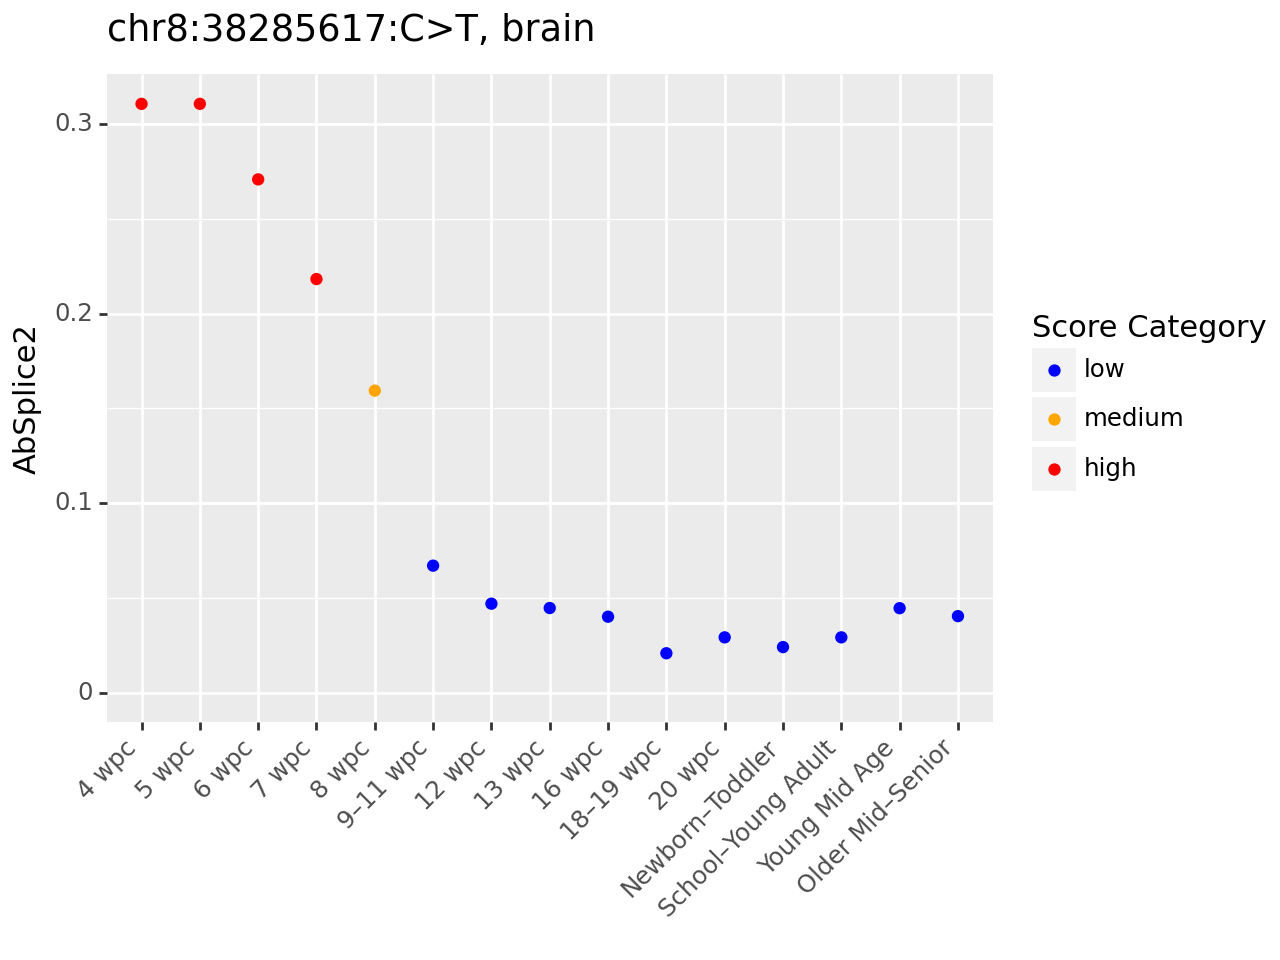

<Figure Size: (640 x 480)>

In [73]:
tissue_select = 'brain'

(
    ggplot(df_all_save[(df_all_save['tp_description'] != 'GTEx') & (df_all_save['tissue_type'] == tissue_select)], aes(x='tp_description', y='model_27', color='model_27_category'))
    + geom_point()
    + scale_color_manual(values={'high': 'red', 'medium': 'orange', 'low': 'blue'})
    + labs(
        y='AbSplice2',
        x='',
        title=f'{variant}, {tissue_select}',
        color='Score Category'
    )
    + scale_y_continuous(limits=(0, df_all_save[df_all_save['tissue_type'] == tissue_select]['model_27'].max()))
    + theme(
        axis_text_x=element_text(rotation=45, ha='right')
    )
)

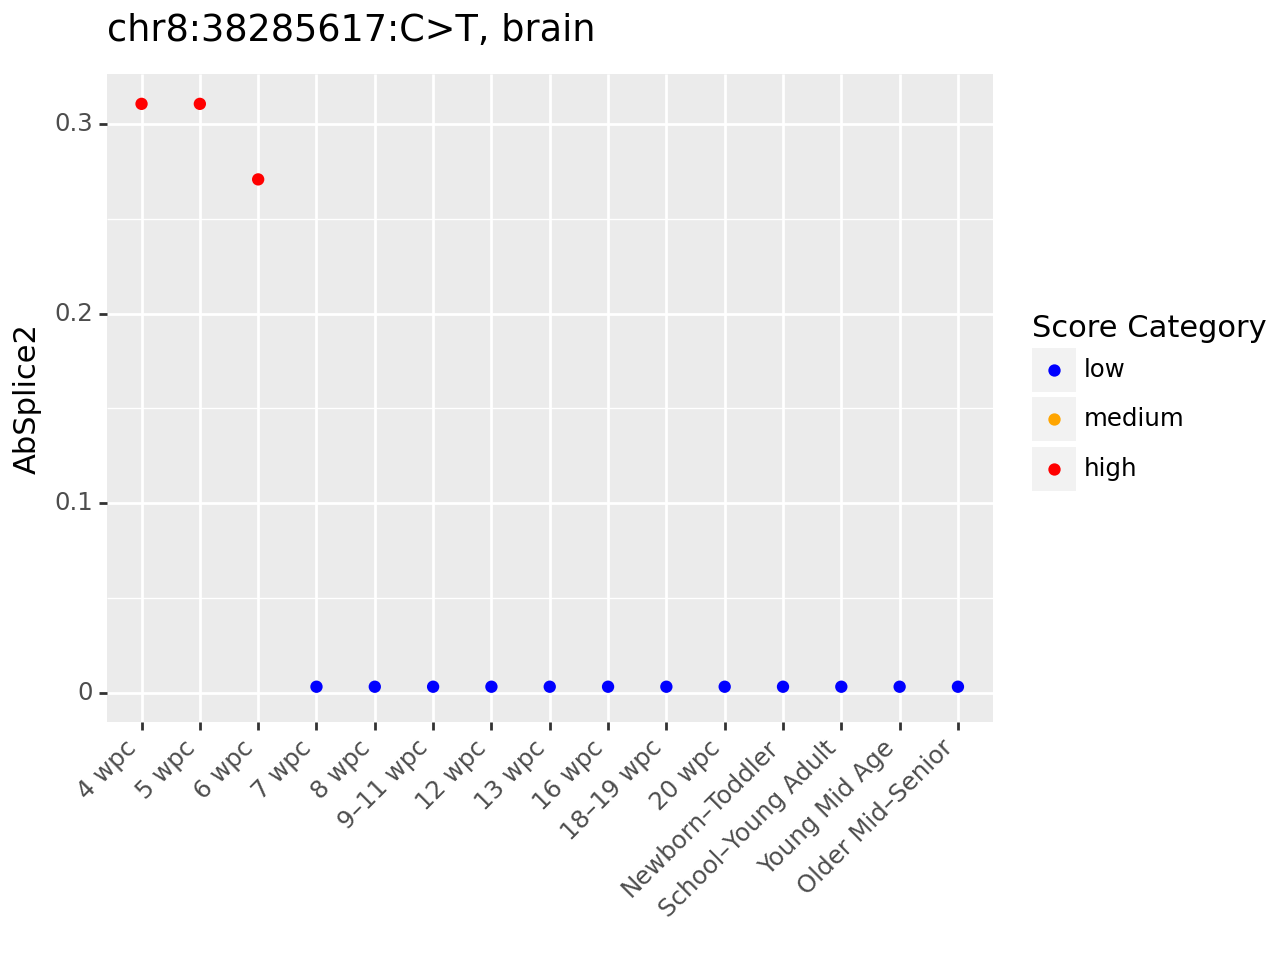

<Figure Size: (640 x 480)>

In [77]:
tissue_select = 'brain'
junction_select = 'chr8:38285615-38285863:-'

(
    ggplot(df_save[(df_save['tp_description'] != 'GTEx') & (df_save['tissue_type'] == tissue_select) & (df_save['junction'] == junction_select)], aes(x='tp_description', y='model_27', color='model_27_category'))
    + geom_point()
    + scale_color_manual(values={'high': 'red', 'medium': 'orange', 'low': 'blue'})
    + labs(
        y='AbSplice2',
        x='',
        title=f'{variant}, {tissue_select}',
        color='Score Category'
    )
    + scale_y_continuous(limits=(0, df_save[df_save['tissue_type'] == tissue_select]['model_27'].max()))
    + theme(
        axis_text_x=element_text(rotation=45, ha='right')
    )
)

In [78]:
# for idx, _ in enumerate(tissues_dev):
#     g = (
#         ggplot(df_all[idx], aes(x='tp_description', y='model_27', color='model_27_category'))
#         + geom_point()
#         + scale_color_manual(values={'high': 'red', 'medium': 'orange', 'low': 'blue'})
#         + labs(
#             y='AbSplice2',
#             x='',
#             title=f'{variant}, {tissues_dev[idx]}',
#             color='Score Category'
#         )
#         + scale_y_continuous(limits=(0, df_all[idx]['model_27'].max()))
#         + theme(
#             axis_text_x=element_text(rotation=45, ha='right')
#         )
#     )
#     print(g)

In [79]:
# for idx, _ in enumerate(tissues_dev):
#     g = (
#         ggplot(df[idx], aes(x='tp_description', y='model_27', color='model_27_category'))
#         + geom_point()
#         + facet_wrap('junction')
#         + scale_color_manual(values={'high': 'red', 'medium': 'orange', 'low': 'blue'})
#         + labs(
#             y='AbSplice2',
#             x='',
#             title=f'{variant}, {tissues_dev[idx]}',
#             color='Score Category'
#         )
#         + scale_y_continuous(limits=(0, df_all[idx]['model_27'].max()))
#         + theme(
#             figure_size=(12, 6),
#             axis_text_x=element_text(rotation=45, ha='right')
#         )
#     )
#     print(g)

## FN1, chr2:216237105:G>C

In [ ]:
df, df_all = plot_and_save(variant='chr2:216237105:G>C')

## NDUFS2, chr1:161183716:G>A

In [ ]:
df, df_all = plot_and_save(variant='chr1:161183716:G>A')

## ARFGEF1, chr8:68115487:C>T

In [ ]:
df, df_all = plot_and_save(variant='chr8:68115487:C>T')

# other candidates

In [286]:
variants_hg38 = [
    'chr1:161213926:G>A',
    'chr1:181793663:A>C',
    'chr1:21838825:C>T',
    'chr1:46190809:T>G',
    'chr2:206149017:T>C',
    'chr2:215372382:G>C',
    'chr2:99554536:T>C',
    'chr3:51987627:A>T',
    'chr4:127891683:T>C',
    'chr5:179623635:C>G',
    'chr5:6606872:C>T',
    'chr7:108237751:C>T',
    'chr8:144085277:T>G',
    'chr8:38428099:C>T',
    'chr8:67203252:C>T',
    'chr9:13147659:C>G',
    'chr9:89334732:T>C',
    'chr10:60166590:C>A',
    'chr11:57806454:C>G',
    'chr12:57582586:A>G',
    'chr15:57252494:T>A',
    'chr15:89303919:A>G',
    'chr16:75542598:T>C',
    'chr16:75542601:C>T',
    'chr17:31253005:G>A',
    'chr22:23766253:T>G'
]

In [287]:
from pyliftover import LiftOver
lo = LiftOver('hg38', 'hg19')

def lift_pos(chrom, pos):
    try:
        pos_lifted = lo.convert_coordinate(chrom, pos)[0][1]
        return pos_lifted
    except:
        return None

In [288]:
variants_hg19 = [f"{x.split(':')[0]}:{lift_pos(x.split(':')[0], int(x.split(':')[1]))}:{x.split(':')[2]}" for x in variants_hg38]

In [289]:
variant_map = {x: y for x, y in zip(variants_hg38, variants_hg19)}

In [290]:
for k, v in variant_map.items():
    print(f'{k} (hg38), {v} (hg19)')

chr1:161213926:G>A (hg38), chr1:161183716:G>A (hg19)
chr1:181793663:A>C (hg38), chr1:181762799:A>C (hg19)
chr1:21838825:C>T (hg38), chr1:22165318:C>T (hg19)
chr1:46190809:T>G (hg38), chr1:46656481:T>G (hg19)
chr2:206149017:T>C (hg38), chr2:207013741:T>C (hg19)
chr2:215372382:G>C (hg38), chr2:216237105:G>C (hg19)
chr2:99554536:T>C (hg38), chr2:100170998:T>C (hg19)
chr3:51987627:A>T (hg38), chr3:52021643:A>T (hg19)
chr4:127891683:T>C (hg38), chr4:128812838:T>C (hg19)
chr5:179623635:C>G (hg38), chr5:179050636:C>G (hg19)
chr5:6606872:C>T (hg38), chr5:6606985:C>T (hg19)
chr7:108237751:C>T (hg38), chr7:107878195:C>T (hg19)
chr8:144085277:T>G (hg38), chr8:145140180:T>G (hg19)
chr8:38428099:C>T (hg38), chr8:38285617:C>T (hg19)
chr8:67203252:C>T (hg38), chr8:68115487:C>T (hg19)
chr9:13147659:C>G (hg38), chr9:13147658:C>G (hg19)
chr9:89334732:T>C (hg38), chr9:91949647:T>C (hg19)
chr10:60166590:C>A (hg38), chr10:61926348:C>A (hg19)
chr11:57806454:C>G (hg38), chr11:57573926:C>G (hg19)
chr12:575825

## NDUFS2, chr1:161213926:G>A (hg38), chr1:161183716:G>A (hg19)

100%|██████████| 7/7 [02:20<00:00, 20.05s/it]


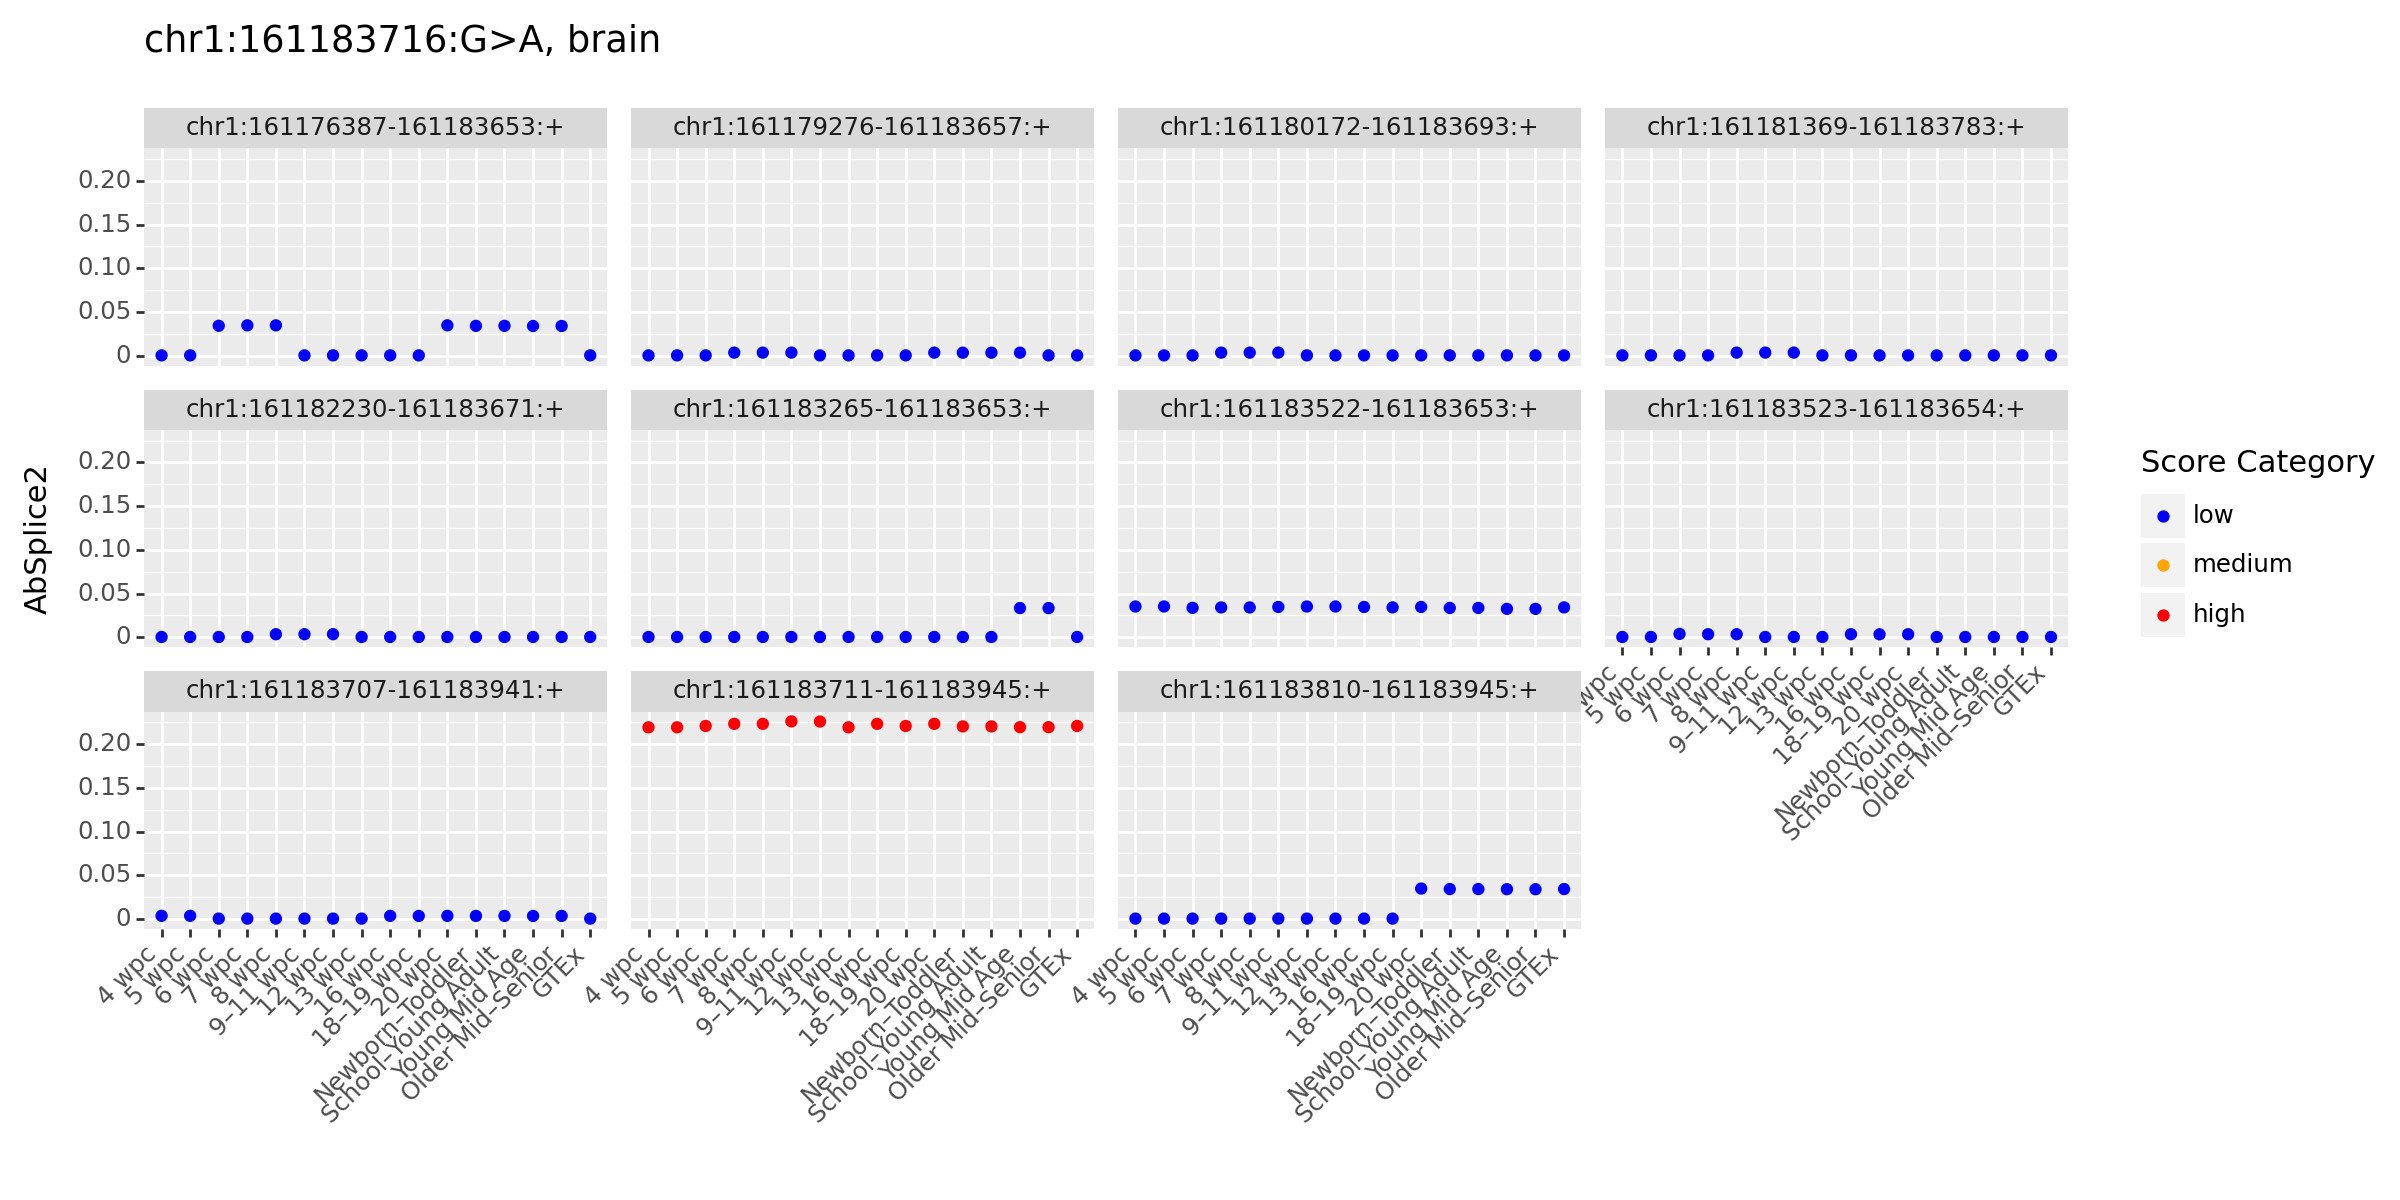

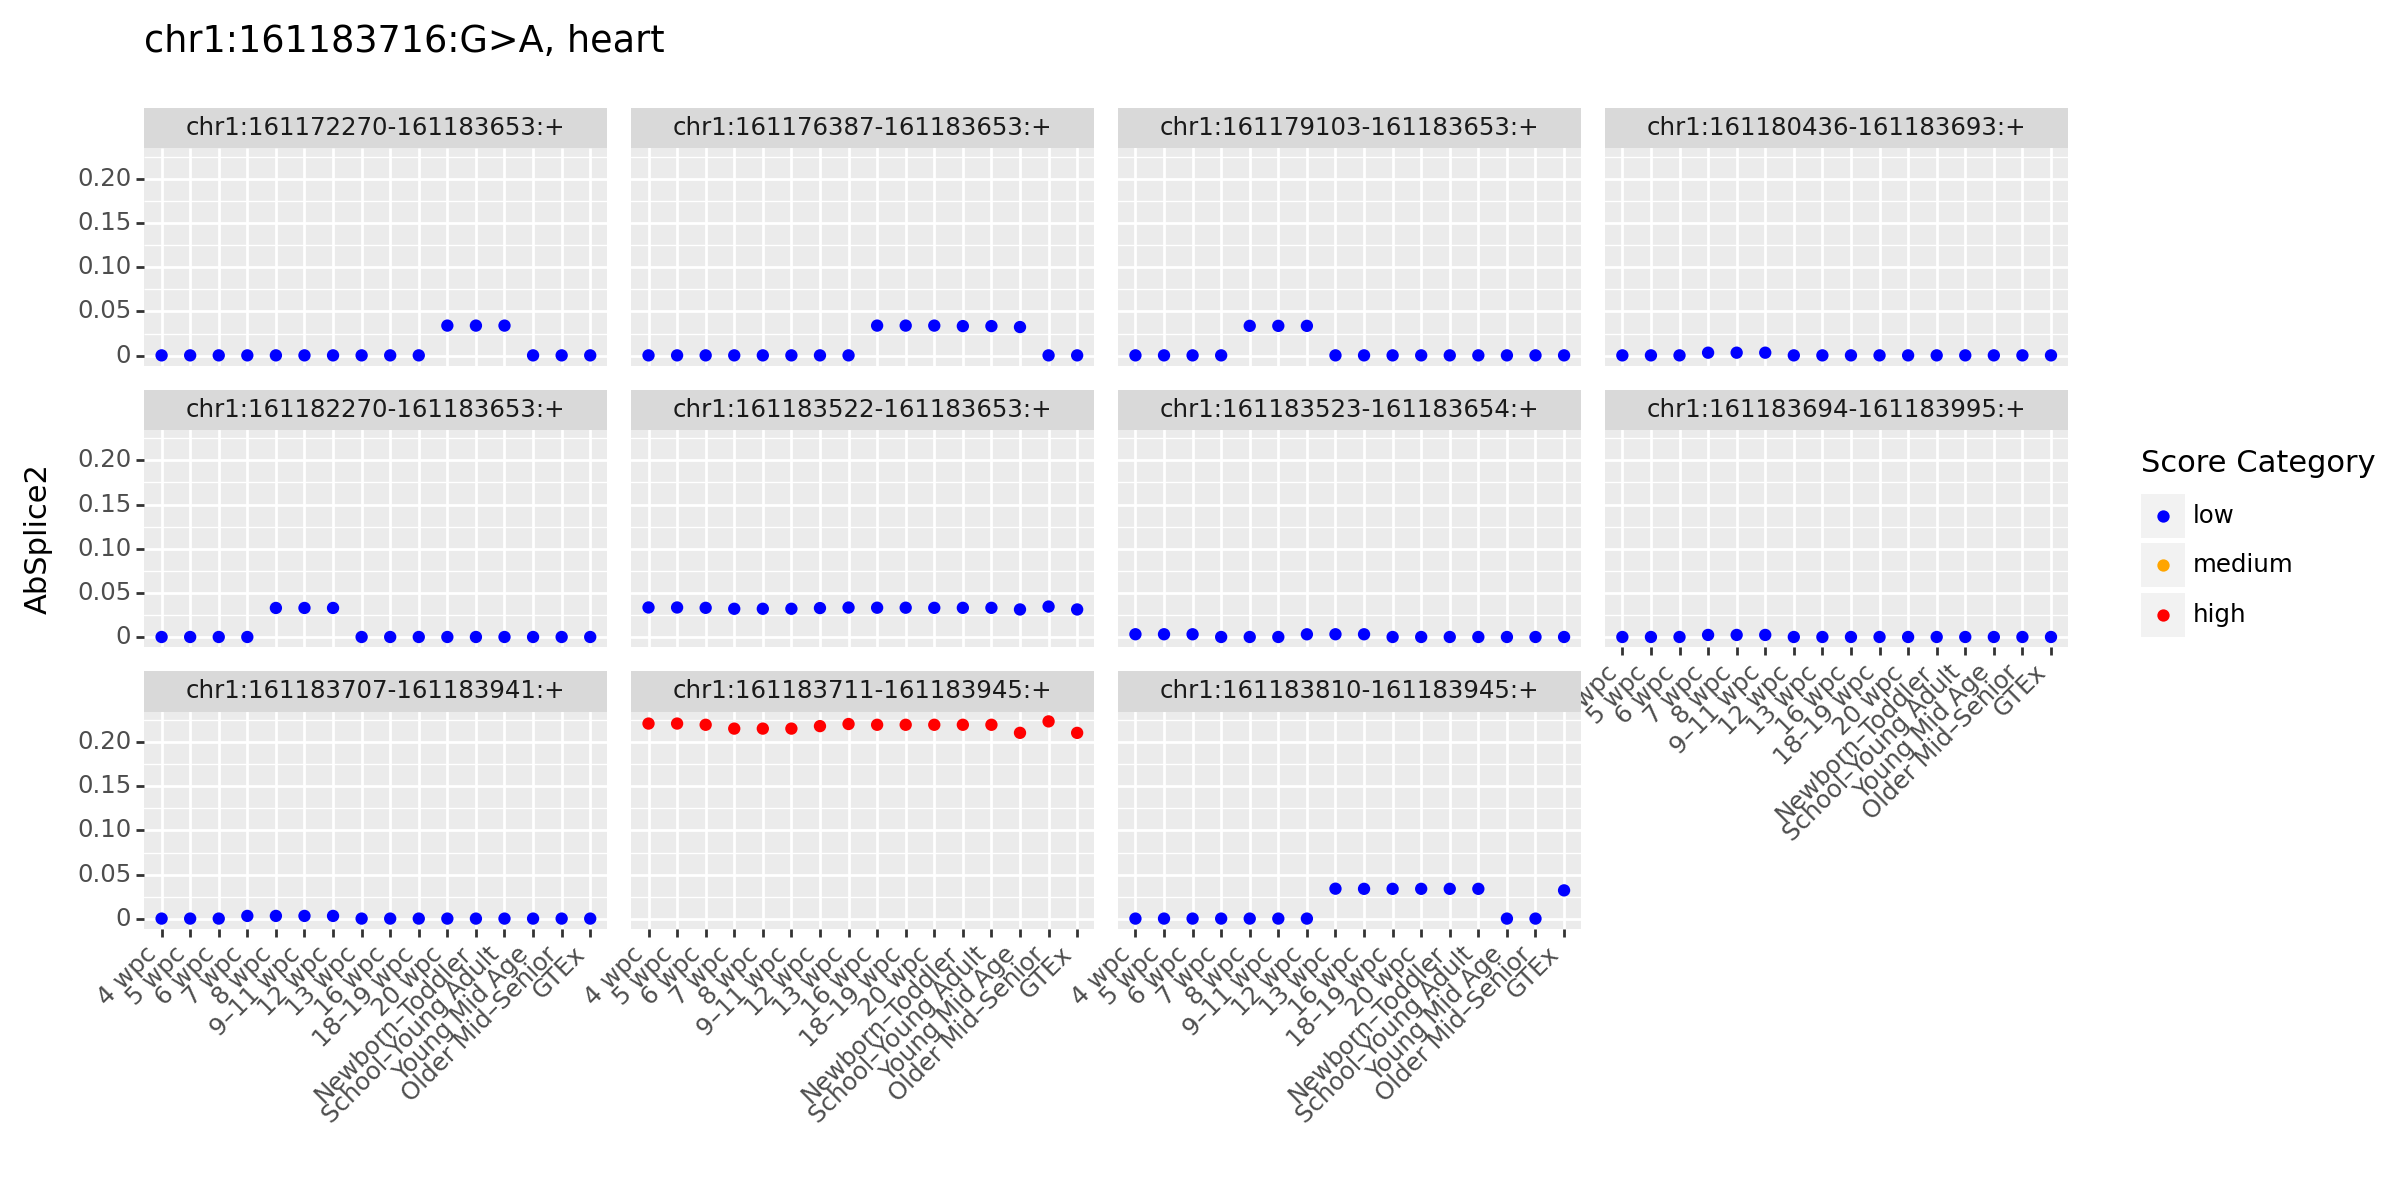

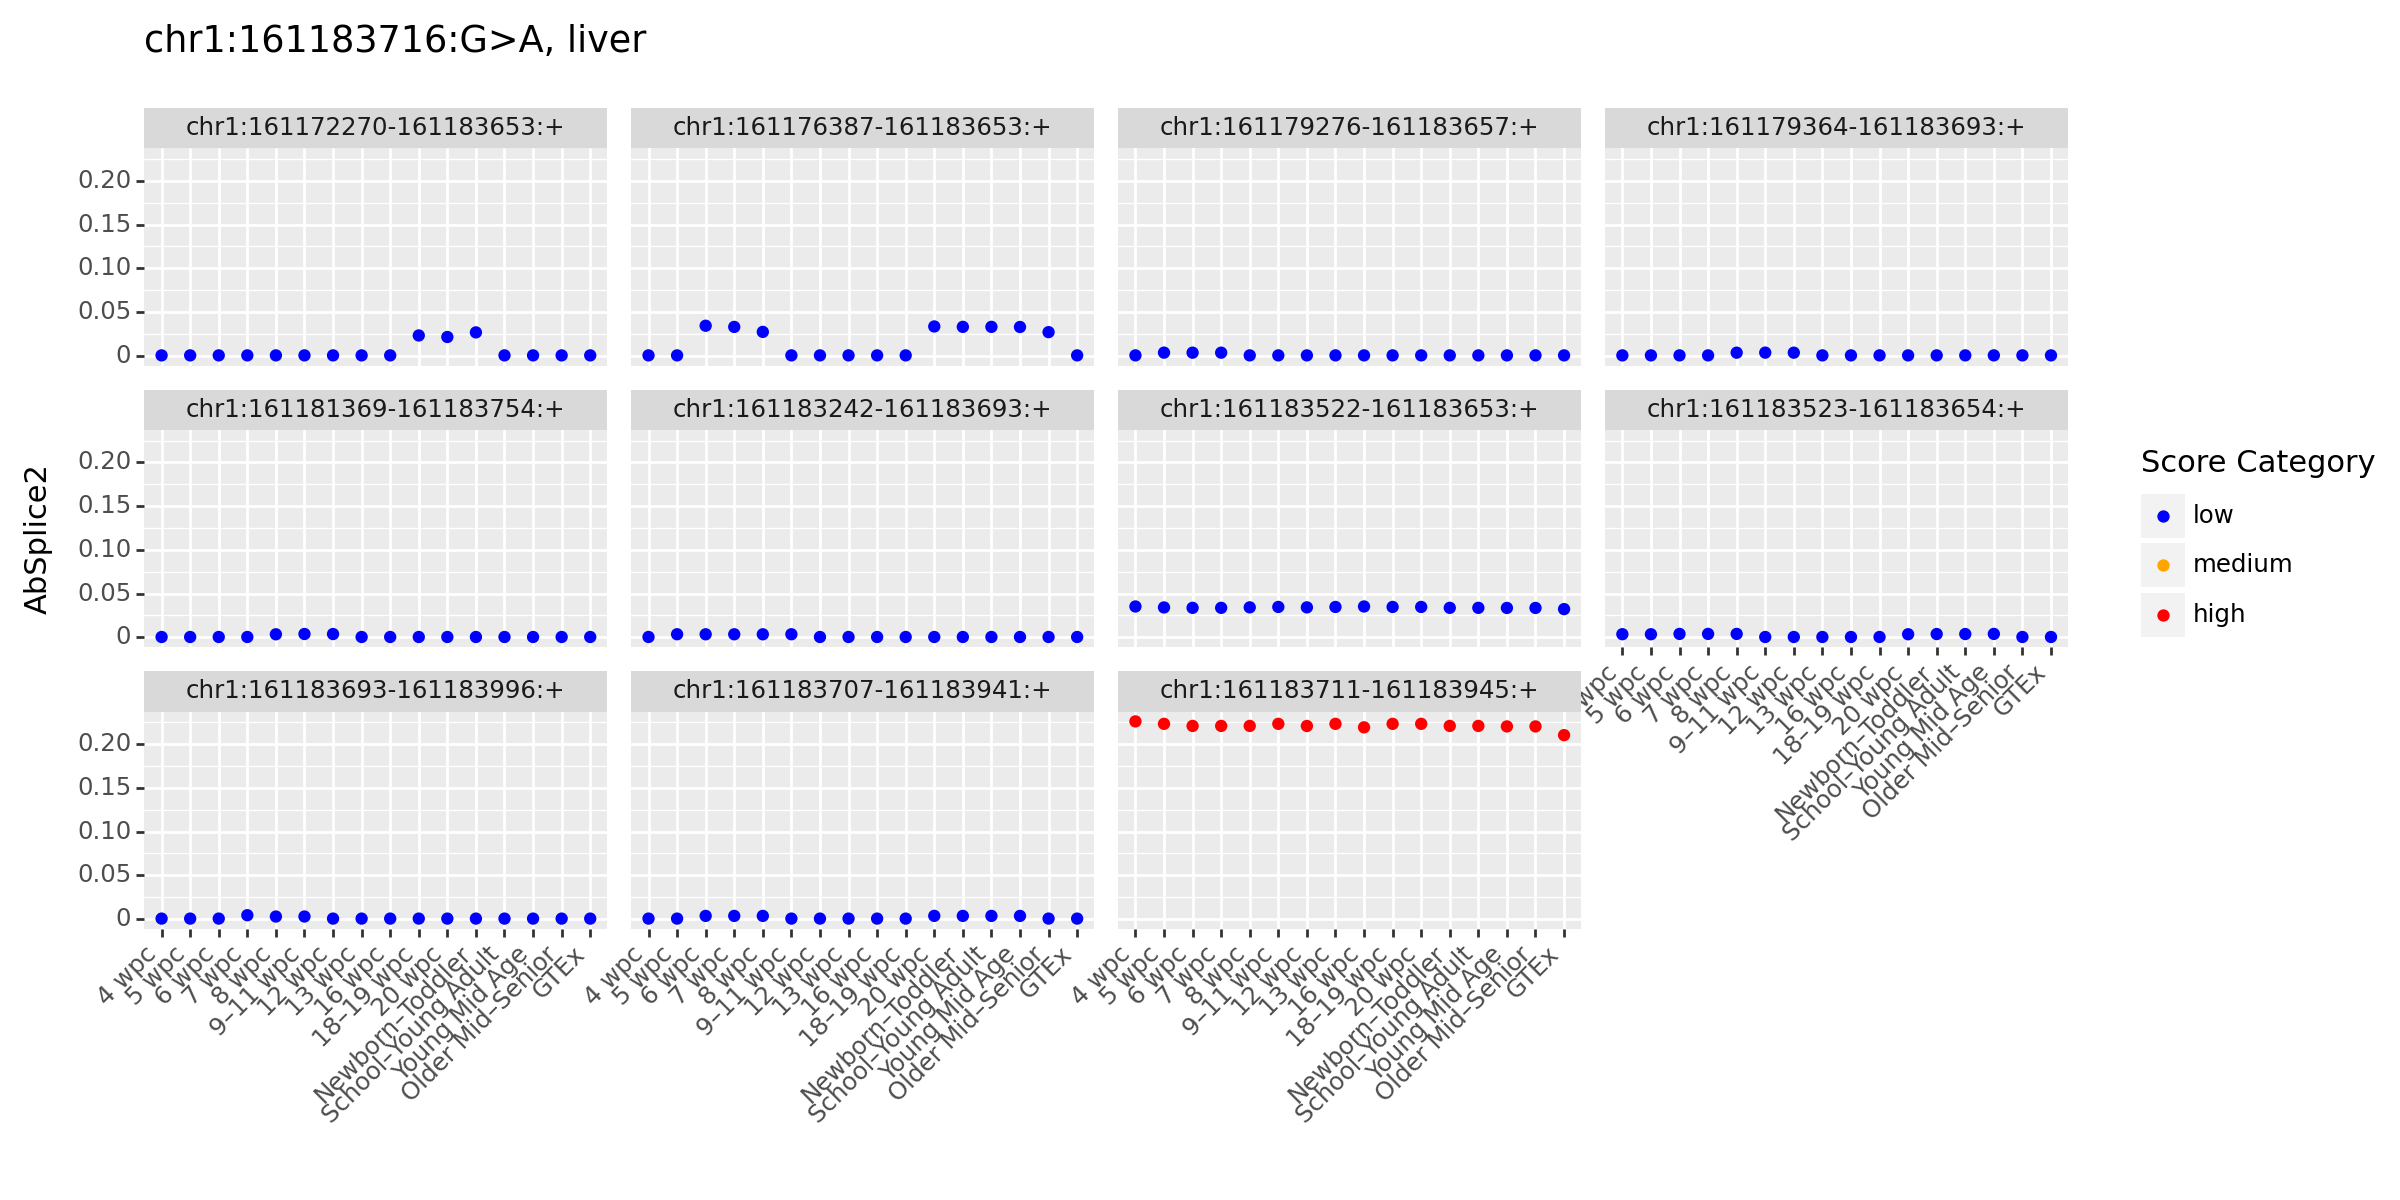

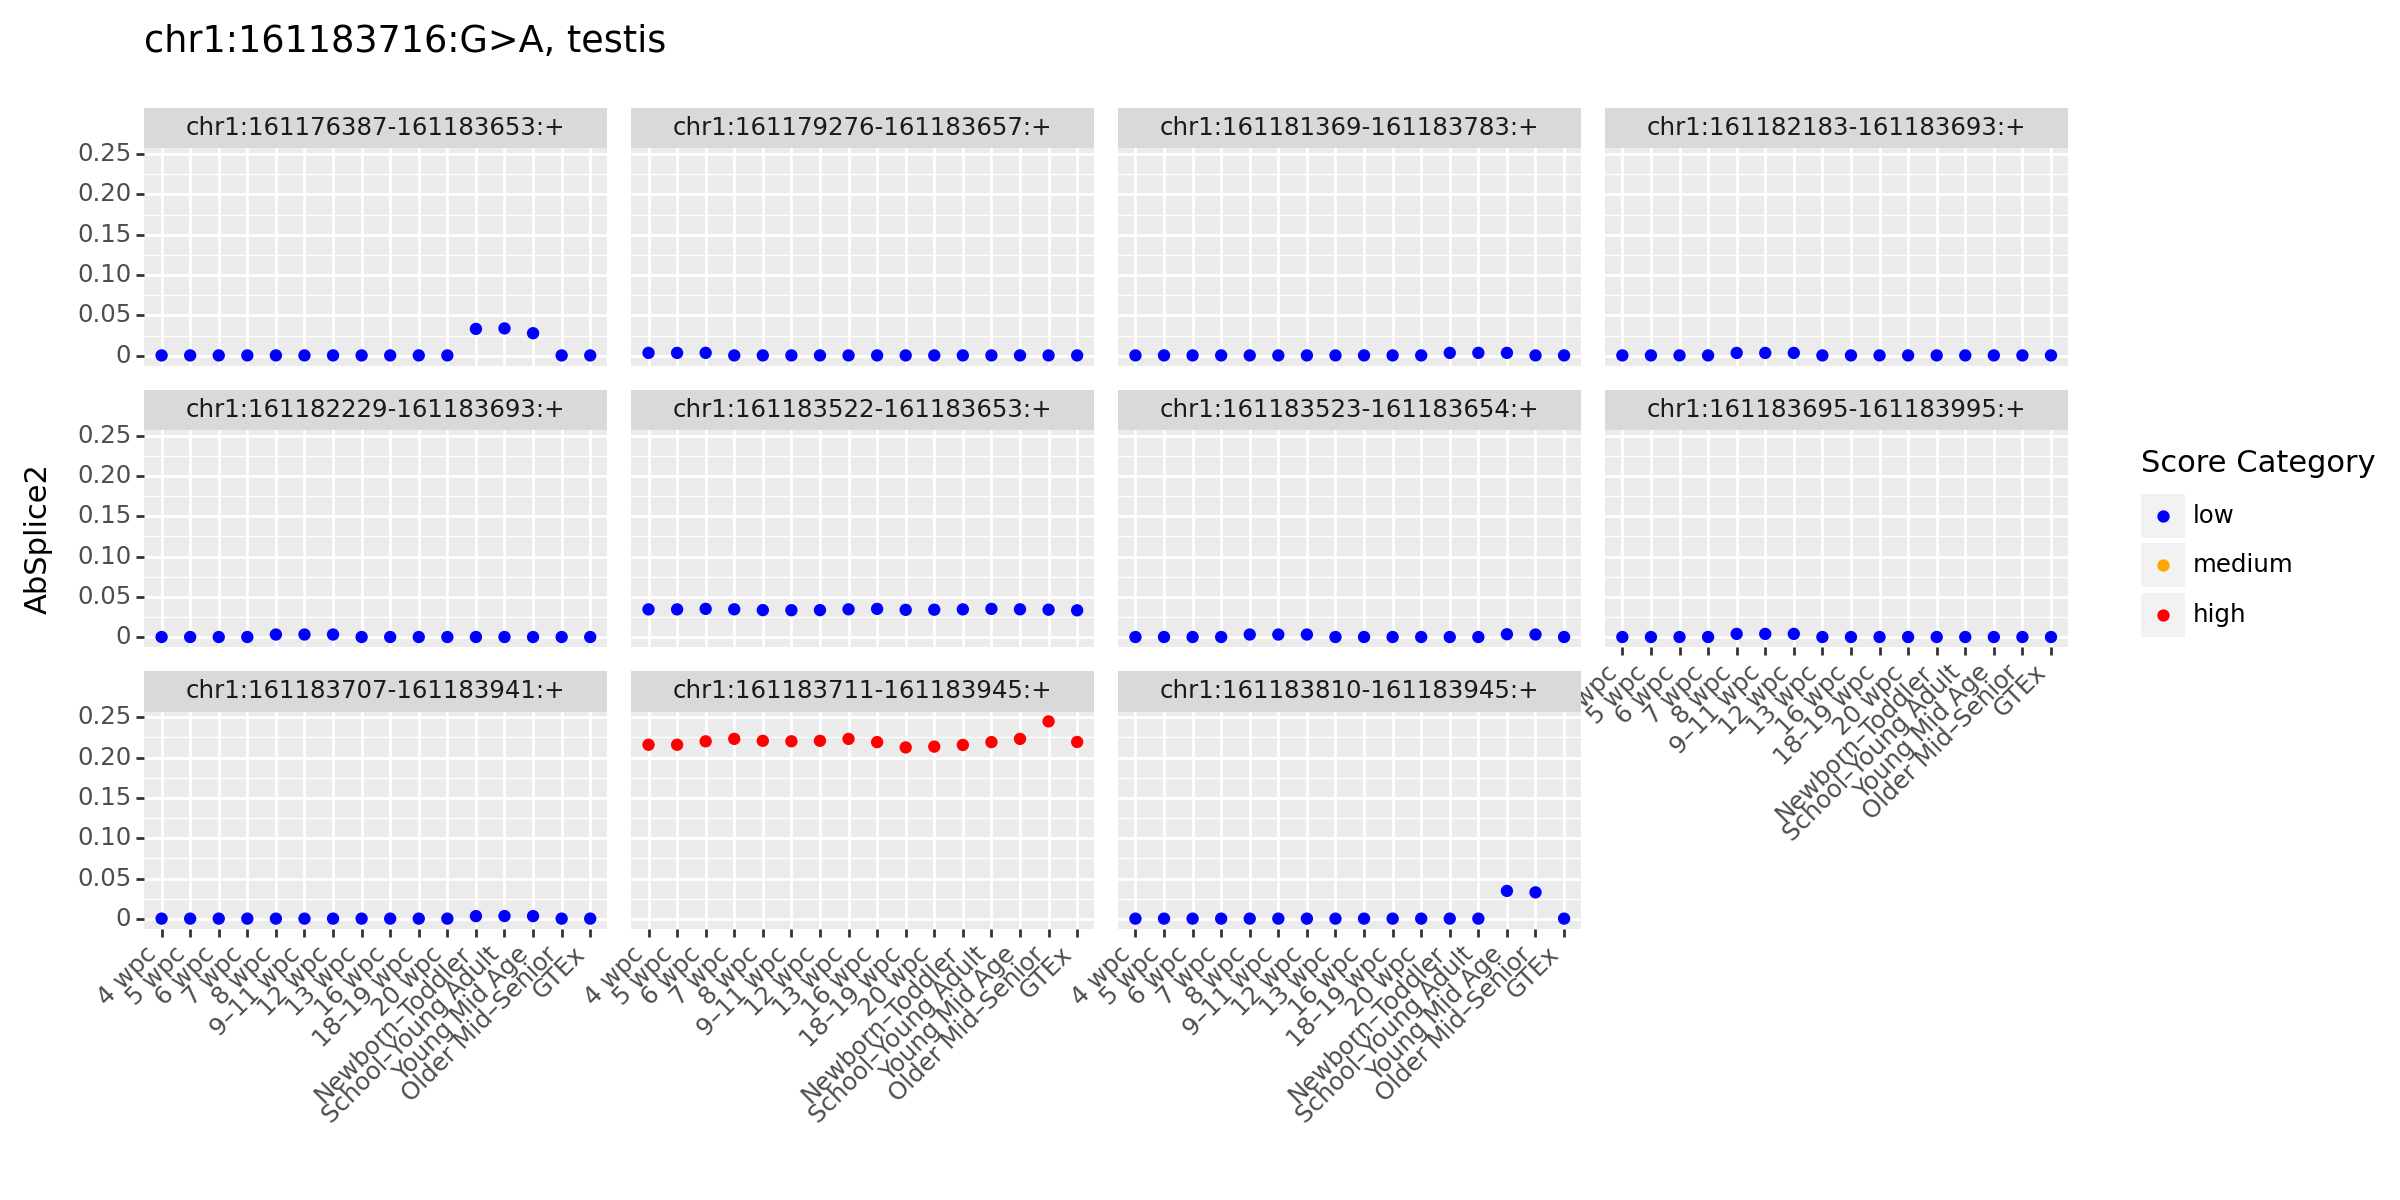

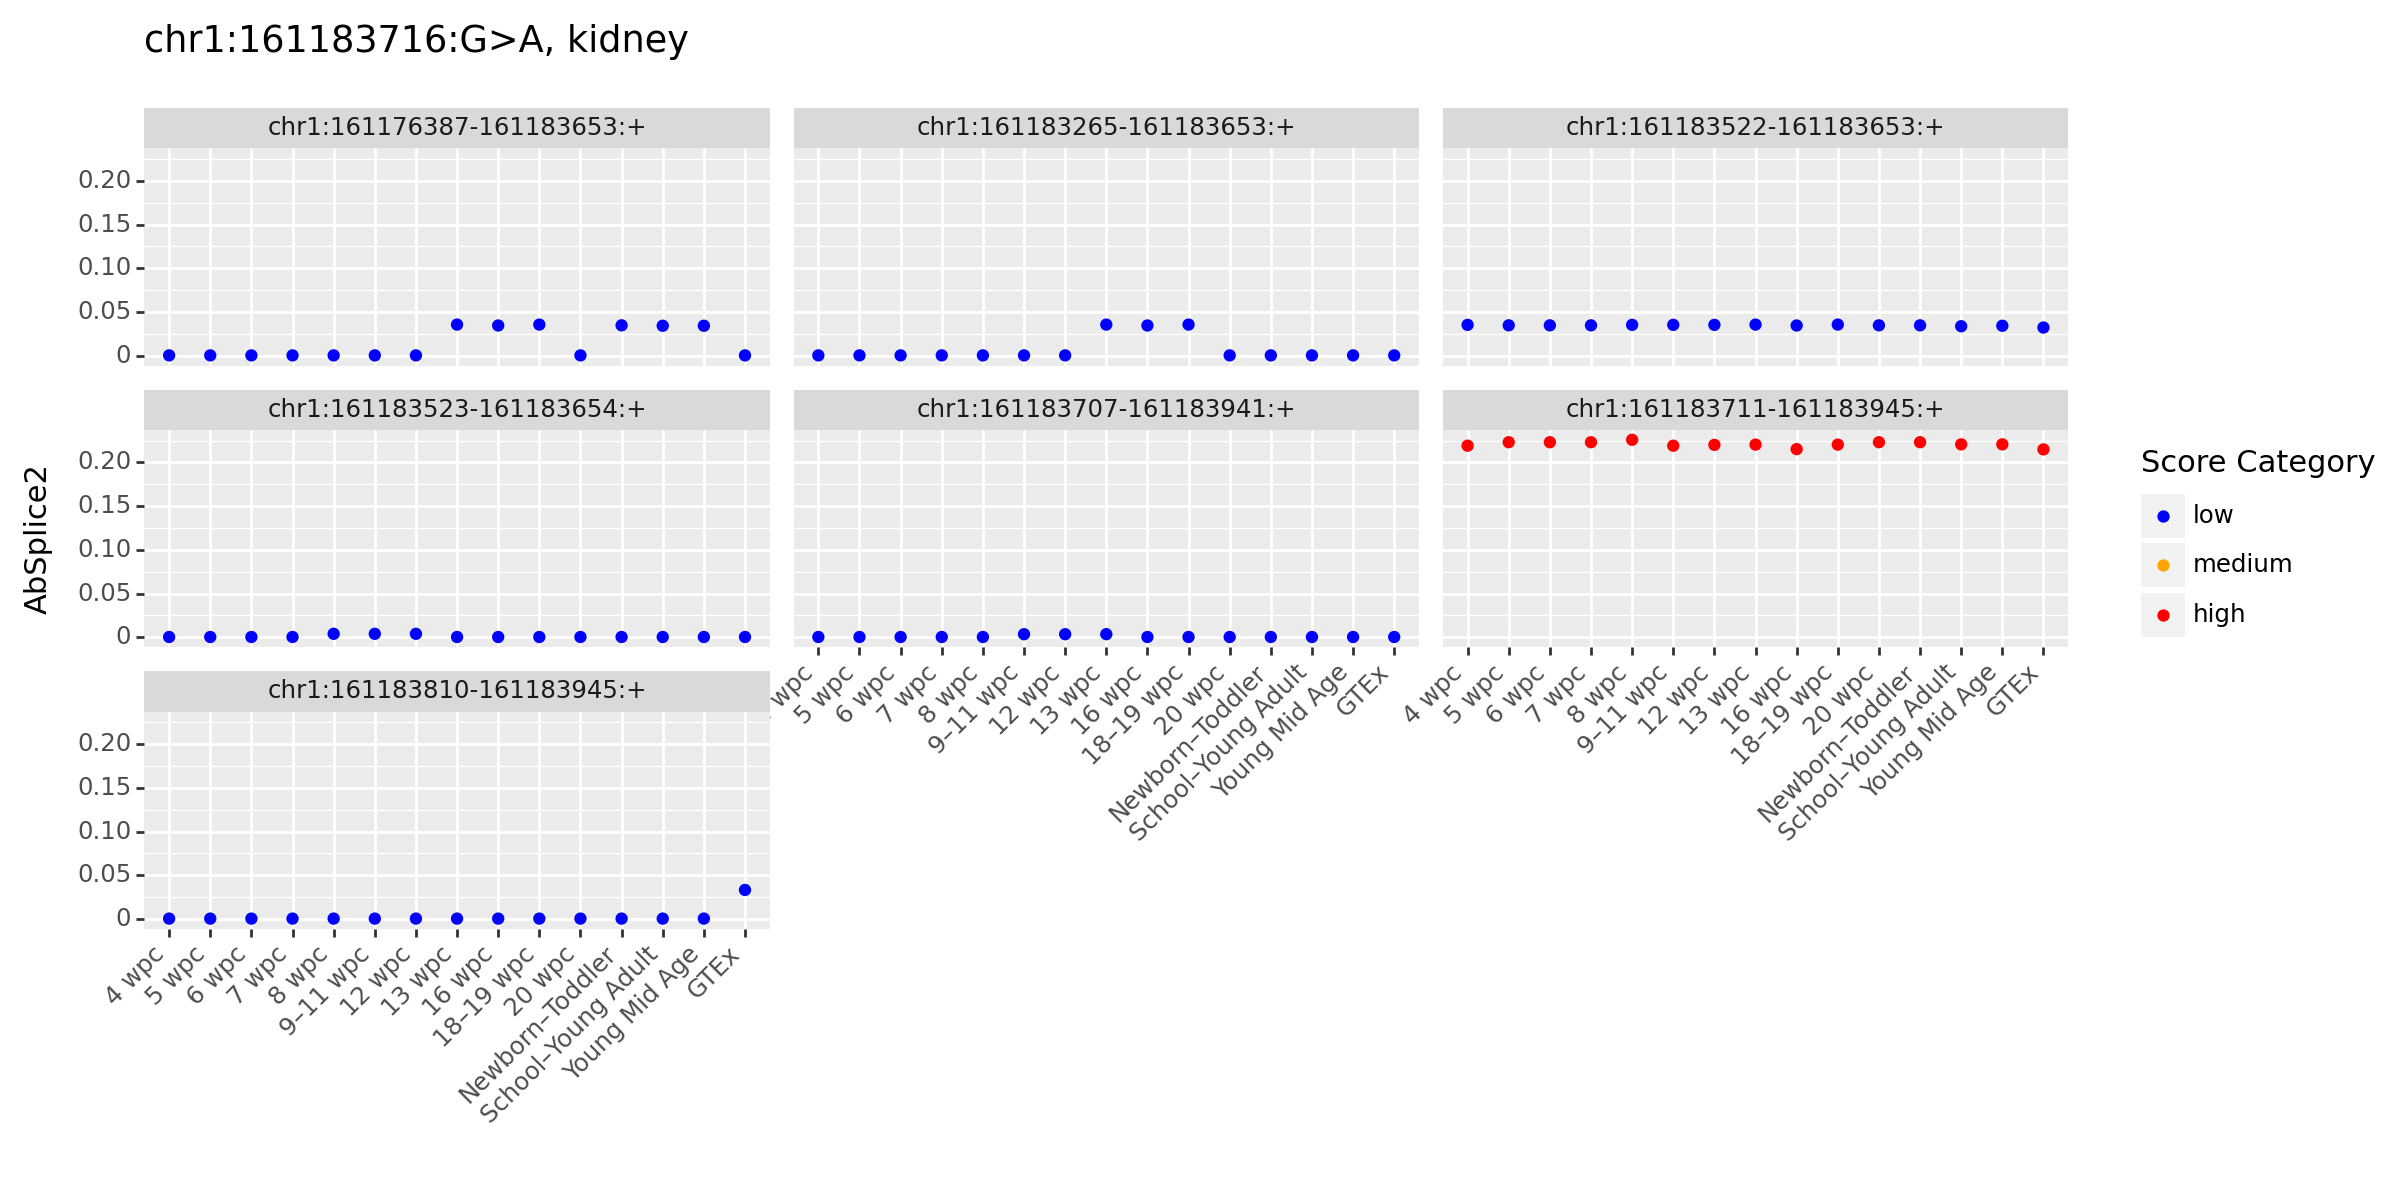

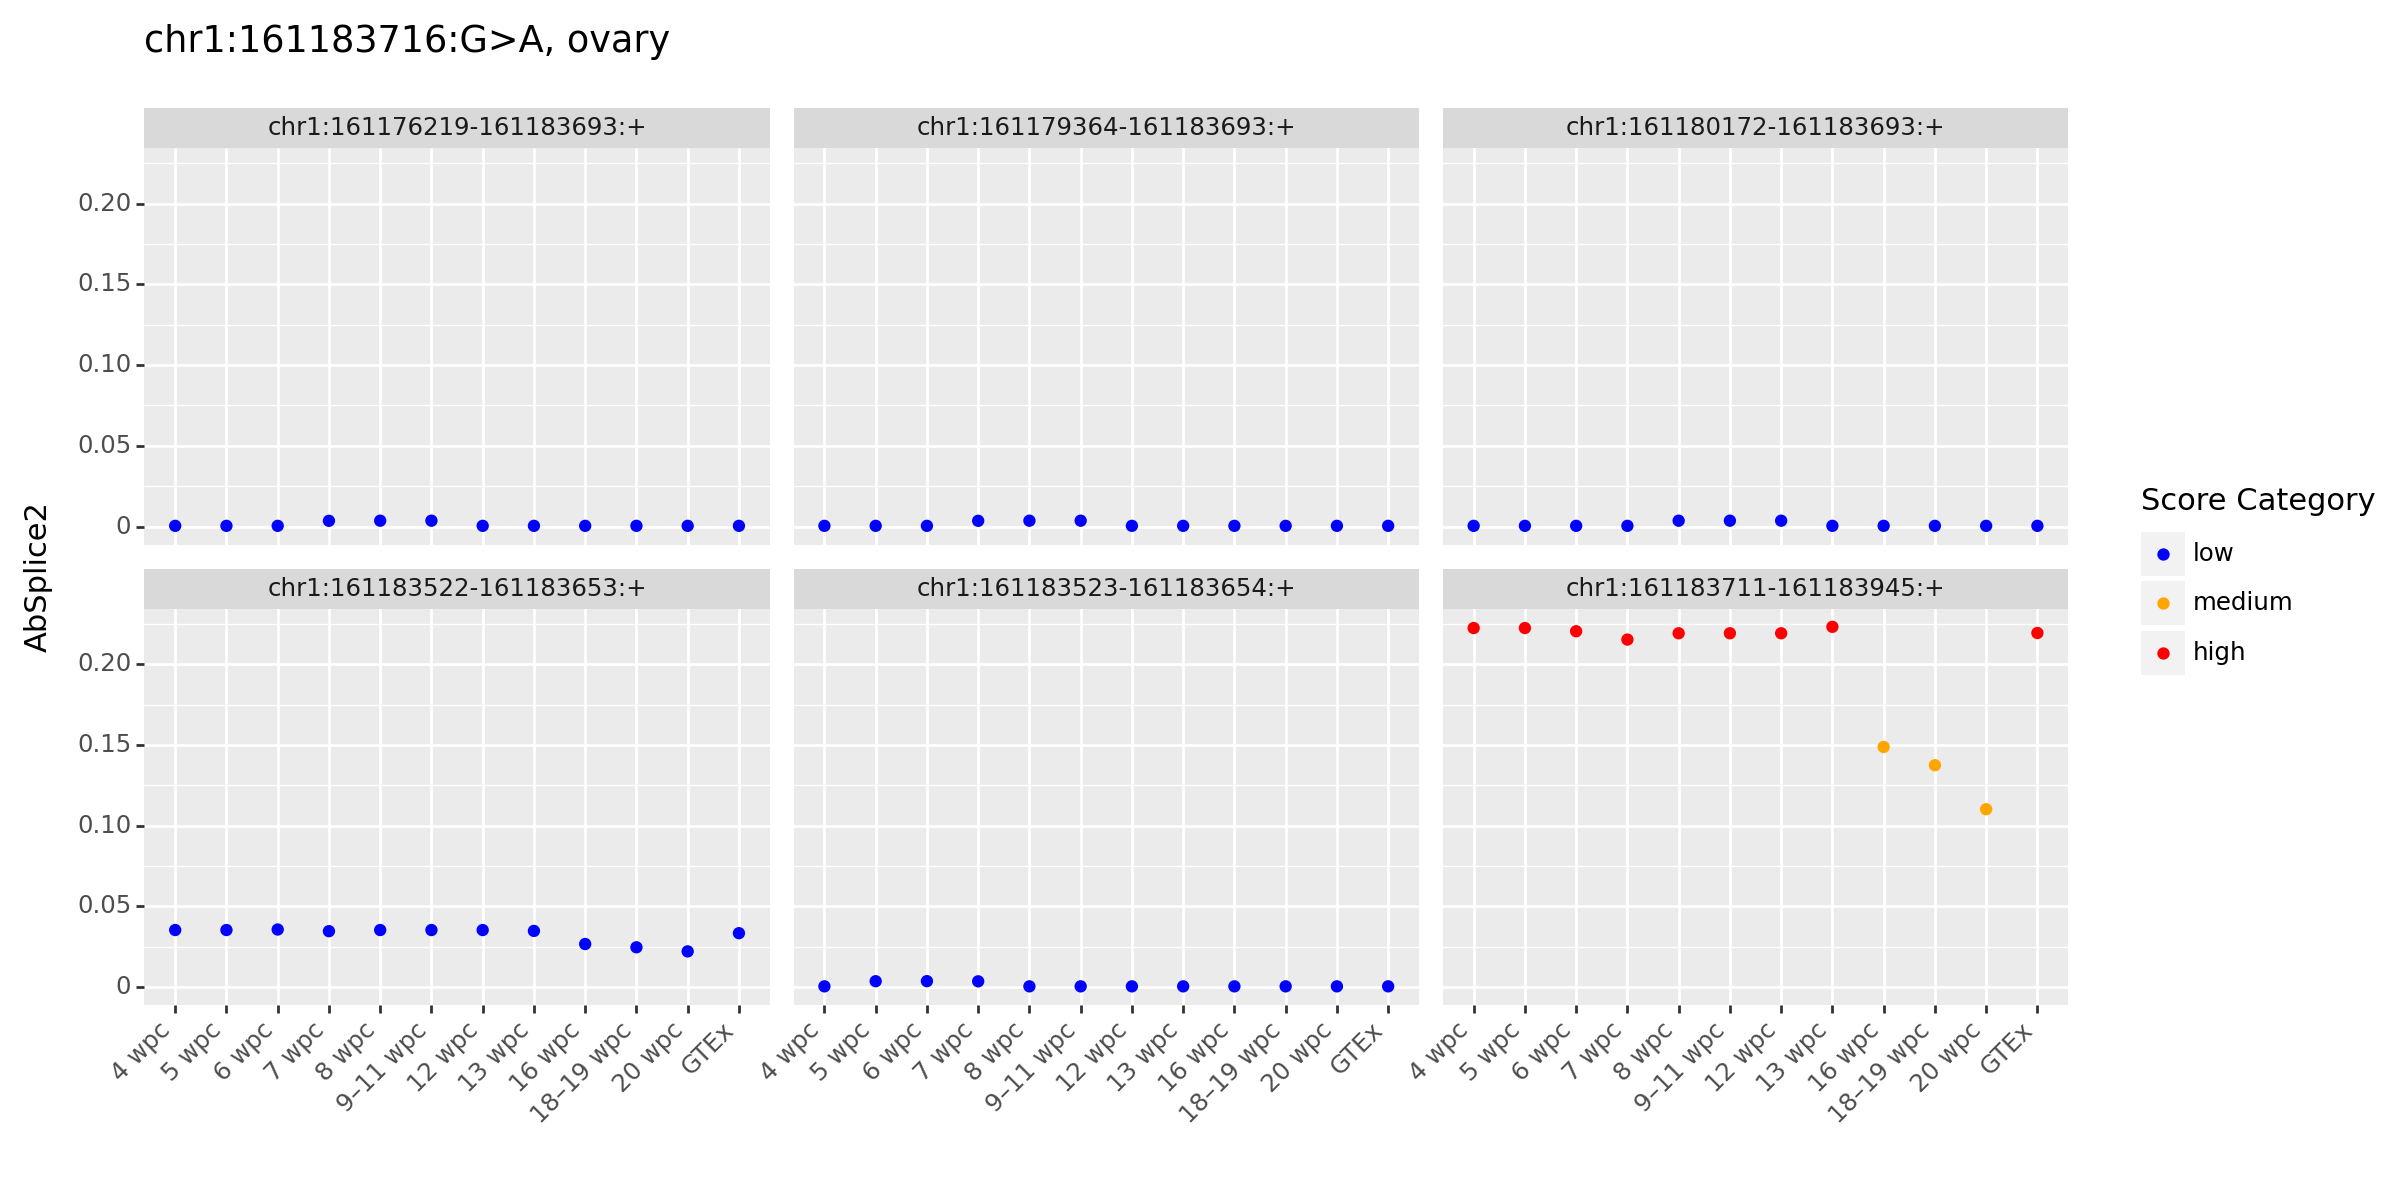

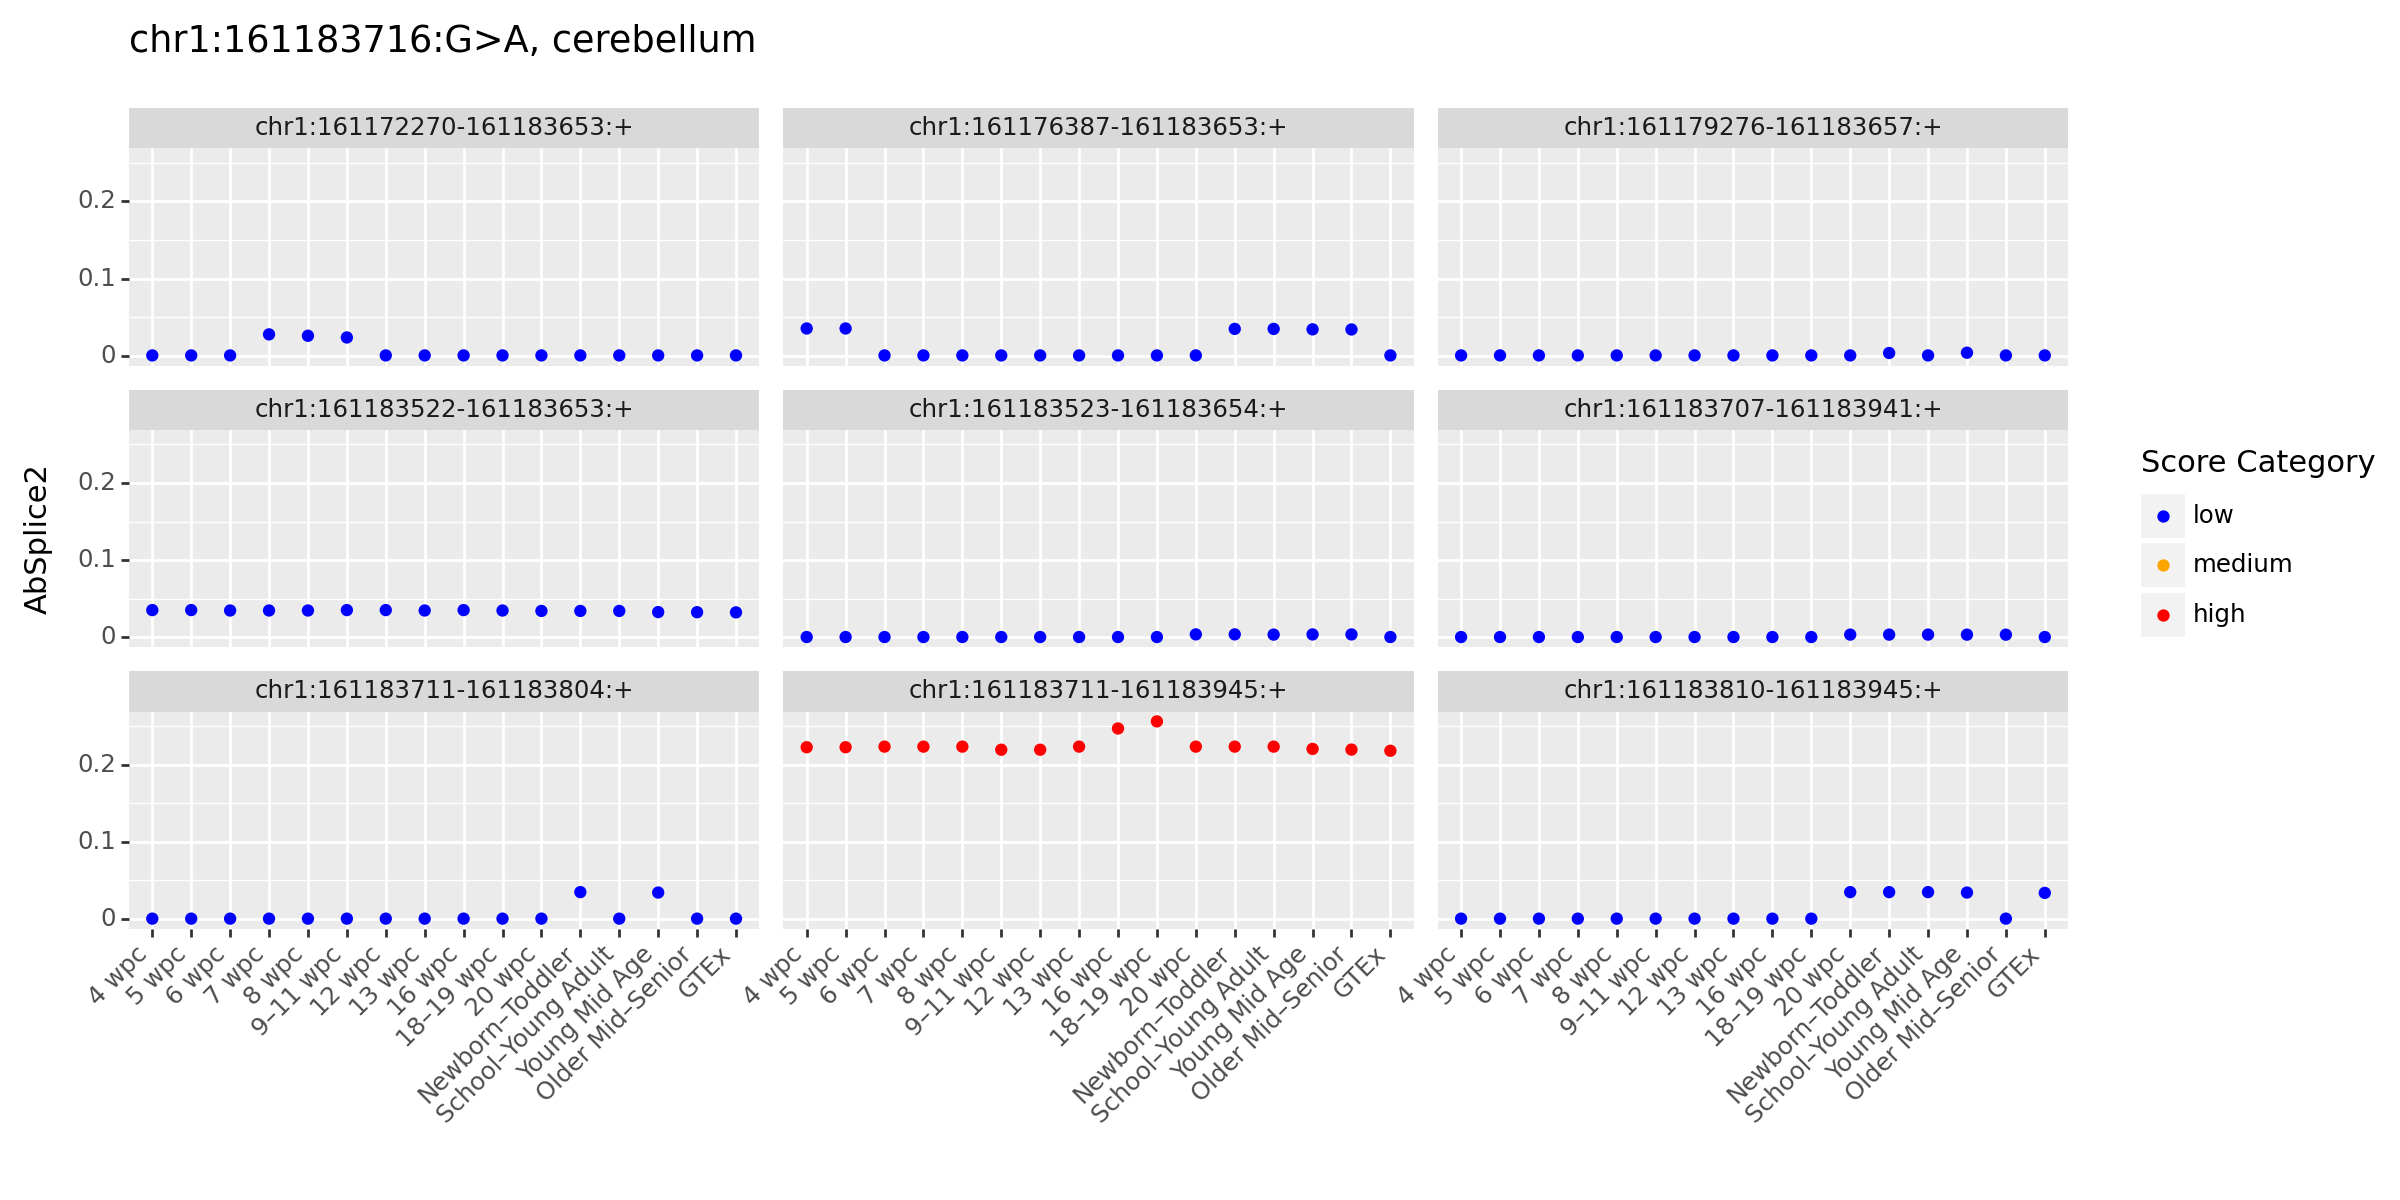

In [291]:
variant = variants_hg19[0]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [292]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

variant             tissue                    junction  \
32  chr1:161183716:G>A     human_brain_t1  chr1:161183711-161183945:+   
33  chr1:161183716:G>A     human_brain_t2  chr1:161183711-161183945:+   
34  chr1:161183716:G>A     human_brain_t3  chr1:161183711-161183945:+   
35  chr1:161183716:G>A     human_brain_t4  chr1:161183711-161183945:+   
36  chr1:161183716:G>A     human_brain_t5  chr1:161183711-161183945:+   
37  chr1:161183716:G>A     human_brain_t6  chr1:161183711-161183945:+   
38  chr1:161183716:G>A     human_brain_t7  chr1:161183711-161183945:+   
39  chr1:161183716:G>A     human_brain_t8  chr1:161183711-161183945:+   
40  chr1:161183716:G>A     human_brain_t9  chr1:161183711-161183945:+   
41  chr1:161183716:G>A    human_brain_t10  chr1:161183711-161183945:+   
42  chr1:161183716:G>A    human_brain_t11  chr1:161183711-161183945:+   
43  chr1:161183716:G>A    human_brain_t12  chr1:161183711-161183945:+   
44  chr1:161183716:G>A    human_brain_t13  chr1:161183711-161183945:+   
45  chr1:161183716:G>A    human_brain_t14  chr1:161183711-161183945:+   
46  chr1:161183716:G>A    human_brain_t15  chr1:161183711-161183945:+   
47  chr1:161183716:G>A  human_brain_tgtex  chr1:161183711-161183945:+   

    gain_score  gain_pos  loss_score  loss_pos  delta_logit_psi  delta_psi  \
32        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
33        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
34        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
35        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
36        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
37        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
38        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
39        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
40        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
41        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
42        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
43        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
44        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
45        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
46        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
47        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   

    median_n  median_n_pangolin      tp_description  AbSplice2  
32      91.0               91.0               4 wpc   0.219176  
33      91.0               91.0               5 wpc   0.219176  
34     142.0              142.0               6 wpc   0.220718  
35     118.0              118.0               7 wpc   0.223169  
36     114.0              114.0               8 wpc   0.223169  
37     105.0              104.0            9–11 wpc   0.225955  
38     106.0              105.5              12 wpc   0.225762  
39      94.5               94.5              13 wpc   0.219176  
40     109.0              109.0              16 wpc   0.223169  
41     132.5              131.0           18–19 wpc   0.220718  
42     128.0              127.0              20 wpc   0.223169  
43     174.0              175.0     Newborn–Toddler   0.220219  
44     179.0              175.0  School–Young Adult   0.220219  
45     193.0              192.0       Young Mid Age   0.219348  
46     216.5              213.5    Older Mid–Senior   0.219348  
47     149.5              149.0                GTEx   0.220781

variant             tissue                    junction  \
0   chr1:161183716:G>A     human_heart_t1  chr1:161183711-161183945:+   
1   chr1:161183716:G>A     human_heart_t2  chr1:161183711-161183945:+   
2   chr1:161183716:G>A     human_heart_t3  chr1:161183711-161183945:+   
3   chr1:161183716:G>A     human_heart_t4  chr1:161183711-161183945:+   
4   chr1:161183716:G>A     human_heart_t5  chr1:161183711-161183945:+   
5   chr1:161183716:G>A     human_heart_t6  chr1:161183711-161183945:+   
6   chr1:161183716:G>A     human_heart_t7  chr1:161183711-161183945:+   
7   chr1:161183716:G>A     human_heart_t8  chr1:161183711-161183945:+   
8   chr1:161183716:G>A     human_heart_t9  chr1:161183711-161183945:+   
9   chr1:161183716:G>A    human_heart_t10  chr1:161183711-161183945:+   
10  chr1:161183716:G>A    human_heart_t11  chr1:161183711-161183945:+   
11  chr1:161183716:G>A    human_heart_t12  chr1:161183711-161183945:+   
12  chr1:161183716:G>A    human_heart_t13  chr1:161183711-161183945:+   
13  chr1:161183716:G>A    human_heart_t14  chr1:161183711-161183945:+   
14  chr1:161183716:G>A    human_heart_t15  chr1:161183711-161183945:+   
15  chr1:161183716:G>A  human_heart_tgtex  chr1:161183711-161183945:+   

    gain_score  gain_pos  loss_score  loss_pos  delta_logit_psi  delta_psi  \
0         0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
1         0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
2         0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
3         0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
4         0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
5         0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
6         0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
7         0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
8         0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
9         0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
10        0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
11        0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
12        0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
13        0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
14        0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
15        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   

    median_n  median_n_pangolin      tp_description  AbSplice2  
0      163.0              162.5               4 wpc   0.220725  
1      163.0              162.5               5 wpc   0.220725  
2      211.0              211.0               6 wpc   0.219348  
3      262.0              261.0               7 wpc   0.215030  
4      270.0              268.0               8 wpc   0.215030  
5      270.5              269.0            9–11 wpc   0.215030  
6      236.0              236.0              12 wpc   0.217838  
7      176.0              176.0              13 wpc   0.220219  
8      189.0              189.0              16 wpc   0.219348  
9      189.0              189.0           18–19 wpc   0.219348  
10     212.0              210.0              20 wpc   0.219348  
11     224.0              223.0     Newborn–Toddler   0.219348  
12     224.0              223.0  School–Young Adult   0.219348  
13     420.0              418.0       Young Mid Age   0.210257  
14     116.0              115.0    Older Mid–Senior   0.223169  
15     435.0              433.0                GTEx   0.210217

variant             tissue                    junction  \
0   chr1:161183716:G>A     human_liver_t1  chr1:161183711-161183945:+   
1   chr1:161183716:G>A     human_liver_t2  chr1:161183711-161183945:+   
2   chr1:161183716:G>A     human_liver_t3  chr1:161183711-161183945:+   
3   chr1:161183716:G>A     human_liver_t4  chr1:161183711-161183945:+   
4   chr1:161183716:G>A     human_liver_t5  chr1:161183711-161183945:+   
5   chr1:161183716:G>A     human_liver_t6  chr1:161183711-161183945:+   
6   chr1:161183716:G>A     human_liver_t7  chr1:161183711-161183945:+   
7   chr1:161183716:G>A     human_liver_t8  chr1:161183711-161183945:+   
8   chr1:161183716:G>A     human_liver_t9  chr1:161183711-161183945:+   
9   chr1:161183716:G>A    human_liver_t10  chr1:161183711-161183945:+   
10  chr1:161183716:G>A    human_liver_t11  chr1:161183711-161183945:+   
11  chr1:161183716:G>A    human_liver_t12  chr1:161183711-161183945:+   
12  chr1:161183716:G>A    human_liver_t13  chr1:161183711-161183945:+   
13  chr1:161183716:G>A    human_liver_t14  chr1:161183711-161183945:+   
14  chr1:161183716:G>A    human_liver_t15  chr1:161183711-161183945:+   
15  chr1:161183716:G>A  human_liver_tgtex  chr1:161183711-161183945:+   

    gain_score  gain_pos  loss_score  loss_pos  delta_logit_psi  delta_psi  \
0         0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
1         0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
2         0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
3         0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
4         0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
5         0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
6         0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
7         0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
8         0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
9         0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
10        0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
11        0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
12        0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
13        0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
14        0.03      20.0       -0.46      -5.0        -1.539014  -0.034955   
15        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   

    median_n  median_n_pangolin      tp_description  AbSplice2  
0      104.5              104.0               4 wpc   0.225955  
1      123.5              123.5               5 wpc   0.223169  
2      157.5              157.0               6 wpc   0.220781  
3      148.5              148.5               7 wpc   0.220781  
4      145.5              145.5               8 wpc   0.220781  
5      127.0              126.0            9–11 wpc   0.223169  
6      134.0              133.5              12 wpc   0.220718  
7      111.5              111.5              13 wpc   0.223169  
8       99.0               99.0              16 wpc   0.219176  
9      107.0              107.0           18–19 wpc   0.223169  
10     113.0              112.5              20 wpc   0.223169  
11     151.0              151.0     Newborn–Toddler   0.220781  
12     151.0              151.0  School–Young Adult   0.220781  
13     167.5              167.5       Young Mid Age   0.220219  
14     171.0              171.0    Older Mid–Senior   0.220219  
15     410.0              410.0                GTEx   0.210257

variant              tissue                    junction  \
32  chr1:161183716:G>A     human_testis_t1  chr1:161183711-161183945:+   
33  chr1:161183716:G>A     human_testis_t2  chr1:161183711-161183945:+   
34  chr1:161183716:G>A     human_testis_t3  chr1:161183711-161183945:+   
35  chr1:161183716:G>A     human_testis_t4  chr1:161183711-161183945:+   
36  chr1:161183716:G>A     human_testis_t5  chr1:161183711-161183945:+   
37  chr1:161183716:G>A     human_testis_t6  chr1:161183711-161183945:+   
38  chr1:161183716:G>A     human_testis_t7  chr1:161183711-161183945:+   
39  chr1:161183716:G>A     human_testis_t8  chr1:161183711-161183945:+   
40  chr1:161183716:G>A     human_testis_t9  chr1:161183711-161183945:+   
41  chr1:161183716:G>A    human_testis_t10  chr1:161183711-161183945:+   
42  chr1:161183716:G>A    human_testis_t11  chr1:161183711-161183945:+   
43  chr1:161183716:G>A    human_testis_t12  chr1:161183711-161183945:+   
44  chr1:161183716:G>A    human_testis_t13  chr1:161183711-161183945:+   
45  chr1:161183716:G>A    human_testis_t14  chr1:161183711-161183945:+   
46  chr1:161183716:G>A    human_testis_t15  chr1:161183711-161183945:+   
47  chr1:161183716:G>A  human_testis_tgtex  chr1:161183711-161183945:+   

    gain_score  gain_pos  loss_score  loss_pos  delta_logit_psi  delta_psi  \
32        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
33        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
34        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
35        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
36        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
37        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
38        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
39        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
40        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
41        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
42        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
43        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
44        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
45        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
46        0.03      20.0       -0.46      -5.0        -1.539016  -0.047089   
47        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   

    median_n  median_n_pangolin      tp_description  AbSplice2  
32      73.0               73.0               4 wpc   0.215894  
33      73.0               73.0               5 wpc   0.215894  
34     100.0               99.0               6 wpc   0.220146  
35     107.0              107.0               7 wpc   0.223169  
36     157.0              157.0               8 wpc   0.220781  
37     175.0              175.0            9–11 wpc   0.220219  
38     157.0              157.0              12 wpc   0.220781  
39     109.0              108.0              13 wpc   0.223169  
40      97.0               96.0              16 wpc   0.219176  
41      80.0               80.0           18–19 wpc   0.212605  
42      76.5               76.5              20 wpc   0.213579  
43      85.0               85.0     Newborn–Toddler   0.215635  
44      94.0               94.0  School–Young Adult   0.219176  
45     110.0              109.5       Young Mid Age   0.223169  
46      80.0               79.0    Older Mid–Senior   0.244845  
47     198.0              198.0                GTEx   0.219348

variant              tissue                    junction  \
15  chr1:161183716:G>A     human_kidney_t1  chr1:161183711-161183945:+   
16  chr1:161183716:G>A     human_kidney_t2  chr1:161183711-161183945:+   
17  chr1:161183716:G>A     human_kidney_t3  chr1:161183711-161183945:+   
18  chr1:161183716:G>A     human_kidney_t4  chr1:161183711-161183945:+   
19  chr1:161183716:G>A     human_kidney_t5  chr1:161183711-161183945:+   
20  chr1:161183716:G>A     human_kidney_t6  chr1:161183711-161183945:+   
21  chr1:161183716:G>A     human_kidney_t7  chr1:161183711-161183945:+   
22  chr1:161183716:G>A     human_kidney_t8  chr1:161183711-161183945:+   
23  chr1:161183716:G>A     human_kidney_t9  chr1:161183711-161183945:+   
24  chr1:161183716:G>A    human_kidney_t10  chr1:161183711-161183945:+   
25  chr1:161183716:G>A    human_kidney_t11  chr1:161183711-161183945:+   
26  chr1:161183716:G>A    human_kidney_t12  chr1:161183711-161183945:+   
27  chr1:161183716:G>A    human_kidney_t13  chr1:161183711-161183945:+   
28  chr1:161183716:G>A    human_kidney_t14  chr1:161183711-161183945:+   
29  chr1:161183716:G>A  human_kidney_tgtex  chr1:161183711-161183945:+   

    gain_score  gain_pos  loss_score  loss_pos  delta_logit_psi  delta_psi  \
15        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
16        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
17        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
18        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
19        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
20        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
21        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
22        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
23        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
24        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
25        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
26        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
27        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
28        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
29        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   

    median_n  median_n_pangolin      tp_description  AbSplice2  
15      90.0               90.0               4 wpc   0.219176  
16     113.0              113.0               5 wpc   0.223169  
17     120.5              120.5               6 wpc   0.223169  
18     113.0              113.0               7 wpc   0.223169  
19     102.0              102.0               8 wpc   0.225955  
20      99.0               99.0            9–11 wpc   0.219176  
21     100.5              100.5              12 wpc   0.220146  
22      88.0               88.0              13 wpc   0.220431  
23      81.5               81.5              16 wpc   0.215272  
24      87.0               86.0           18–19 wpc   0.220431  
25     117.0              117.0              20 wpc   0.223169  
26     127.0              127.0     Newborn–Toddler   0.223169  
27     138.5              138.5  School–Young Adult   0.220718  
28     140.0              140.0       Young Mid Age   0.220718  
29     373.0              372.5                GTEx   0.214954

variant             tissue                    junction  \
0   chr1:161183716:G>A     human_ovary_t1  chr1:161183711-161183945:+   
1   chr1:161183716:G>A     human_ovary_t2  chr1:161183711-161183945:+   
2   chr1:161183716:G>A     human_ovary_t3  chr1:161183711-161183945:+   
3   chr1:161183716:G>A     human_ovary_t4  chr1:161183711-161183945:+   
4   chr1:161183716:G>A     human_ovary_t5  chr1:161183711-161183945:+   
5   chr1:161183716:G>A     human_ovary_t6  chr1:161183711-161183945:+   
6   chr1:161183716:G>A     human_ovary_t7  chr1:161183711-161183945:+   
7   chr1:161183716:G>A     human_ovary_t8  chr1:161183711-161183945:+   
8   chr1:161183716:G>A     human_ovary_t9  chr1:161183711-161183945:+   
9   chr1:161183716:G>A    human_ovary_t10  chr1:161183711-161183945:+   
10  chr1:161183716:G>A    human_ovary_t11  chr1:161183711-161183945:+   
11  chr1:161183716:G>A  human_ovary_tgtex  chr1:161183711-161183945:+   

    gain_score  gain_pos  loss_score  loss_pos  delta_logit_psi  delta_psi  \
0         0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
1         0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
2         0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
3         0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
4         0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
5         0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
6         0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
7         0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
8         0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
9         0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
10        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
11        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   

    median_n  median_n_pangolin tp_description  AbSplice2  
0      101.0              101.0          4 wpc   0.222414  
1      101.5              101.5          5 wpc   0.222414  
2       86.0               86.0          6 wpc   0.220431  
3       85.0               83.0          7 wpc   0.215272  
4       92.0               92.0          8 wpc   0.219176  
5       99.0               99.0       9–11 wpc   0.219176  
6       99.0               99.0         12 wpc   0.219176  
7      112.0              111.5         13 wpc   0.223169  
8       57.5               57.5         16 wpc   0.148743  
9       48.0               48.0      18–19 wpc   0.137415  
10      34.5               34.5         20 wpc   0.110151  
11     189.0              188.5           GTEx   0.219348

variant                  tissue                    junction  \
32  chr1:161183716:G>A     human_cerebellum_t1  chr1:161183711-161183945:+   
33  chr1:161183716:G>A     human_cerebellum_t2  chr1:161183711-161183945:+   
34  chr1:161183716:G>A     human_cerebellum_t3  chr1:161183711-161183945:+   
35  chr1:161183716:G>A     human_cerebellum_t4  chr1:161183711-161183945:+   
36  chr1:161183716:G>A     human_cerebellum_t5  chr1:161183711-161183945:+   
37  chr1:161183716:G>A     human_cerebellum_t6  chr1:161183711-161183945:+   
38  chr1:161183716:G>A     human_cerebellum_t7  chr1:161183711-161183945:+   
39  chr1:161183716:G>A     human_cerebellum_t8  chr1:161183711-161183945:+   
40  chr1:161183716:G>A     human_cerebellum_t9  chr1:161183711-161183945:+   
41  chr1:161183716:G>A    human_cerebellum_t10  chr1:161183711-161183945:+   
42  chr1:161183716:G>A    human_cerebellum_t11  chr1:161183711-161183945:+   
43  chr1:161183716:G>A    human_cerebellum_t12  chr1:161183711-161183945:+   
44  chr1:161183716:G>A    human_cerebellum_t13  chr1:161183711-161183945:+   
45  chr1:161183716:G>A    human_cerebellum_t14  chr1:161183711-161183945:+   
46  chr1:161183716:G>A    human_cerebellum_t15  chr1:161183711-161183945:+   
47  chr1:161183716:G>A  human_cerebellum_tgtex  chr1:161183711-161183945:+   

    gain_score  gain_pos  loss_score  loss_pos  delta_logit_psi  delta_psi  \
32        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
33        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
34        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
35        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
36        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
37        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
38        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
39        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
40        0.03      20.0       -0.46      -5.0        -1.539016  -0.039355   
41        0.03      20.0       -0.46      -5.0        -1.539016  -0.050601   
42        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
43        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
44        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
45        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
46        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   
47        0.03      20.0       -0.46      -5.0        -1.539016  -0.034955   

    median_n  median_n_pangolin      tp_description  AbSplice2  
32     101.0              101.0               4 wpc   0.222414  
33     101.0              101.0               5 wpc   0.222414  
34     112.0              112.0               6 wpc   0.223169  
35     107.0              107.0               7 wpc   0.223169  
36     107.0              107.0               8 wpc   0.223169  
37      98.0               98.0            9–11 wpc   0.219176  
38      93.5               93.0              12 wpc   0.219176  
39     108.0              107.0              13 wpc   0.223169  
40     100.5               98.5              16 wpc   0.246714  
41     109.0              107.0           18–19 wpc   0.255855  
42     117.5              117.0              20 wpc   0.223169  
43     129.0              128.5     Newborn–Toddler   0.223169  
44     129.0              128.0  School–Young Adult   0.223169  
45     174.5              173.5       Young Mid Age   0.220219  
46     188.5              187.5    Older Mid–Senior   0.219348  
47     240.0              238.0                GTEx   0.217838

## CACNA1E, chr1:181793663:A>C (hg38), chr1:181762799:A>C (hg19)

100%|██████████| 7/7 [02:20<00:00, 20.08s/it]


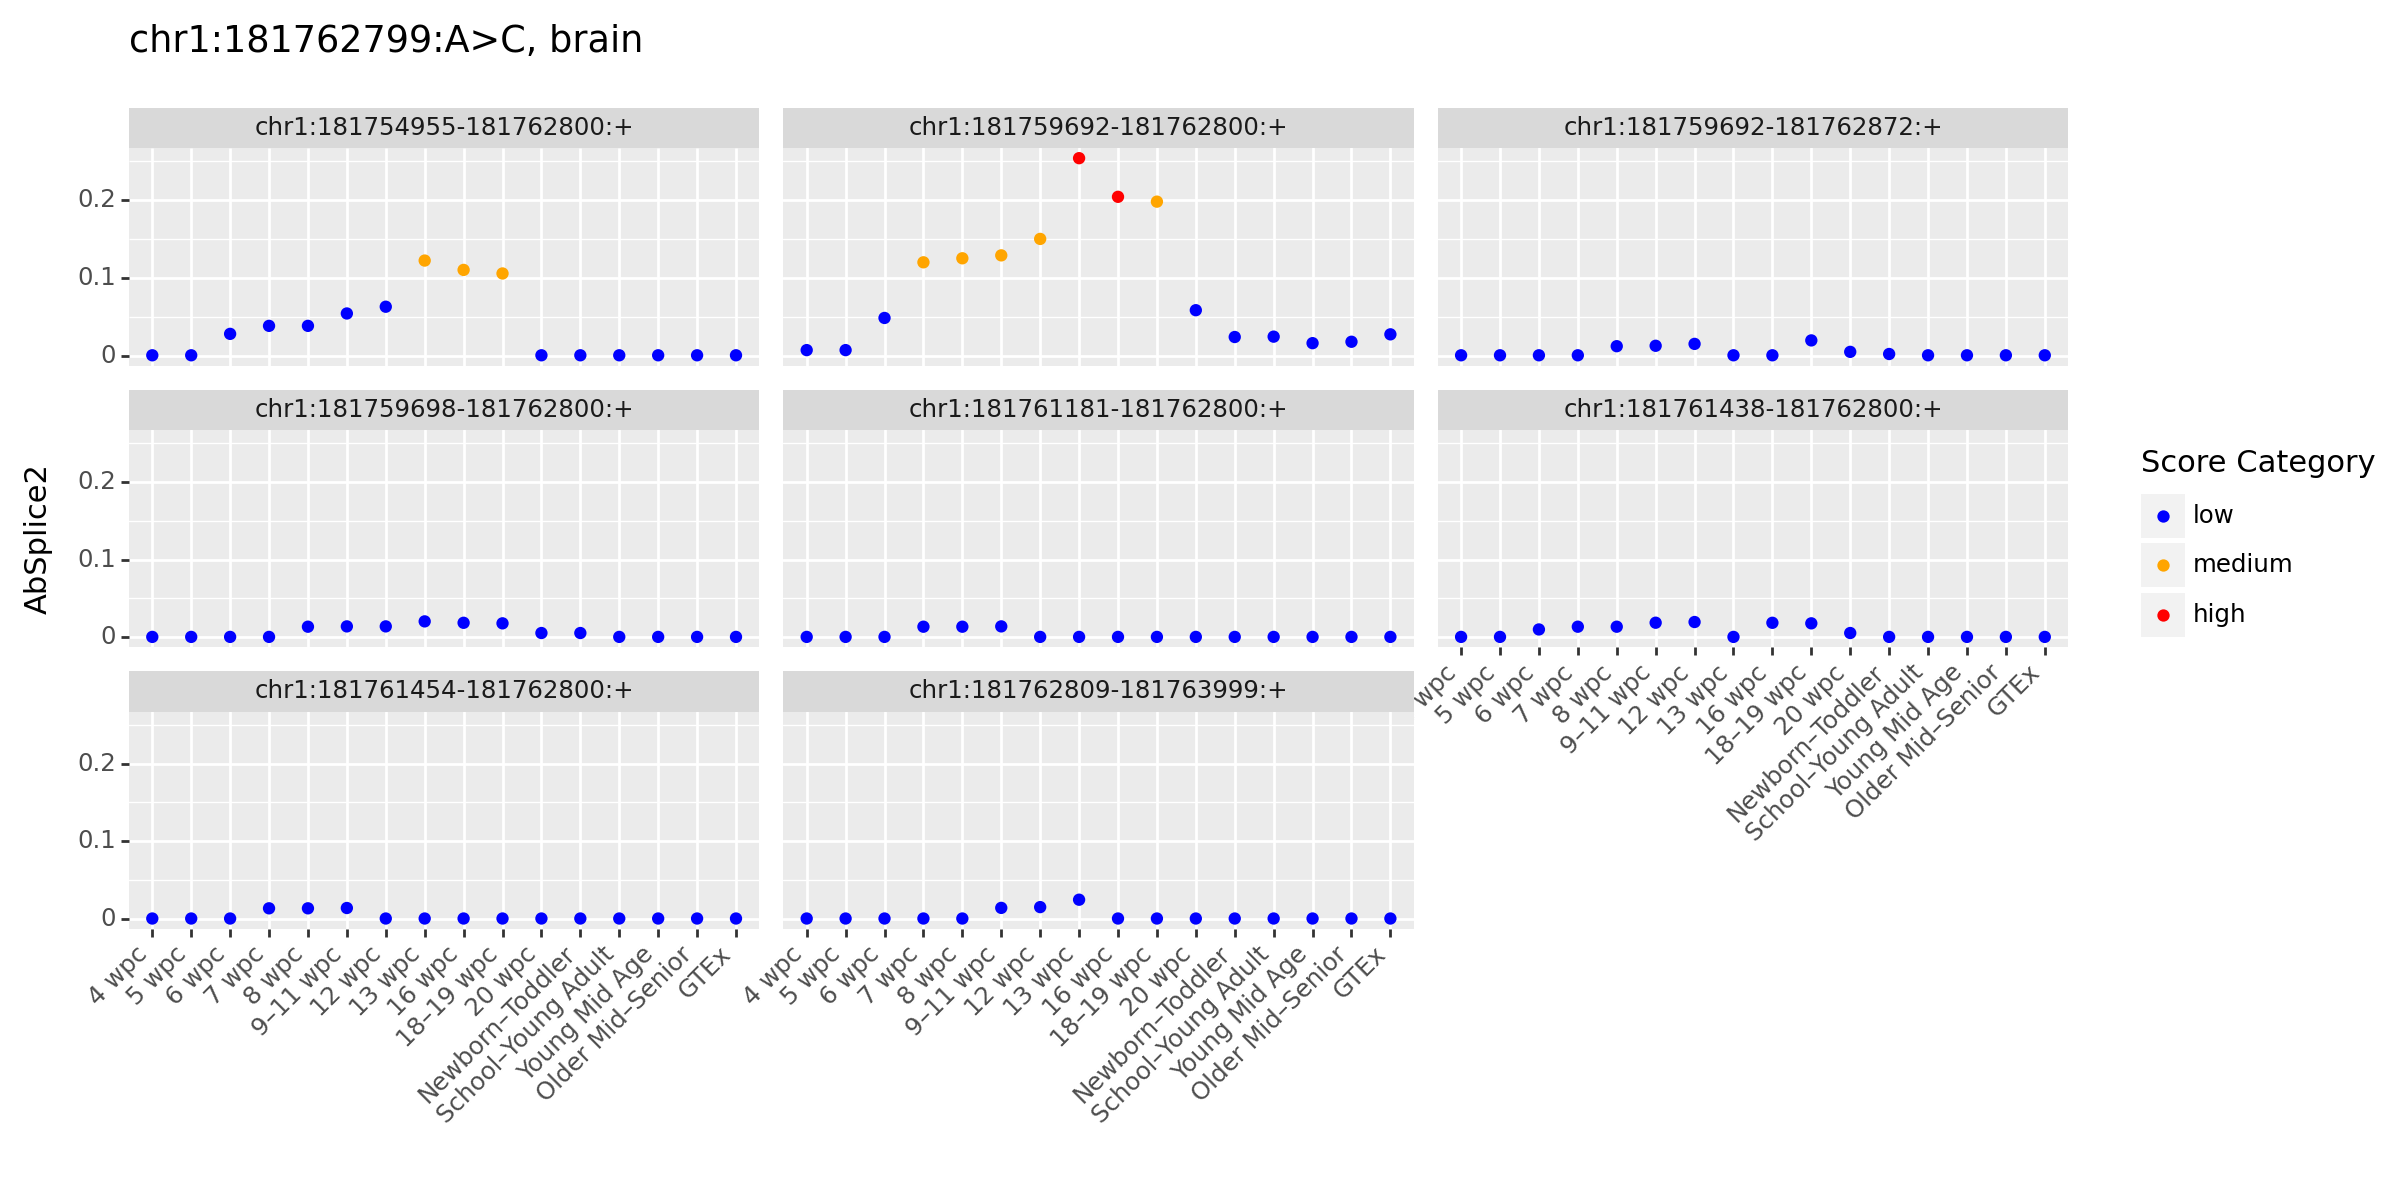

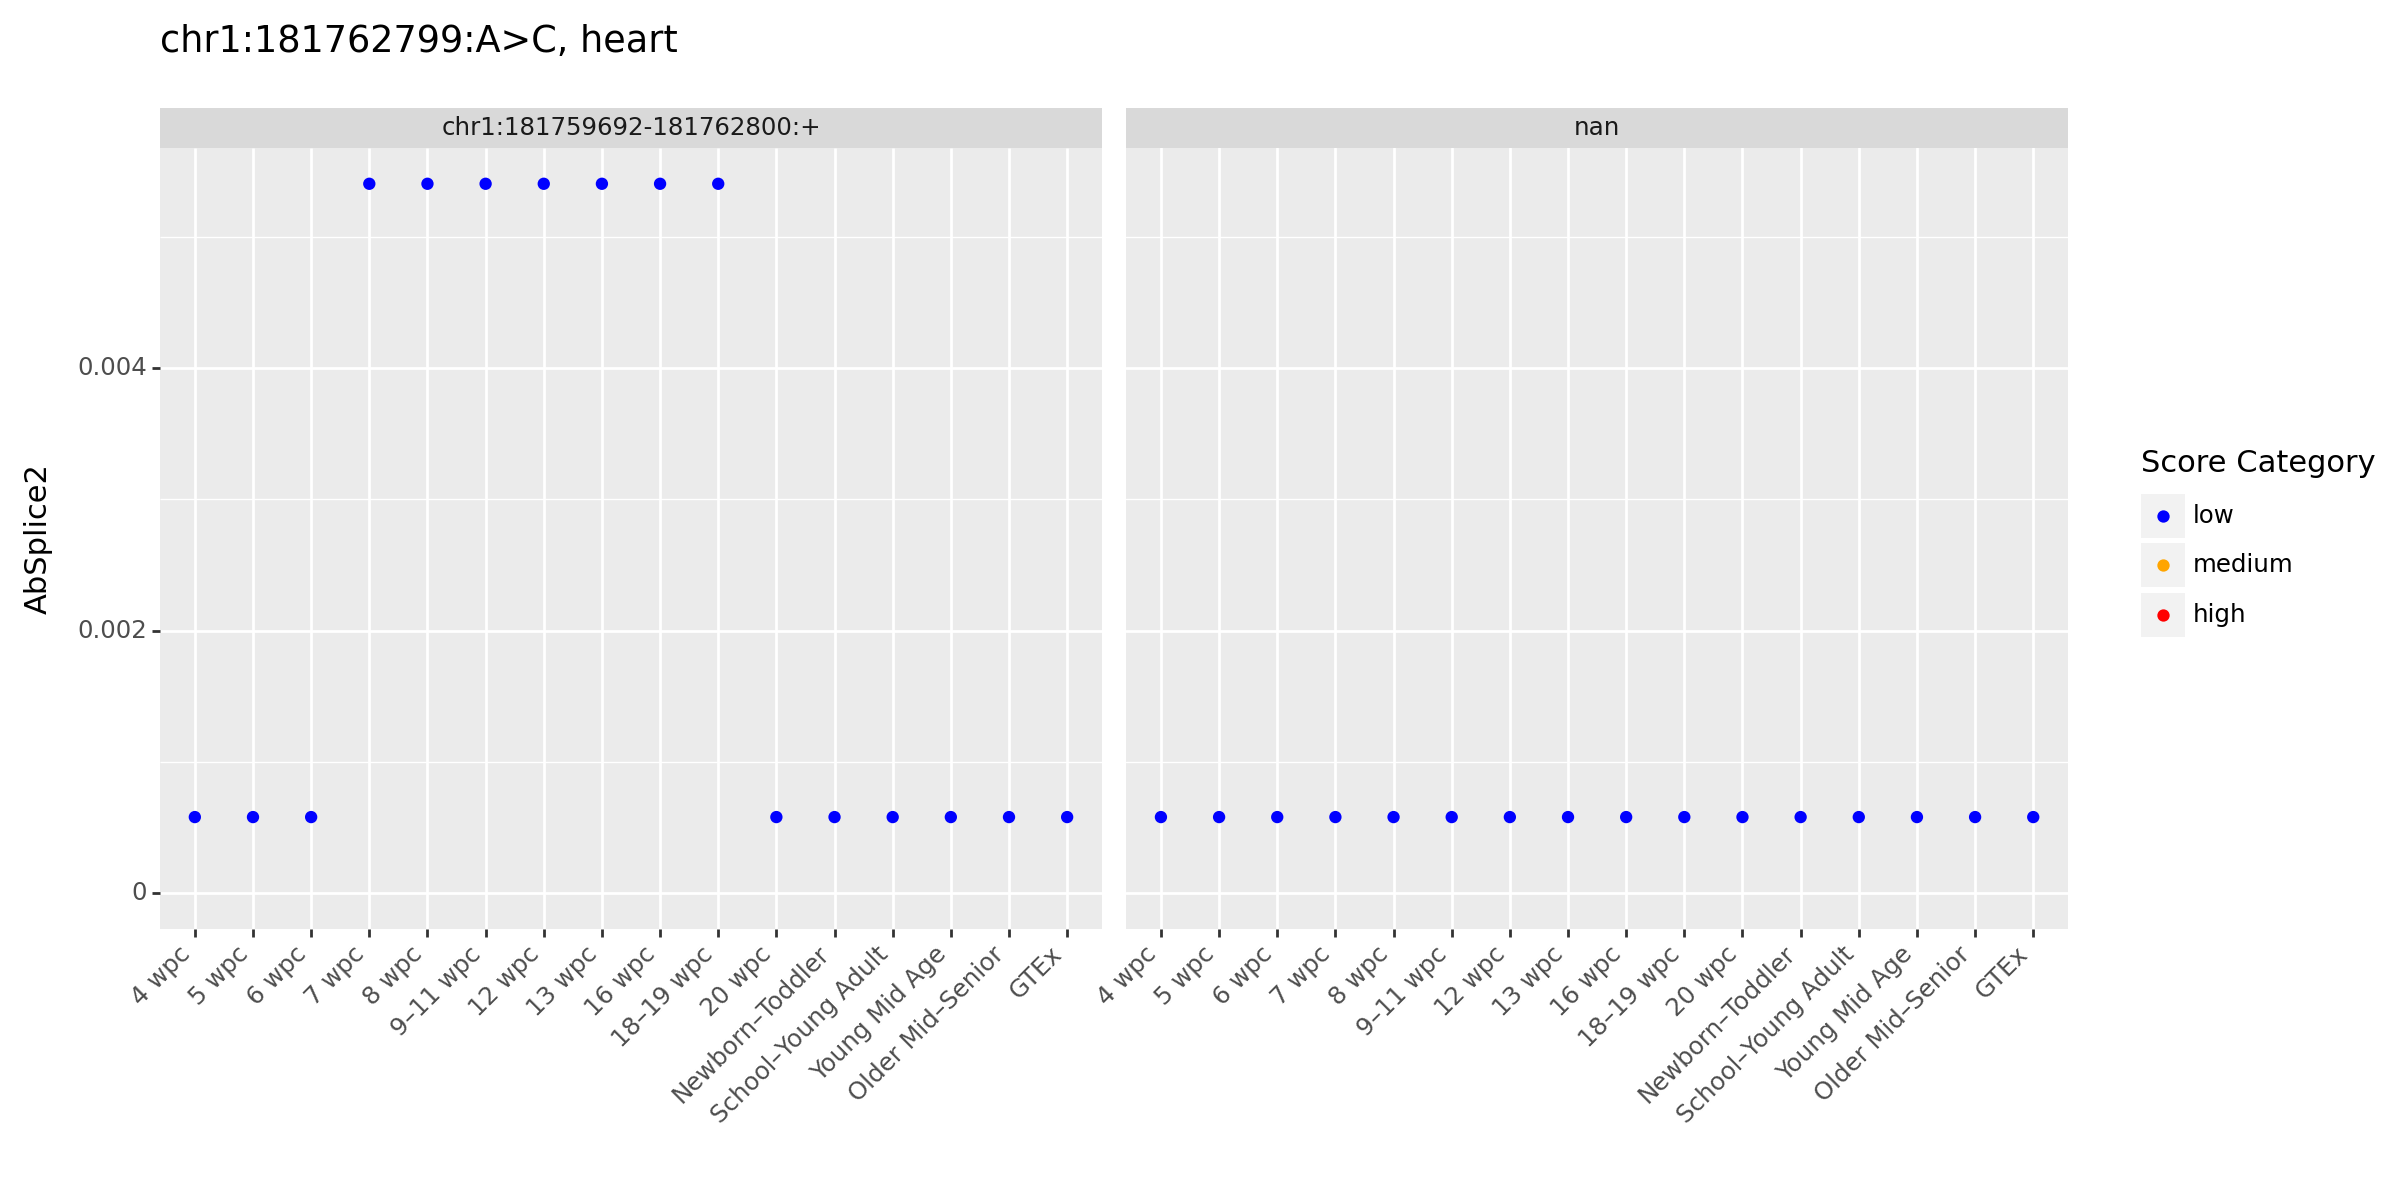

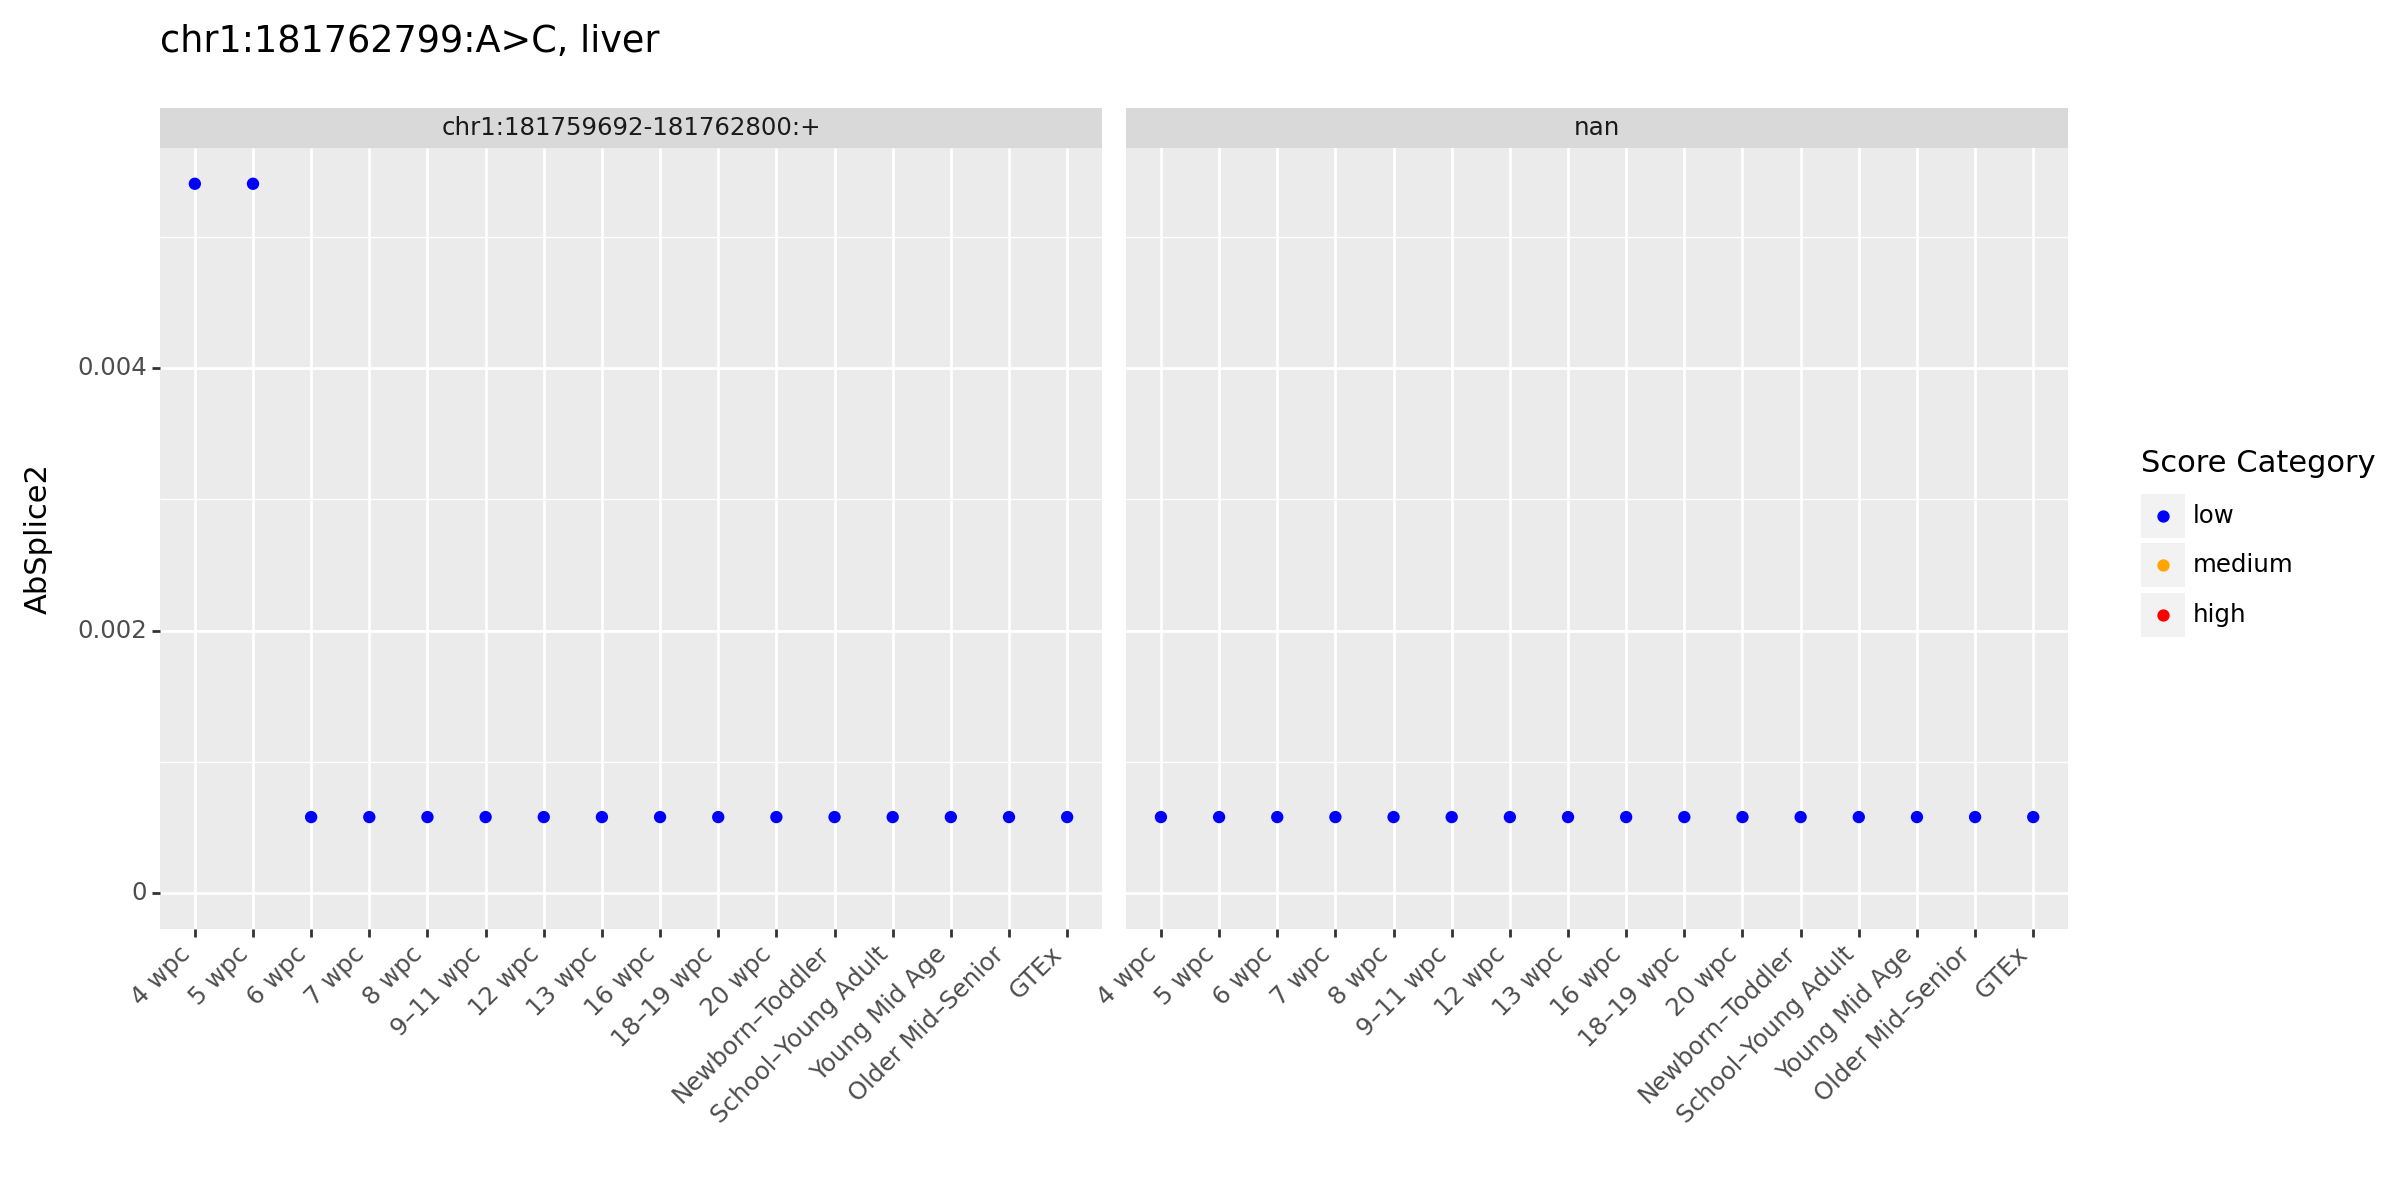

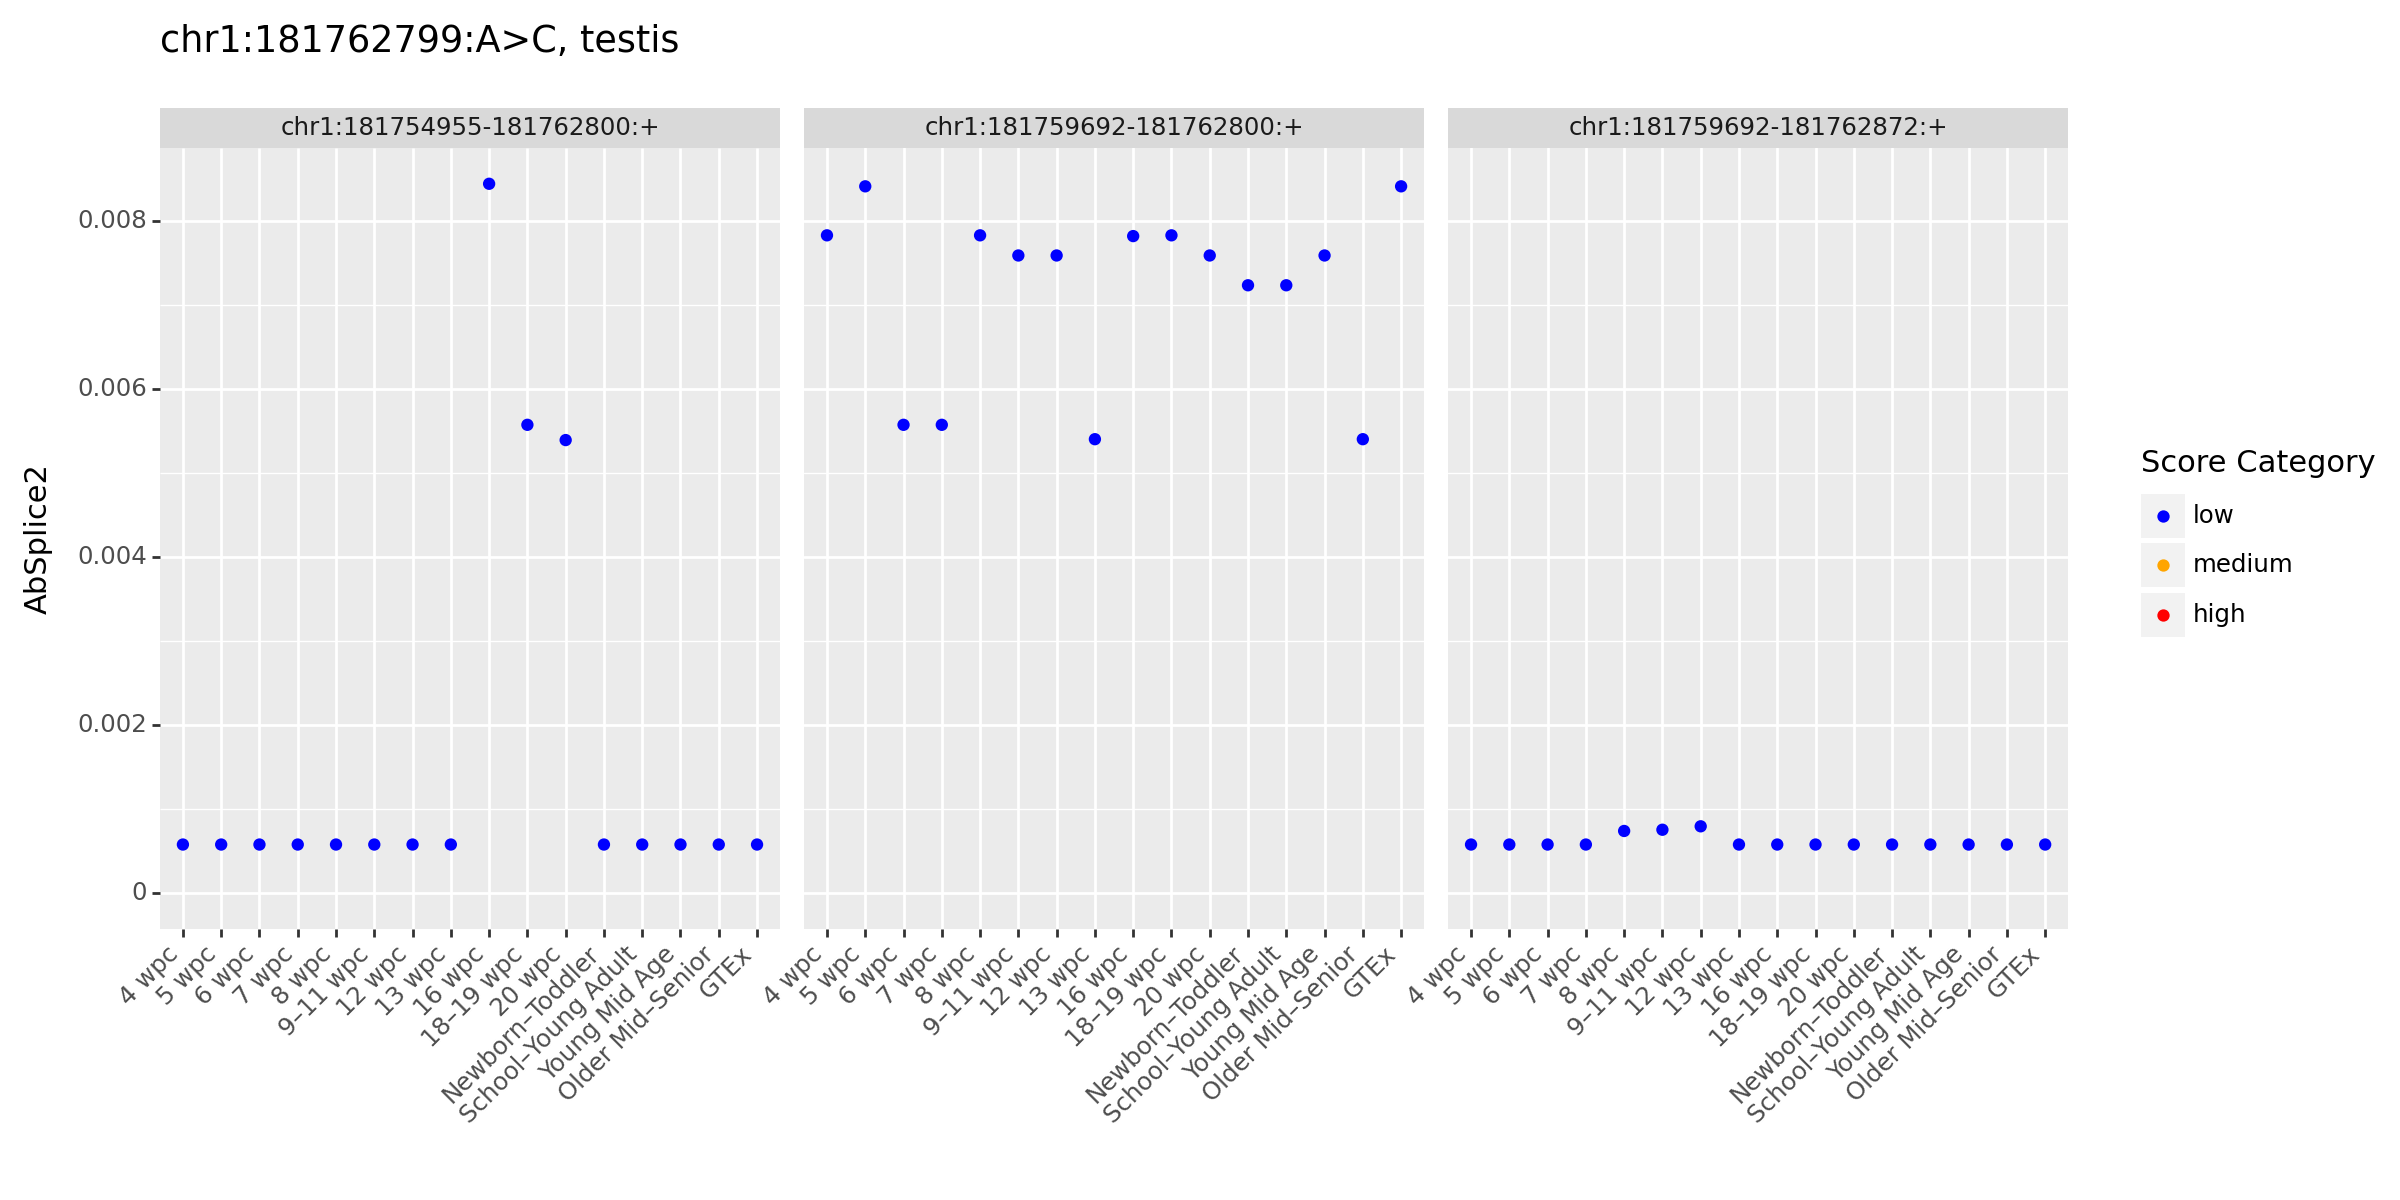

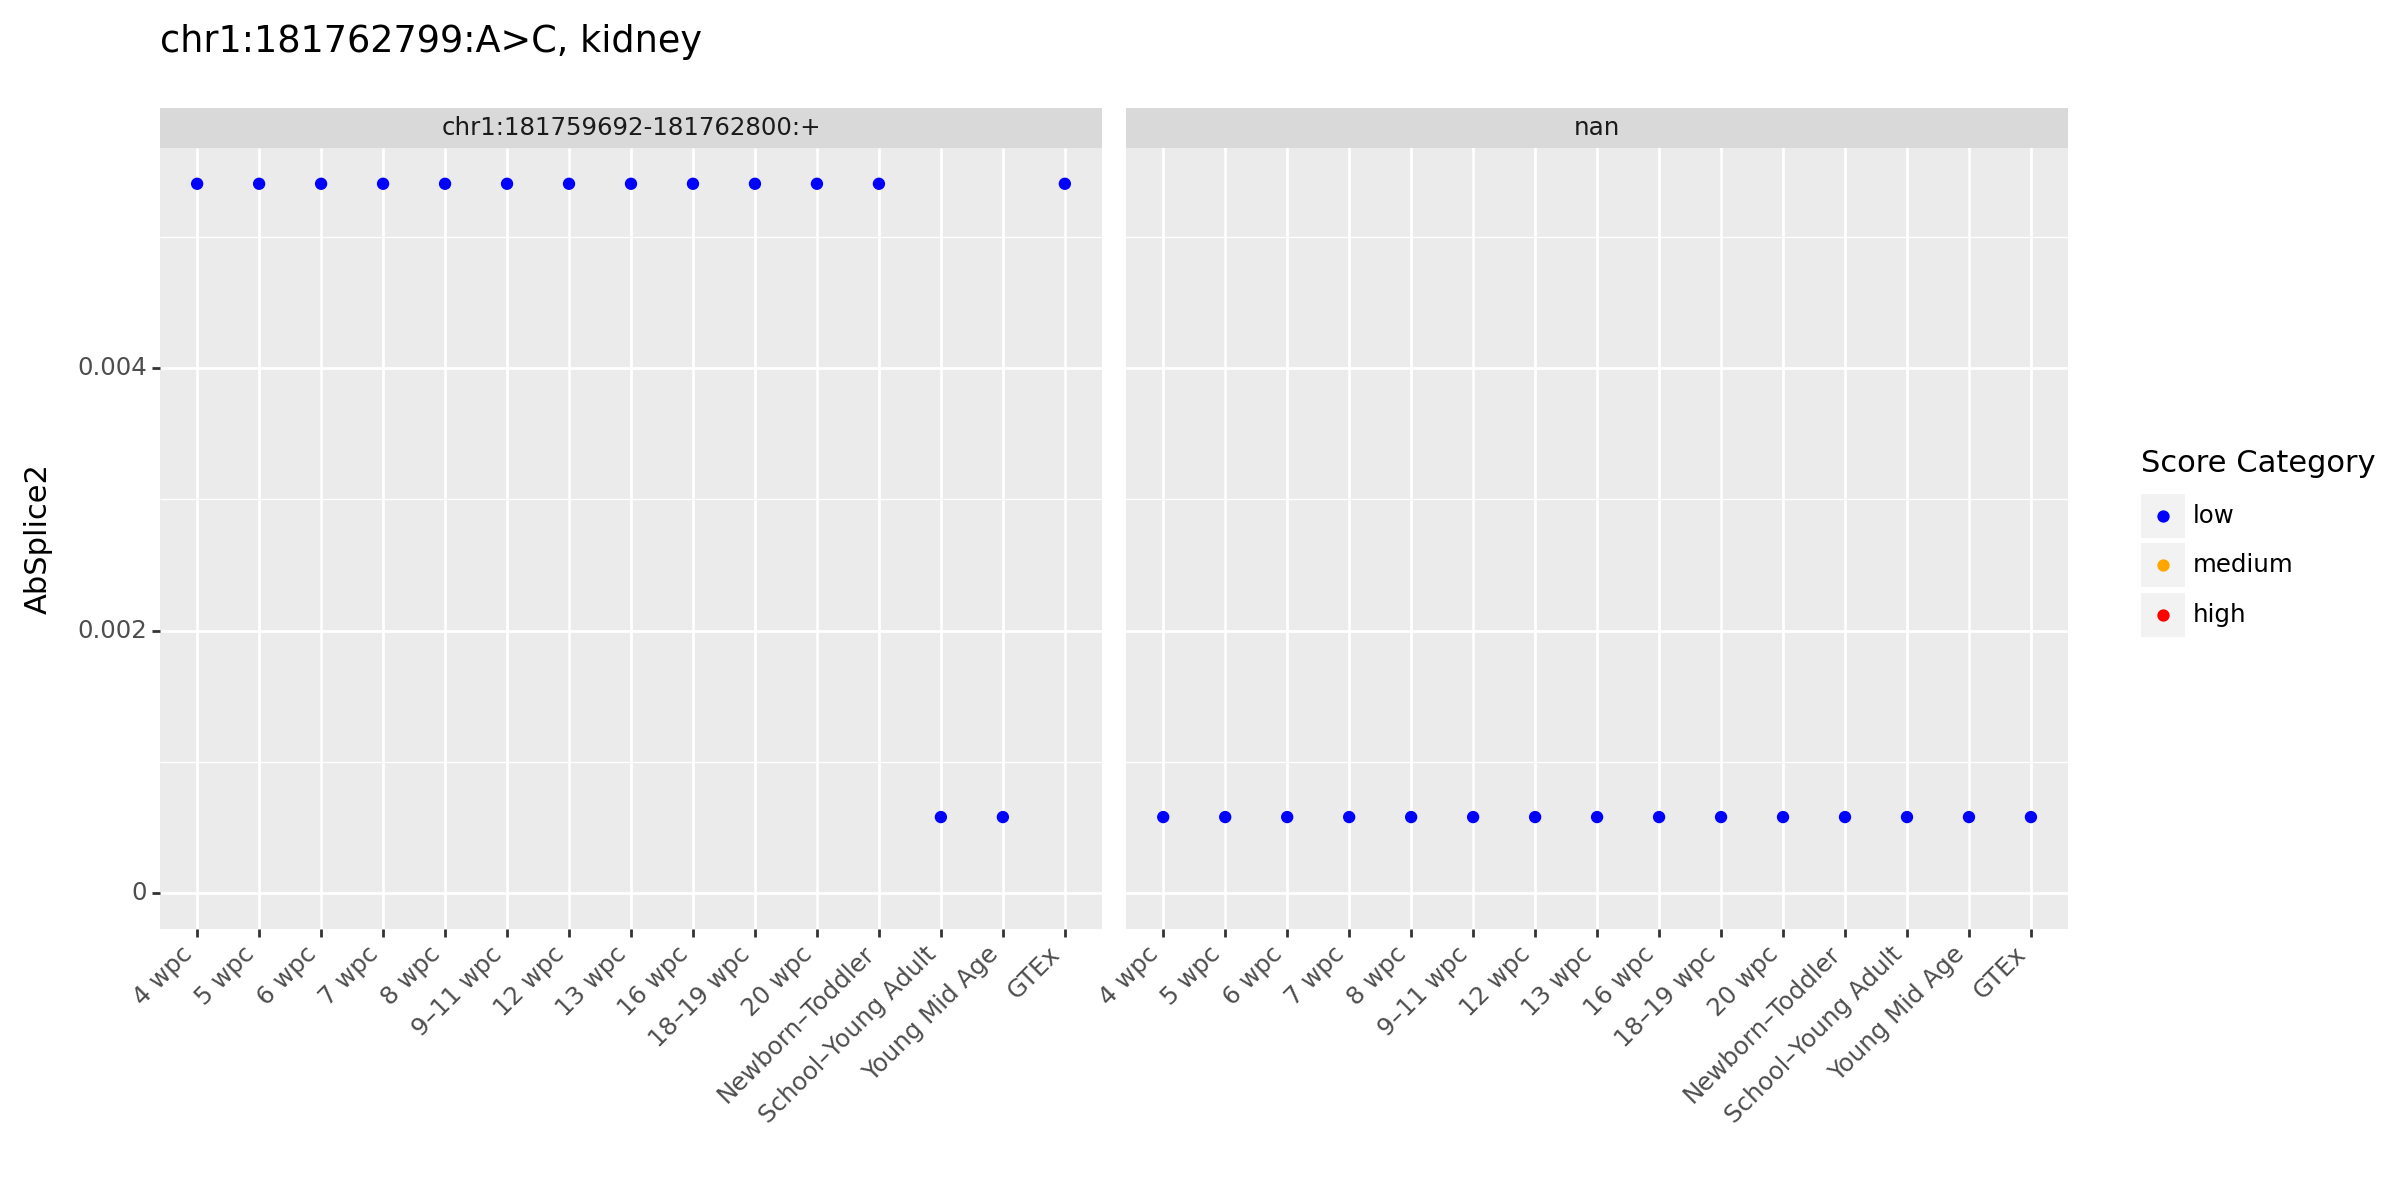

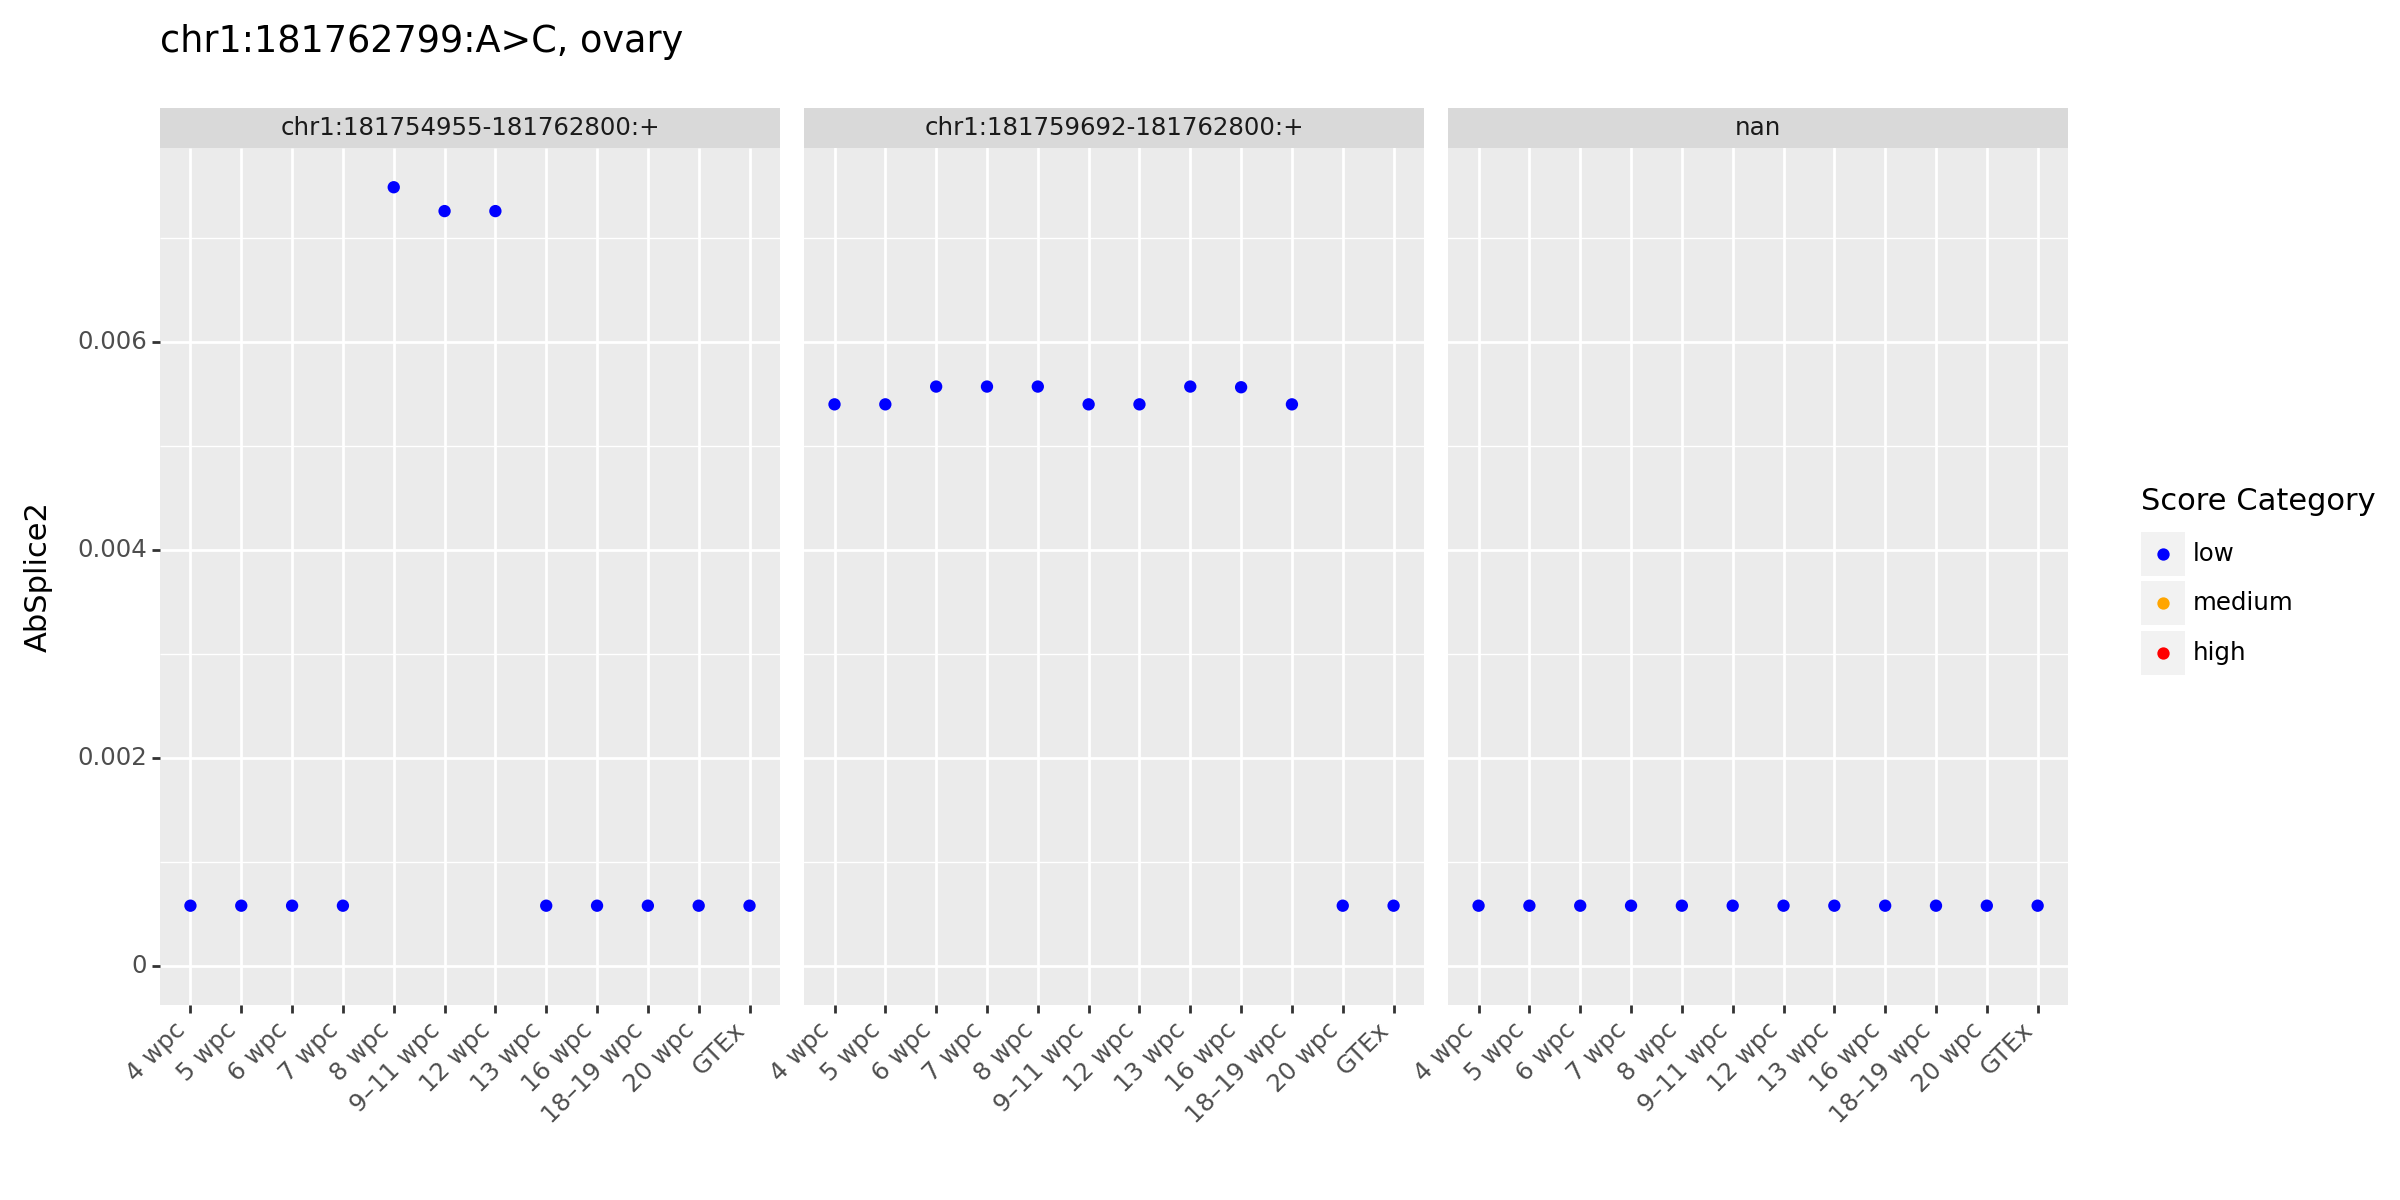

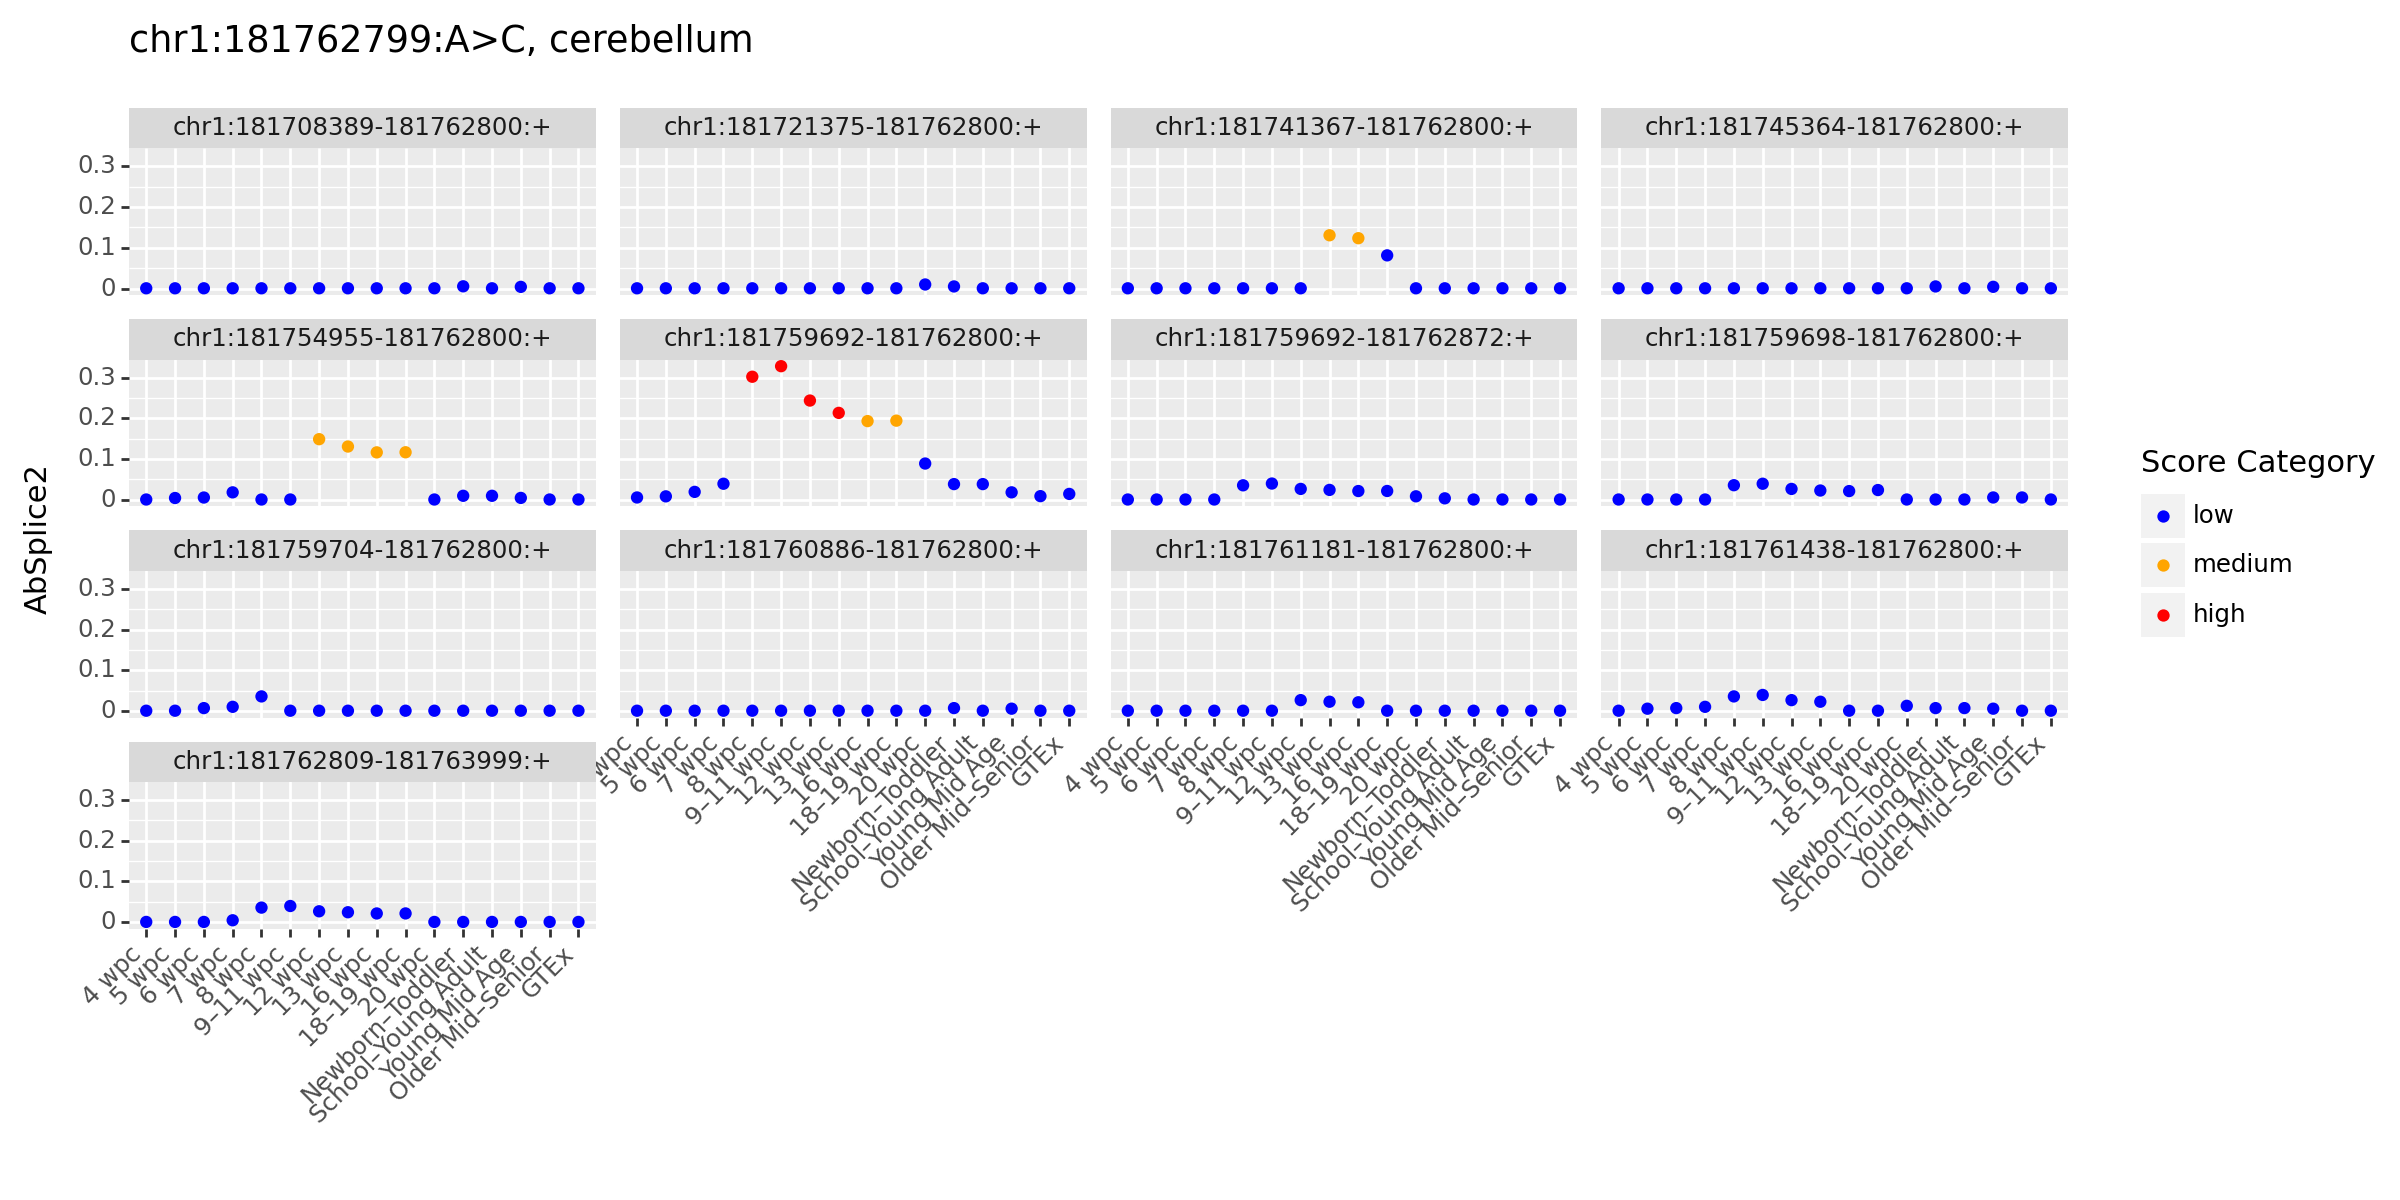

In [293]:
variant = variants_hg19[1]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [294]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

variant           tissue                    junction  \
3   chr1:181762799:A>C   human_brain_t4  chr1:181759692-181762800:+   
4   chr1:181762799:A>C   human_brain_t5  chr1:181759692-181762800:+   
5   chr1:181762799:A>C   human_brain_t6  chr1:181759692-181762800:+   
21  chr1:181762799:A>C   human_brain_t6  chr1:181754955-181762800:+   
6   chr1:181762799:A>C   human_brain_t7  chr1:181759692-181762800:+   
22  chr1:181762799:A>C   human_brain_t7  chr1:181754955-181762800:+   
7   chr1:181762799:A>C   human_brain_t8  chr1:181759692-181762800:+   
23  chr1:181762799:A>C   human_brain_t8  chr1:181754955-181762800:+   
8   chr1:181762799:A>C   human_brain_t9  chr1:181759692-181762800:+   
24  chr1:181762799:A>C   human_brain_t9  chr1:181754955-181762800:+   
9   chr1:181762799:A>C  human_brain_t10  chr1:181759692-181762800:+   
25  chr1:181762799:A>C  human_brain_t10  chr1:181754955-181762800:+   
10  chr1:181762799:A>C  human_brain_t11  chr1:181759692-181762800:+   

    gain_score  gain_pos  loss_score  loss_pos  delta_logit_psi  delta_psi  \
3         0.01      10.0       -0.72       2.0         -2.53307  -0.503162   
4         0.01      10.0       -0.72       2.0         -2.53307  -0.443471   
5         0.01      10.0       -0.72       2.0         -2.53307  -0.420479   
21        0.01      10.0       -0.72       2.0         -2.53307  -0.009198   
6         0.01      10.0       -0.72       2.0         -2.53307  -0.375064   
22        0.01      10.0       -0.72       2.0         -2.53307  -0.009198   
7         0.01      10.0       -0.72       2.0         -2.53307  -0.295792   
23        0.01      10.0       -0.72       2.0         -2.53307  -0.009198   
8         0.01      10.0       -0.72       2.0         -2.53307  -0.280586   
24        0.01      10.0       -0.72       2.0         -2.53307  -0.009198   
9         0.01      10.0       -0.72       2.0         -2.53307  -0.244405   
25        0.01      10.0       -0.72       2.0         -2.53307  -0.009198   
10        0.01      10.0       -0.72       2.0         -2.53307  -0.248232   

    median_n  median_n_pangolin tp_description  AbSplice2  
3       32.0               16.0          7 wpc   0.120189  
4       32.0               16.0          8 wpc   0.125379  
5       35.0               17.0       9–11 wpc   0.129128  
21      25.0               17.0       9–11 wpc   0.054373  
6       42.5               17.0         12 wpc   0.150296  
22      29.0               17.0         12 wpc   0.063053  
7       63.5               23.5         13 wpc   0.254176  
23      57.0               23.5         13 wpc   0.122446  
8       54.0               22.0         16 wpc   0.204455  
24      45.0               22.0         16 wpc   0.110421  
9       54.5               20.5      18–19 wpc   0.198248  
25      41.5               20.5      18–19 wpc   0.105843  
10      30.5                7.0         20 wpc   0.058572

Empty DataFrame
Columns: [variant, tissue, junction, gain_score, gain_pos, loss_score, loss_pos, delta_logit_psi, delta_psi, median_n, median_n_pangolin, tp_description, AbSplice2]
Index: []

Empty DataFrame
Columns: [variant, tissue, junction, gain_score, gain_pos, loss_score, loss_pos, delta_logit_psi, delta_psi, median_n, median_n_pangolin, tp_description, AbSplice2]
Index: []

Empty DataFrame
Columns: [variant, tissue, junction, gain_score, gain_pos, loss_score, loss_pos, delta_logit_psi, delta_psi, median_n, median_n_pangolin, tp_description, AbSplice2]
Index: []

Empty DataFrame
Columns: [variant, tissue, junction, gain_score, gain_pos, loss_score, loss_pos, delta_logit_psi, delta_psi, median_n, median_n_pangolin, tp_description, AbSplice2]
Index: []

Empty DataFrame
Columns: [variant, tissue, junction, gain_score, gain_pos, loss_score, loss_pos, delta_logit_psi, delta_psi, median_n, median_n_pangolin, tp_description, AbSplice2]
Index: []

variant                tissue                    junction  \
4    chr1:181762799:A>C   human_cerebellum_t5  chr1:181759692-181762800:+   
5    chr1:181762799:A>C   human_cerebellum_t6  chr1:181759692-181762800:+   
6    chr1:181762799:A>C   human_cerebellum_t7  chr1:181759692-181762800:+   
22   chr1:181762799:A>C   human_cerebellum_t7  chr1:181754955-181762800:+   
7    chr1:181762799:A>C   human_cerebellum_t8  chr1:181759692-181762800:+   
23   chr1:181762799:A>C   human_cerebellum_t8  chr1:181754955-181762800:+   
135  chr1:181762799:A>C   human_cerebellum_t8  chr1:181741367-181762800:+   
8    chr1:181762799:A>C   human_cerebellum_t9  chr1:181759692-181762800:+   
24   chr1:181762799:A>C   human_cerebellum_t9  chr1:181754955-181762800:+   
136  chr1:181762799:A>C   human_cerebellum_t9  chr1:181741367-181762800:+   
9    chr1:181762799:A>C  human_cerebellum_t10  chr1:181759692-181762800:+   
25   chr1:181762799:A>C  human_cerebellum_t10  chr1:181754955-181762800:+   
137  chr1:181762799:A>C  human_cerebellum_t10  chr1:181741367-181762800:+   
10   chr1:181762799:A>C  human_cerebellum_t11  chr1:181759692-181762800:+   

     gain_score  gain_pos  loss_score  loss_pos  delta_logit_psi  delta_psi  \
4          0.01      10.0       -0.72       2.0         -2.53307  -0.559843   
5          0.01      10.0       -0.72       2.0         -2.53307  -0.554603   
6          0.01      10.0       -0.72       2.0         -2.53307  -0.537967   
22         0.01      10.0       -0.72       2.0         -2.53307  -0.009198   
7          0.01      10.0       -0.72       2.0         -2.53307  -0.531887   
23         0.01      10.0       -0.72       2.0         -2.53307  -0.009198   
135        0.01      10.0       -0.72       2.0         -2.53307  -0.009198   
8          0.01      10.0       -0.72       2.0         -2.53307  -0.520312   
24         0.01      10.0       -0.72       2.0         -2.53307  -0.012207   
136        0.01      10.0       -0.72       2.0         -2.53307  -0.009198   
9          0.01      10.0       -0.72       2.0         -2.53307  -0.535850   
25         0.01      10.0       -0.72       2.0         -2.53307  -0.009291   
137        0.01      10.0       -0.72       2.0         -2.53307  -0.009198   
10         0.01      10.0       -0.72       2.0         -2.53307  -0.356764   

     median_n  median_n_pangolin tp_description  AbSplice2  
4        41.0               35.0          8 wpc   0.302148  
5        50.0               39.0       9–11 wpc   0.328062  
6        45.5               32.0         12 wpc   0.243648  
22       43.0               32.0         12 wpc   0.148755  
7        41.0               29.0         13 wpc   0.213376  
23       42.0               29.0         13 wpc   0.130735  
135      46.0               29.0         13 wpc   0.130844  
8        38.5               28.0         16 wpc   0.193183  
24       38.0               28.0         16 wpc   0.116355  
136      45.0               28.0         16 wpc   0.123626  
9        36.0               30.0      18–19 wpc   0.194285  
25       31.0               30.0      18–19 wpc   0.116622  
137      24.0               30.0      18–19 wpc   0.081467  
10       26.0               14.5         20 wpc   0.088947

## HSPG2, chr1:21838825:C>T (hg38), chr1:22165318:C>T (hg19)

In [295]:
variant = variants_hg19[2]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

 57%|█████▋    | 4/7 [01:37<01:13, 24.42s/it]

KeyboardInterrupt



In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## POMGNT1, chr1:46190809:T>G (hg38), chr1:46656481:T>G (hg19)

In [ ]:
variant = variants_hg19[3]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## NDUFS1, chr2:206149017:T>C (hg38), chr2:207013741:T>C (hg19)

In [ ]:
variant = variants_hg19[4]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## FN1, chr2:215372382:G>C (hg38), chr2:216237105:G>C (hg19)

In [ ]:
variant = variants_hg19[5]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## AFF3, chr2:99554536:T>C (hg38), chr2:100170998:T>C (hg19)

In [ ]:
variant = variants_hg19[6]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## ACY1, chr3:51987627:A>T (hg38), chr3:52021643:A>T (hg19)

In [ ]:
variant = variants_hg19[7]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## PLK4, chr4:127891683:T>C (hg38), chr4:128812838:T>C (hg19)

In [ ]:
variant = variants_hg19[8]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## HNRNPH1, chr5:179623635:C>G (hg38), chr5:179050636:C>G (hg19)

In [ ]:
variant = variants_hg19[9]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## NSUN2, chr5:6606872:C>T (hg38), chr5:6606985:C>T (hg19)

In [ ]:
variant = variants_hg19[10]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## NRCAM, chr7:108237751:C>T (hg38), chr7:107878195:C>T (hg19)

In [ ]:
variant = variants_hg19[11]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## GPAA1, chr8:144085277:T>G (hg38), chr8:145140180:T>G (hg19)

In [ ]:
variant = variants_hg19[12]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## FGFR1, chr8:38428099:C>T (hg38), chr8:38285617:C>T (hg19)

In [ ]:
variant = variants_hg19[13]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## ARFGEF1, chr8:67203252:C>T (hg38), chr8:68115487:C>T (hg19)

In [ ]:
variant = variants_hg19[14]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## MPDZ, chr9:13147659:C>G (hg38), chr9:13147658:C>G (hg19)

In [ ]:
variant = variants_hg19[15]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## SECISBP2, chr9:89334732:T>C (hg38), chr9:91949647:T>C (hg19)

In [ ]:
variant = variants_hg19[16]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## ANK3, chr10:60166590:C>A (hg38), chr10:61926348:C>A (hg19)

In [ ]:
variant = variants_hg19[17]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## CTNND1, chr11:57806454:C>G (hg38), chr11:57573926:C>G (hg19)

In [ ]:
variant = variants_hg19[18]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## KIF5A, chr12:57582586:A>G (hg38), chr12:57976369:A>G (hg19)

In [ ]:
variant = variants_hg19[19]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## TCF12, chr15:57252494:T>A (hg38), chr15:57544692:T>A (hg19)

In [ ]:
variant = variants_hg19[20]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## FANCI, chr15:89303919:A>G (hg38), chr15:89847150:A>G (hg19)

In [ ]:
variant = variants_hg19[21]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## TMEM231, chr16:75542598:T>C (hg38), chr16:75576496:T>C (hg19)

In [ ]:
variant = variants_hg19[22]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## TMEM231, chr16:75542601:C>T (hg38), chr16:75576499:C>T (hg19)

In [ ]:
variant = variants_hg19[23]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## NF1, chr17:31253005:G>A (hg38), chr17:29580023:G>A (hg19)

In [ ]:
variant = variants_hg19[24]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))

## CHCHD10, chr22:23766253:T>G (hg38), chr22:24108440:T>G (hg19)

In [ ]:
variant = variants_hg19[25]
df, df_all = plot_and_save(variant=variant, save=True)
plot_all_junctions(df, variant, tissues_dev)

In [ ]:
for i in range(len(tissues_dev)):
    _df = df[i]
    _df['variant'] = _df.apply(lambda x: f"{x['chrom']}:{x['end']}:{x['ref']}>{x['alt']}", axis=1)
    _df = _df.rename(columns={'model_27': 'AbSplice2'})
    _df = _df[[
        'variant','tissue', 'junction',
        'gain_score', 'gain_pos', 'loss_score', 'loss_pos', 'delta_logit_psi', 'delta_psi', 'median_n', 'median_n_pangolin', 'tp_description', 'AbSplice2'
    ]].drop_duplicates()
    display(_df[
        _df['AbSplice2'] > 0.05
    ].sort_values(by='tp_description', ascending=True))